# Unsupervised learning capstone

For your third capstone, you’ll complete an unsupervised learning project. You can choose your own research question or choose from one below.

Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

Be prepared to talk about:

- Your end-user and the value your project provides to them.
- Quantifiable results based on the research you’ve conducted.
- The visuals you chose and what they represent for your research.
- Next steps you'd take to expand on your work.
- A specified research question your model addresses.
- How you chose your model specification and what alternatives you compared it to.
- The practical uses of your model for an audience of interest.
- Any weak points or shortcomings of your model.

[Animal Outbreaks](https://www.kaggle.com/tentotheminus9/empres-global-animal-disease-surveillance)

# The Data

I've chosen to explore, and analze data on [animal disease outbreaks](https://www.kaggle.com/tentotheminus9/empres-global-animal-disease-surveillance) found on Kaggle gathered by EMPRES Global Animal Disease Information System (EMPRES-i), an application created to assist veterinary services by providing information on global diseases. The ability to understand the inception and spread of these diseases and ultimately predict where and how future incidents/episodes will unfold is crucial in our efforts to combat the damage caused. While some may believe the animals' health is irrelevant to us, this couldn't be farther from the truth - on an obvious level, because roughly 90% of the world's population eats meat it is advantageous for us to keep our fellow animals healthy. What is less known but perhaps even more important is that many epidemiologists believe it's likely that the next pandemic will come from an animal, similar to the SARS and MERS viruses that have killed hundreds.

The data includes just over 17,000 cases of animal outbreaks. Each row represents a different outbreak so there are some repeating diseases. Variables include timing, place, species, and diseases, as well as information on the number of animals and humans affected. I'll use clutering and other unsupervised learning in an effort to learn about the onset and dispersion of animal disease outbreaks. Ideally, the data will collect in such a way that I am able to differentiate/locate/predict outbreaks with pandemic potential.

In [190]:
import os
os.chdir('/Users/sophiaperides/Desktop/Thinkful')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
%matplotlib inline
from datetime import datetime, timedelta
import re


from matplotlib import image
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
import scipy.stats as stats
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.layers import Input,Dense
from keras.models import Model

import keras
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import datasets, metrics
from sklearn.neural_network import BernoulliRBM
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage as lnkg

In [191]:
outbreaks = pd.read_csv('animal_outbreaks.csv')
outbreaks = pd.DataFrame(outbreaks)
print(outbreaks.columns)
print(outbreaks.info())


Index(['Id', 'source', 'latitude', 'longitude', 'region', 'country', 'admin1',
       'localityName', 'localityQuality', 'observationDate', 'reportingDate',
       'status', 'disease', 'serotypes', 'speciesDescription', 'sumAtRisk',
       'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansGenderDesc', 'humansAge', 'humansAffected', 'humansDeaths'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 24 columns):
Id                    17008 non-null int64
source                17008 non-null object
latitude              17008 non-null float64
longitude             17008 non-null float64
region                17008 non-null object
country               17008 non-null object
admin1                17008 non-null object
localityName          17008 non-null object
localityQuality       17008 non-null object
observationDate       16506 non-null object
reportingDate         17008 non-null object
status    

In [192]:
print('Value counts for humansAffected: ', outbreaks.humansAffected.value_counts())
print('Value counts for humansDeaths: ', outbreaks.humansDeaths.value_counts())

Value counts for humansAffected:  1.0     1411
0.0        3
24.0       1
3.0        1
4.0        1
Name: humansAffected, dtype: int64
Value counts for humansDeaths:  1.0    399
0.0     51
2.0      1
Name: humansDeaths, dtype: int64


# The Cleaning

More than half of the variables are not missing any data which is a great start. Just under 7,000 rows are missing information on serotypes so I will fill these with 'Uknown Serotypes'. Similarly, under 2,000 rows are missing in speciesDescription, so these will be filled with 'Unknown Species'. Additionally, the information populating these cells are lists of animals so I will create new dummy variables with keywords, including 'wild' and 'domestic'. Finally, I'll create new features 'birds' and 'mammals' which will indicate whether a disease affected these classes.

Empty cells in sumAtRisk, sumCases, sumDeaths, sumDestroyed, sumSlaughtered, and humansAge will be filled with the mean value of these columns. I will drop the column humansGenderDesc as there is simply not enough information for me to populate the missing values. As for humansAffected and humansDeaths, I'll populate missing values with the mode.

All dates in the data will be converted to datetime objects and create variables for the year, month, and day of the observation. Missing variables in observationDate will be filled by finding the average difference between the observationDate and reportingDate, and subtracting this number from the reportingDate. A new variable, 'differenceInDays', will be created by finding the difference between the observationDate and reportingDate for each instance. There are just over 3,700 entries with observationDate values after reportingDates. This is impossible, so I will delete these rows.

Dummies will be created for source, region, country, localityQuality, disease, serotypes, and status.

In [193]:
outbreaks.serotypes.fillna('UknownSerotypes', inplace=True)
outbreaks.speciesDescription.fillna('UknownSpecies', inplace=True)
outbreaks.sumAtRisk.fillna(outbreaks.sumAtRisk.mean(), inplace=True)
outbreaks.sumCases.fillna(outbreaks.sumCases.mean(), inplace=True)
outbreaks.sumDeaths.fillna(outbreaks.sumDeaths.mean(), inplace=True)
outbreaks.sumDestroyed.fillna(outbreaks.sumDestroyed.mean(), inplace=True)
outbreaks.sumSlaughtered.fillna(outbreaks.sumSlaughtered.mean(), inplace=True)
outbreaks.drop(columns=['humansGenderDesc'], inplace=True)
outbreaks.humansAge.fillna(outbreaks.humansAge.mean(), inplace=True)
outbreaks.humansAffected.fillna(outbreaks.humansAffected.mode()[0], inplace=True)
outbreaks.humansDeaths.fillna(outbreaks.humansDeaths.mode()[0], inplace=True)

In [194]:
print('Reporting Dates: \n', outbreaks.reportingDate.head())
print('Observation Dates: \n', outbreaks.observationDate.head())

Reporting Dates: 
 0    22/08/2017
1    18/08/2017
2    16/08/2017
3    22/08/2017
4    17/08/2017
Name: reportingDate, dtype: object
Observation Dates: 
 0    17/08/2017
1    16/08/2017
2    16/08/2017
3    15/08/2017
4    15/08/2017
Name: observationDate, dtype: object


In [195]:
# Creating a new dataframe to handle the dates
outbreaks['observationDate'] = pd.to_datetime(outbreaks['observationDate'])
outbreaks['reportingDate'] = pd.to_datetime(outbreaks['reportingDate'])
outbreaks_time = outbreaks[['observationDate', 'reportingDate']]
outbreaks_time.dropna(inplace=True)

# Find the average difference between observation and reporting dates
outbreaks_time['differenceInDays'] = (outbreaks_time['reportingDate'] - outbreaks_time['observationDate'])/np.timedelta64(1,'D')
                                                                     
print('Average difference between observation and reporting dates: ', outbreaks_time['differenceInDays'].mean())
outbreaks.observationDate.fillna(outbreaks.reportingDate - timedelta(days=33), inplace=True)

# Creating a new variable
outbreaks['differenceInDays'] = (outbreaks['reportingDate'] - outbreaks['observationDate'])/np.timedelta64(1,'D')


Average difference between observation and reporting dates:  33.20907548770144


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [196]:
outbreaks.differenceInDays.head()

0    5.0
1    2.0
2    0.0
3    7.0
4    2.0
Name: differenceInDays, dtype: float64

In [197]:
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 24 columns):
Id                    17008 non-null int64
source                17008 non-null object
latitude              17008 non-null float64
longitude             17008 non-null float64
region                17008 non-null object
country               17008 non-null object
admin1                17008 non-null object
localityName          17008 non-null object
localityQuality       17008 non-null object
observationDate       17008 non-null datetime64[ns]
reportingDate         17008 non-null datetime64[ns]
status                17008 non-null object
disease               17008 non-null object
serotypes             17008 non-null object
speciesDescription    17008 non-null object
sumAtRisk             17008 non-null float64
sumCases              17008 non-null float64
sumDeaths             17008 non-null float64
sumDestroyed          17008 non-null float64
sumSlaughtered        17008 non-nu

In [198]:
outbreaks['observationYear'] = pd.DatetimeIndex(outbreaks['observationDate']).year
outbreaks['observationMonth'] = pd.DatetimeIndex(outbreaks['observationDate']).month
outbreaks['observationDay'] = pd.DatetimeIndex(outbreaks['observationDate']).day
outbreaks['observationFirstHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x <= 15 else 0 )
outbreaks['observationSecondHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x > 15 else 0 )

In [199]:
pd.options.display.max_columns = None
outbreaks.head()

Id source   latitude  longitude  region             country  \
0  230399    OIE -27.900000  30.800000  Africa        South Africa   
1  230381    OIE  54.837037  73.354155  Europe  Russian Federation   
2  230333    OIE -21.077740  30.211620  Africa            Zimbabwe   
3  230396    OIE -26.000000  28.300000  Africa        South Africa   
4  230371    OIE  49.237900  17.700200  Europe      Czech Republic   

           admin1        localityName localityQuality observationDate  \
0   KwaZulu-Natal  HPAI_H5N8_2017_019           Exact      2017-08-17   
1  Omskaya Oblast      Novaya Stanica           Exact      2017-08-16   
2        Masvingo              Mwambe           Exact      2017-08-16   
3         Gauteng  HPAI_H5N8_2017_020           Exact      2017-08-15   
4    Jihomoravsky            HvozdnÃ¡           Exact      2017-08-15   

  reportingDate     status                 disease        serotypes  \
0    2017-08-22  Confirmed       Influenza - Avian        H5N8 HPAI   
1    2017-08-18  Confirmed     African swine fever  UknownSerotypes   
2    2017-08-16  Confirmed  Foot and mouth disease  UknownSerotypes   
3    2017-08-22  Confirmed       Influenza - Avian        H5N8 HPAI   
4    2017-08-17  Confirmed     African swine fever  UknownSerotypes   

           speciesDescription      sumAtRisk  sumCases  sumDeaths  \
0  domestic, unspecified bird  248000.000000      12.0       12.0   
1             domestic, swine     122.000000       6.0        1.0   
2            domestic, cattle    1283.000000     112.0        0.0   
3      wild, unspecified bird    7500.691709       1.0        1.0   
4             wild, wild boar    7500.691709       1.0        1.0   

   sumDestroyed  sumSlaughtered  humansAge  humansAffected  humansDeaths  \
0  50000.000000        0.000000   0.000000             1.0           1.0   
1      0.000000        0.000000  17.701311             1.0           1.0   
2   3765.857978        7.000000  17.701311             1.0           1.0   
3      0.000000        0.000000   0.000000             1.0           1.0   
4   3765.857978      100.211443  17.701311             1.0           1.0   

   differenceInDays  observationYear  observationMonth  observationDay  \
0               5.0             2017                 8              17   
1               2.0             2017                 8              16   
2               0.0             2017                 8              16   
3               7.0             2017                 8              15   
4               2.0             2017                 8              15   

   observationFirstHalfMonth  observationSecondHalfMonth  
0                          0                           1  
1                          0                           1  
2                          0                           1  
3                          1                           0  
4                          1                           0

In [200]:
print('Unique values in source: ', len(outbreaks.source.unique()))
print('Unique values in region: ', len(outbreaks.region.unique()))
print('Unique values in country: ', len(outbreaks.country.unique()))
print('Unique values in admin1: ', len(outbreaks.admin1.unique()))
print('Unique values in localityName: ', len(outbreaks.localityName.unique()))
print('Unique values in localityQuality: ', len(outbreaks.localityQuality.unique()))
print('Unique values in status: ', len(outbreaks.status.unique()))
print('Unique values in disease: ', len(outbreaks.disease.unique()))
print('Unique values in serotypes: ', len(outbreaks.serotypes.unique()))
print('Unique values in speciesDescription: ', len(outbreaks.speciesDescription.unique()))


Unique values in source:  12
Unique values in region:  4
Unique values in country:  122
Unique values in admin1:  941
Unique values in localityName:  9279
Unique values in localityQuality:  5
Unique values in status:  2
Unique values in disease:  26
Unique values in serotypes:  61
Unique values in speciesDescription:  289


In [201]:
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['source'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['region'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['country'])], axis=1)
outbreaks.drop(columns=['admin1', 'localityName'], inplace=True)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['localityQuality'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['status'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['disease'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['serotypes'])], axis=1)


In [202]:
outbreaks.speciesDescription.unique()

array(['domestic, unspecified bird', 'domestic, swine',
       'domestic, cattle', 'wild, unspecified bird', 'wild, wild boar',
       'domestic, goose', 'domestic, chicken', 'domestic, equidae',
       'wild,mute swan (cygnus olor))', 'domestic, turkey',
       'wild, mallard', 'UknownSpecies',
       'wild, house sparrow, wild, unspecified bird', 'domestic, horse',
       'domestic, cat, domestic, dog',
       'wild,egyptian goose (alopochen aegyptiacus))', 'wild, duck',
       'domestic, pigeon', 'domestic, dog', 'domestic, sheep',
       'domestic, cat', 'domestic, duck',
       'domestic, chicken, environmental sample, unspecified bird',
       'environmental sample, unspecified bird',
       'domestic, chicken, environmental sample, unspecified bird, domestic, duck',
       'domestic, chicken, domestic, duck',
       'environmental sample, unspecified bird, domestic, chicken, domestic, duck, domestic, unspecified bird',
       'environmental sample, unspecified env. sample',
    

In [203]:
outbreaks['wild'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'wild' in x else 0)
outbreaks['undomestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'undomestic' in x else 0)
outbreaks['domestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'domestic' in x else 0)
outbreaks['captive'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'captive' in x else 0)
outbreaks['unspecified'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'unspecified' in x else 0)
outbreaks.head(10)

Id source   latitude  longitude  region             country  \
0  230399    OIE -27.900000  30.800000  Africa        South Africa   
1  230381    OIE  54.837037  73.354155  Europe  Russian Federation   
2  230333    OIE -21.077740  30.211620  Africa            Zimbabwe   
3  230396    OIE -26.000000  28.300000  Africa        South Africa   
4  230371    OIE  49.237900  17.700200  Europe      Czech Republic   
5  230370    OIE  49.237300  17.700800  Europe      Czech Republic   
6  230395    OIE -26.000000  28.300000  Africa        South Africa   
7  230367    OIE  47.771608  33.993286  Europe             Ukraine   
8  230379    OIE  56.538381  16.119304  Europe              Sweden   
9  230394    OIE -24.600000  27.200000  Africa        South Africa   

  localityQuality observationDate reportingDate     status  \
0           Exact      2017-08-17    2017-08-22  Confirmed   
1           Exact      2017-08-16    2017-08-18  Confirmed   
2           Exact      2017-08-16    2017-08-16  Confirmed   
3           Exact      2017-08-15    2017-08-22  Confirmed   
4           Exact      2017-08-15    2017-08-17  Confirmed   
5           Exact      2017-08-15    2017-08-17  Confirmed   
6           Exact      2017-08-14    2017-08-22  Confirmed   
7           Exact      2017-08-14    2017-08-17  Confirmed   
8           Exact      2017-08-13    2017-08-18  Confirmed   
9           Exact      2017-12-08    2017-08-22  Confirmed   

                  disease        serotypes          speciesDescription  \
0       Influenza - Avian        H5N8 HPAI  domestic, unspecified bird   
1     African swine fever  UknownSerotypes             domestic, swine   
2  Foot and mouth disease  UknownSerotypes            domestic, cattle   
3       Influenza - Avian        H5N8 HPAI      wild, unspecified bird   
4     African swine fever  UknownSerotypes             wild, wild boar   
5     African swine fever  UknownSerotypes             wild, wild boar   
6       Influenza - Avian        H5N8 HPAI             domestic, goose   
7     African swine fever  UknownSerotypes             domestic, swine   
8       Newcastle disease           APMV-I           domestic, chicken   
9       Influenza - Avian        H5N8 HPAI  domestic, unspecified bird   

       sumAtRisk  sumCases  sumDeaths  sumDestroyed  sumSlaughtered  \
0  248000.000000      12.0       12.0  50000.000000        0.000000   
1     122.000000       6.0        1.0      0.000000        0.000000   
2    1283.000000     112.0        0.0   3765.857978        7.000000   
3    7500.691709       1.0        1.0      0.000000        0.000000   
4    7500.691709       1.0        1.0   3765.857978      100.211443   
5    7500.691709       1.0        1.0   3765.857978      100.211443   
6      34.000000      19.0       19.0      0.000000        0.000000   
7       2.000000       2.0        2.0      0.000000        0.000000   
8    4000.000000    1600.0        0.0   4000.000000        0.000000   
9      62.000000       5.0        5.0      0.000000        0.000000   

   humansAge  humansAffected  humansDeaths  differenceInDays  observationYear  \
0   0.000000             1.0           1.0               5.0             2017   
1  17.701311             1.0           1.0               2.0             2017   
2  17.701311             1.0           1.0               0.0             2017   
3   0.000000             1.0           1.0               7.0             2017   
4  17.701311             1.0           1.0               2.0             2017   
5  17.701311             1.0           1.0               2.0             2017   
6   0.000000             1.0           1.0               8.0             2017   
7  17.701311             1.0           1.0               3.0             2017   
8  17.701311             1.0           1.0               5.0             2017   
9  17.701311             1.0           1.0            -108.0             2017   

   observationMonth  observationDay  observationFirstHalfMonth  

In [204]:
birds = ['bird', 'swan', 'turkey', 'mallard', 'goose', 'duck', 'pigeon', 'heron', 'accipitridae', 'gull', 
         'phasianidae', 'eagle', 'chicken', 'buzzard', 'falcon', 'anatidae', 'fowl', 'eider', 'pelican', 'wigeon',
        'dove', 'rook', 'stork', 'egret', ' peafowl', 'cormorant', 'coot', 'crow', 'scaup', 'teal', 'magpie', 
         'kestrel', 'blackbird', 'gadwall', 'pochard', 'shelduck', 'parrot', 'tern', ' grebe', 'flamingo', 'eagle-owl',
        'accipiter gentilis', 'ibis', 'ibex', 'emu', 'xpeacock', 'magpie-robin', 'ostrich']
mammals = ['swine', 'boar', 'equidae', 'dog', 'sheep', 'cat', 'goat/sheep', 'goat', 'camelidae', 'horse',
          'fox', 'jackal', ' saiga', 'yaks', 'hippopotamus', 'buffaloe', 'deer', 'canine', 'elephant', 'mammal', 'cattle']

outbreaks['speciesDescription'] = outbreaks.speciesDescription.apply(lambda x: re.split('\s', x))
outbreaks['birds'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(birds)) > 0  else 0) 
outbreaks['mammals'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(mammals)) > 0  else 0)
outbreaks.head()

Id source   latitude  longitude  region             country  \
0  230399    OIE -27.900000  30.800000  Africa        South Africa   
1  230381    OIE  54.837037  73.354155  Europe  Russian Federation   
2  230333    OIE -21.077740  30.211620  Africa            Zimbabwe   
3  230396    OIE -26.000000  28.300000  Africa        South Africa   
4  230371    OIE  49.237900  17.700200  Europe      Czech Republic   

  localityQuality observationDate reportingDate     status  \
0           Exact      2017-08-17    2017-08-22  Confirmed   
1           Exact      2017-08-16    2017-08-18  Confirmed   
2           Exact      2017-08-16    2017-08-16  Confirmed   
3           Exact      2017-08-15    2017-08-22  Confirmed   
4           Exact      2017-08-15    2017-08-17  Confirmed   

                  disease        serotypes              speciesDescription  \
0       Influenza - Avian        H5N8 HPAI  [domestic,, unspecified, bird]   
1     African swine fever  UknownSerotypes              [domestic,, swine]   
2  Foot and mouth disease  UknownSerotypes             [domestic,, cattle]   
3       Influenza - Avian        H5N8 HPAI      [wild,, unspecified, bird]   
4     African swine fever  UknownSerotypes             [wild,, wild, boar]   

       sumAtRisk  sumCases  sumDeaths  sumDestroyed  sumSlaughtered  \
0  248000.000000      12.0       12.0  50000.000000        0.000000   
1     122.000000       6.0        1.0      0.000000        0.000000   
2    1283.000000     112.0        0.0   3765.857978        7.000000   
3    7500.691709       1.0        1.0      0.000000        0.000000   
4    7500.691709       1.0        1.0   3765.857978      100.211443   

   humansAge  humansAffected  humansDeaths  differenceInDays  observationYear  \
0   0.000000             1.0           1.0               5.0             2017   
1  17.701311             1.0           1.0               2.0             2017   
2  17.701311             1.0           1.0               0.0             2017   
3   0.000000             1.0           1.0               7.0             2017   
4  17.701311             1.0           1.0               2.0             2017   

   observationMonth  observationDay  observationFirstHalfMonth  \
0                 8              17                          0   
1                 8              16                          0   
2                 8              16                          0   
3                 8              15                          1   
4                 8              15                          1   

   observationSecondHalfMonth  EC  FAO Field Officer  FAO officer  FAO-Report  \
0                           1   0                  0            0           0   
1                           1   0                  0            0           0   
2                           1   0                  0            0           0   
3                           0   0                  0            0           0   
4                           0   0                  0            0           0   

   International reference laboratory  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   National Institute for Communicable Diseases, NICD  National authorities  \
0                                                  0                      0   
1                                                  0                      0   
2                                                  0                      0   
3                                                  0                      0   
4                                                  0                      0   

   OIE  Other  Publications  WHO  sequence only  Africa  Americas  Asia  \
0    1      0             0    0              0       1         0     0   
1    1      0             0    0              0       0         0     0   

In [205]:
outbreaks[(outbreaks['birds'] == 1) & (outbreaks['mammals'] == 1)] # empty
outbreaks[(outbreaks['wild'] == 1) & (outbreaks['domestic'] == 1)] # not empty
pd.set_option('display.max_row', 1000)
outbreaks[(outbreaks['birds'] == 0) & (outbreaks['mammals'] == 0)]

Id                source   latitude   longitude region  \
83     230157                   OIE  26.333333   43.966667   Asia   
93     229632  National authorities  23.402081   45.234040   Asia   
215    229277  National authorities  23.602371  104.870416   Asia   
231    229485  National authorities  32.390000  118.824900   Asia   
257    228842  National authorities  24.800000   49.380000   Asia   
...       ...                   ...        ...         ...    ...   
16688  206589  National authorities  23.402081   45.234040   Asia   
16703  206593  National authorities  23.402081   45.234040   Asia   
16736  206560  National authorities  23.402081   45.234040   Asia   
16844  213408                   WHO  31.866667  117.283333   Asia   
16881  221432  National authorities  22.889451  112.430983   Asia   

            country  localityQuality observationDate reportingDate     status  \
83     Saudi Arabia            Exact      2017-06-24    2017-07-27  Confirmed   
93     Saudi Arabia  Centroid Admin1      2017-06-23    2017-07-26  Confirmed   
215           China  Centroid Admin2      2017-06-11    2017-07-14  Confirmed   
231           China          Unknown      2017-12-07    2017-07-21  Confirmed   
257    Saudi Arabia          Unknown      2017-10-05    2017-11-07  Confirmed   
...             ...              ...             ...           ...        ...   
16688  Saudi Arabia  Centroid Admin1      2015-07-24    2015-12-08  Confirmed   
16703  Saudi Arabia  Centroid Admin1      2015-07-23    2015-08-08  Confirmed   
16736  Saudi Arabia  Centroid Admin1      2015-10-07    2015-04-08  Confirmed   
16844         China            Exact      2015-04-14    2015-12-14  Confirmed   
16881         China  Centroid Admin1      2015-04-02    2016-06-09  Confirmed   

                 disease        serotypes speciesDescription    sumAtRisk  \
83             MERS-CoV   UknownSerotypes    [UknownSpecies]  7500.691709   
93             MERS-CoV   UknownSerotypes    [UknownSpecies]  7500.691709   
215    Influenza - Avian        H7N9 LPAI    [UknownSpecies]  7500.691709   
231    Influenza - Avian        H7N9 LPAI    [UknownSpecies]  7500.691709   
257            MERS-CoV   UknownSerotypes    [UknownSpecies]  7500.691709   
...                  ...              ...                ...          ...   
16688          MERS-CoV   UknownSerotypes    [UknownSpecies]  7500.691709   
16703          MERS-CoV   UknownSerotypes    [UknownSpecies]  7500.691709   
16736          MERS-CoV   UknownSerotypes    [UknownSpecies]  7500.691709   
16844  Influenza - Avian        H9N2 LPAI    [UknownSpecies]  7500.691709   
16881  Influenza - Avian        H9N2 LPAI    [UknownSpecies]  7500.691709   

         sumCases   sumDeaths  sumDestroyed  sumSlaughtered  humansAge  \
83     328.183007  199.190147   3765.857978      100.211443  36.000000   
93     328.183007  199.190147   3765.857978      100.211443  57.000000   
215    328.183007  199.190147   3765.857978      100.211443  54.000000   
231    328.183007  199.190147   3765.857978      100.211443  62.000000   
257    328.183007  199.190147   3765.857978      100.211443  76.000000   
...           ...         ...           ...             ...        ...   
16688  328.183007  199.190147   3765.857978      100.211443  17.701311   
16703  328.183007  199.190147   3765.857978      100.211443  17.701311   
16736  328.183007  199.190147   3765.857978      100.211443  17.701311   
16844  328.183007  199.190147   3765.857978      100.211443  17.701311   
16881  328.183007  199.190147   3765.857978      100.211443  84.000000   

       humansAffected  humansDeaths  differenceInDays  observationYear  \
83                1.0           1.0              33.0             2017   
93                1.0           1.0              33.0             2017   
215               1.0           1.0              33.0             2017   
231               1.0           1.0            -139.0             2017   
257               1.0    

In [206]:
print(outbreaks[outbreaks['differenceInDays'] < 0].shape)
outbreaks = outbreaks[outbreaks.differenceInDays > 0]

(3737, 266)


In [207]:
print(outbreaks.disease.value_counts())

# creating a dataframe including the eight most common diseases (diseases that showed up over 100 times)
top8_diseases = outbreaks[(outbreaks['Influenza - Avian'] == 1) | (outbreaks['Bluetongue'] == 1) |
                          (outbreaks['African swine fever'] == 1) | (outbreaks['Lumpy skin disease'] == 1)|
                          (outbreaks['MERS-CoV '] == 1) | (outbreaks['Foot and mouth disease'] == 1)|
                          (outbreaks['Newcastle disease'] == 1) | (outbreaks['Sheep pox and goat pox'] == 1)]

Influenza - Avian                                4847
Bluetongue                                       2820
African swine fever                              2255
Lumpy skin disease                               1527
MERS-CoV                                          493
Foot and mouth disease                            245
Newcastle disease                                 150
Sheep pox and goat pox                            112
Anthrax                                            49
Peste des petits ruminants                         44
Rift Valley fever                                  40
Rabies                                             26
West Nile Fever                                    17
Glanders                                           13
Equine infectious anaemia                          13
Porcine reproductive and respiratory syndrome       8
Classical swine fever                               7
African horse sickness                              7
Influenza - Equine          

## Diseases

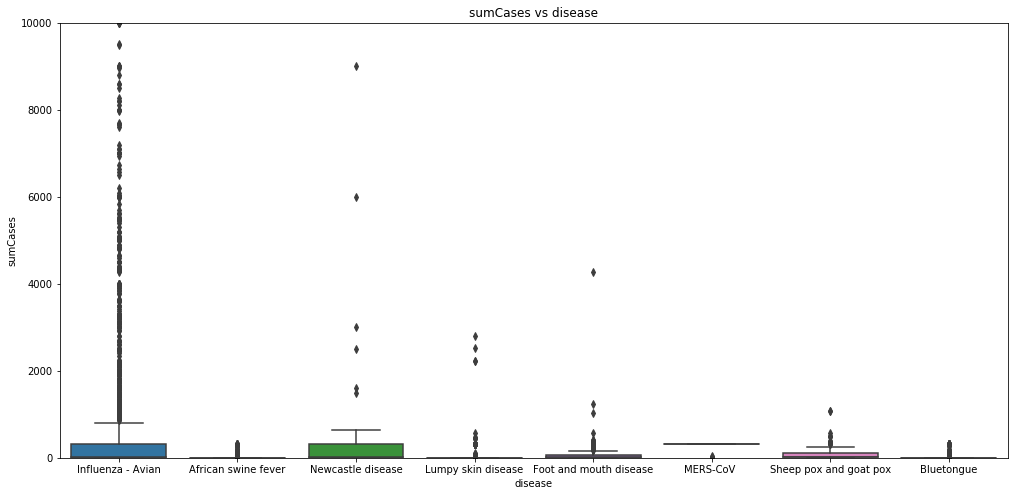

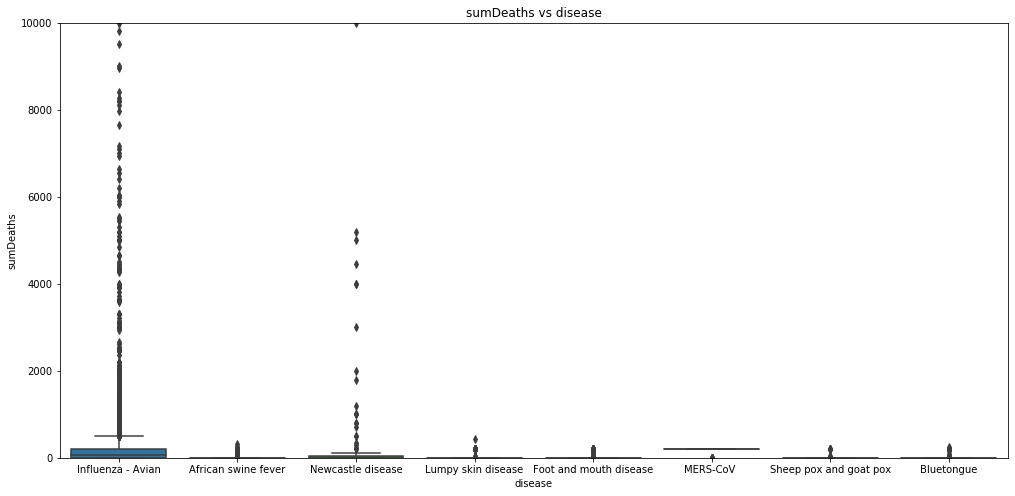

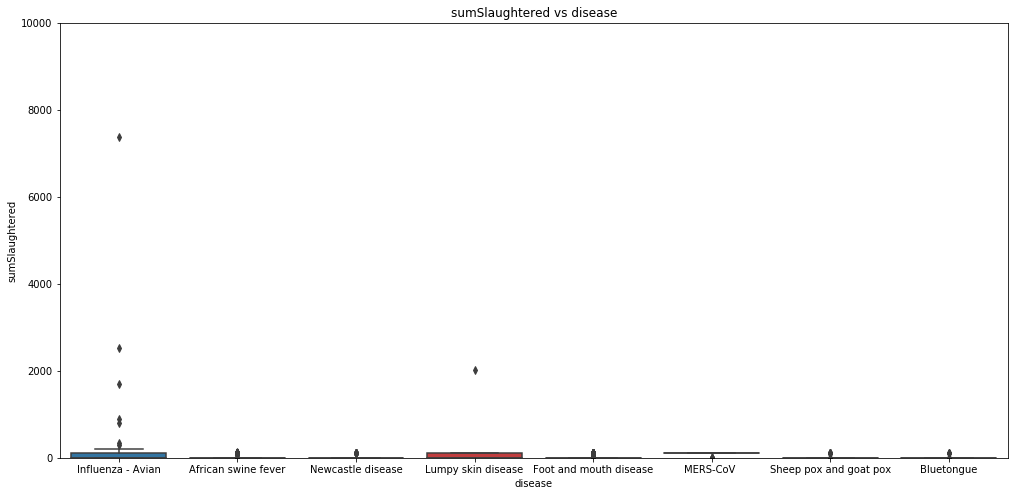

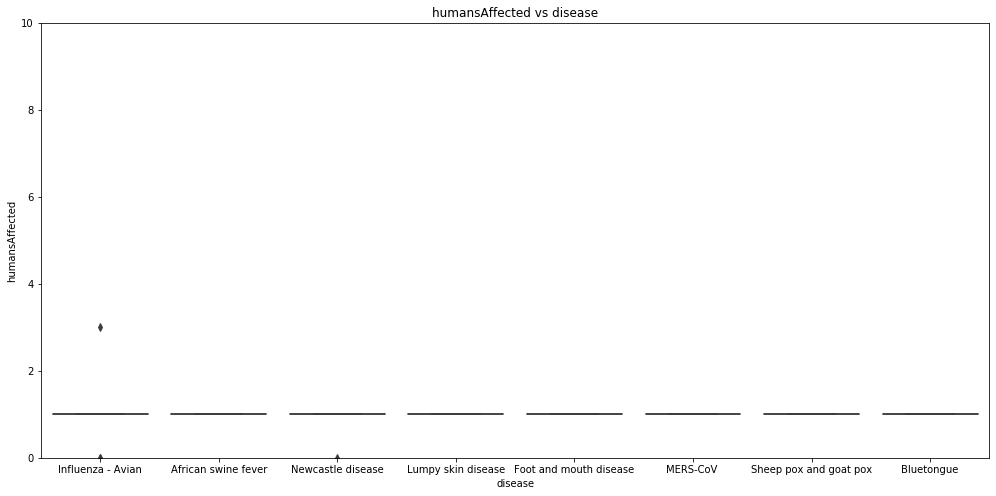

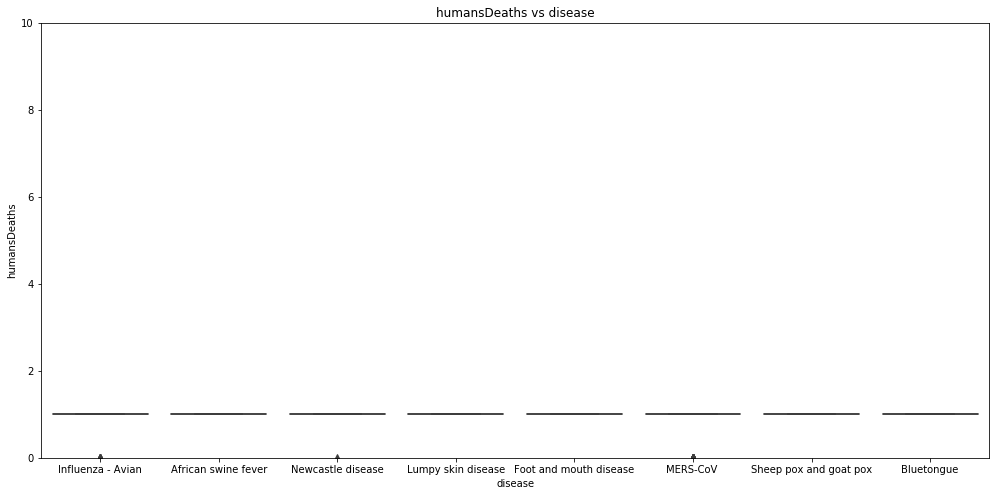

In [208]:
top8_diseases.head()

plt.figure(figsize=(17,8))
box = sns.boxplot(y='sumCases', x='disease', data=top8_diseases)
plt.title('sumCases vs disease')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(17,8))
box = sns.boxplot(y='sumDeaths', x='disease', data=top8_diseases)
plt.title('sumDeaths vs disease')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(17,8))
box = sns.boxplot(y='sumSlaughtered', x='disease', data=top8_diseases)
plt.title('sumSlaughtered vs disease')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(17,8))
box = sns.boxplot(y='humansAffected', x='disease', data=top8_diseases)
plt.title('humansAffected vs disease')
box.set_ylim(0, 10)
plt.show()

plt.figure(figsize=(17,8))
box = sns.boxplot(y='humansDeaths', x='disease', data=top8_diseases)
plt.title('humansDeaths vs disease')
box.set_ylim(0, 10)
plt.show()

In [82]:
outbreaks.describe()

Id      latitude     longitude      sumAtRisk  \
count   12702.000000  12702.000000  12702.000000   12702.000000   
mean   219090.579672     39.723446     37.122082    7867.402646   
std      7015.592808     15.392381     41.428791   32705.191826   
min    206339.000000    -36.856210   -122.291667       0.000000   
25%    212653.500000     32.907304     11.162645      56.000000   
50%    220295.500000     43.800556     23.839670    3600.000000   
75%    224967.750000     47.180122     41.739430    7500.691709   
max    230399.000000     67.910000    144.847374  898100.000000   

            sumCases      sumDeaths   sumDestroyed  sumSlaughtered  \
count   12702.000000   12702.000000   12702.000000    12702.000000   
mean      362.049083     199.141224    4190.855690      119.949860   
std      6129.361334    4173.693230   26993.812212     4251.819240   
min         0.000000       0.000000       0.000000        0.000000   
25%         1.000000       0.000000       0.000000        0.000000   
50%         2.000000       1.000000       0.000000        0.000000   
75%        30.000000      60.000000    3765.857978      100.211443   
max    460000.000000  439799.000000  898080.000000   339006.000000   

          humansAge  humansAffected  humansDeaths  differenceInDays  \
count  12702.000000    12702.000000  12702.000000      12702.000000   
mean      17.655065        1.001968      0.997323         83.734845   
std        6.853278        0.207138      0.053172        171.907971   
min        0.000000        0.000000      0.000000          1.000000   
25%       17.701311        1.000000      1.000000          8.000000   
50%       17.701311        1.000000      1.000000         34.000000   
75%       17.701311        1.000000      1.000000        124.000000   
max       93.000000       24.000000      2.000000       7094.000000   

       observationYear  observationMonth  observationDay  \
count     12702.000000      12702.000000    12702.000000   
mean       2016.097308          6.247914       16.359392   
std           0.784953          3.804182        7.908163   
min        1996.000000          1.000000        1.000000   
25%        2016.000000          3.000000       11.000000   
50%        2016.000000          6.000000       16.000000   
75%        2017.000000         10.000000       23.000000   
max        2017.000000         12.000000       31.000000   

       observationFirstHalfMonth  observationSecondHalfMonth            EC  \
count               12702.000000                12702.000000  12702.000000   
mean                    0.481735                    0.518265      0.006219   
std                     0.499686                    0.499686      0.078621   
min                     0.000000                    0.000000      0.000000   
25%                     0.000000                    0.000000      0.000000   
50%                     0.000000                    1.000000      0.000000   
75%                     1.000000                    1.000000      0.000000   
max                     1.000000                    1.000000      1.000000   

       FAO Field Officer   FAO officer    FAO-Report  \
count       12702.000000  12702.000000  12702.000000   
mean            0.003464      0.000236      0.000394   
std             0.058756      0.015367      0.019837   
min             0.000000      0.000000      0.000000   
25%             0.000000      0.000000      0.000000   
50%             0.000000      0.000000      0.000000   
75%             0.000000      0.000000      0.000000   
max             1.000000      1.000000      1.000000   

       International reference laboratory  \
count                        12702.000000   
mean                             0.000787   
std                              0.028049   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              0.000000   
max                              1

# Visualizations

## Timing

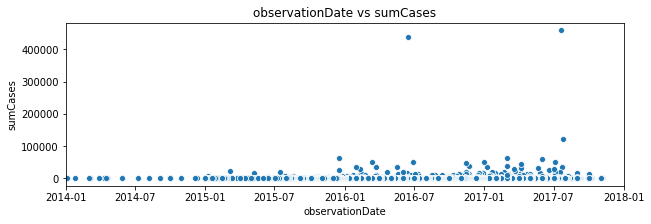

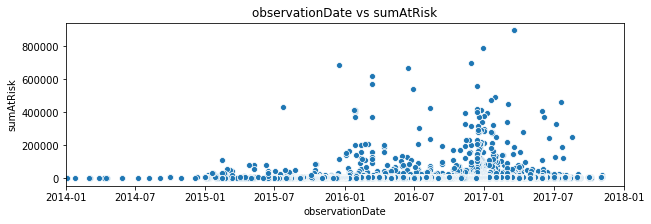

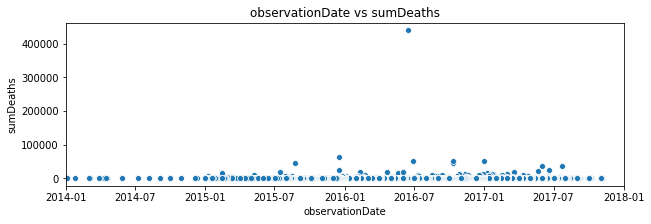

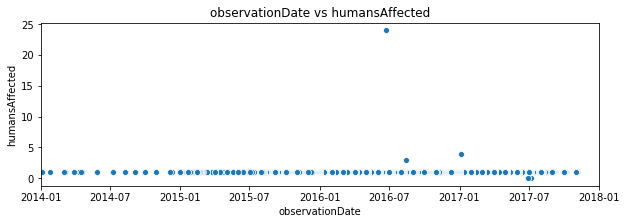

In [83]:
plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['sumCases'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumCases')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['sumAtRisk'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumAtRisk')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['sumDeaths'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumDeaths')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['humansAffected'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs humansAffected')
plt.show()

## Discrepancy Between Observation and Reporting Dates

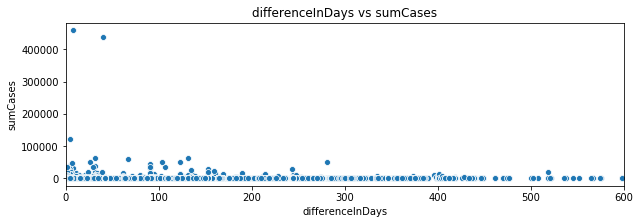

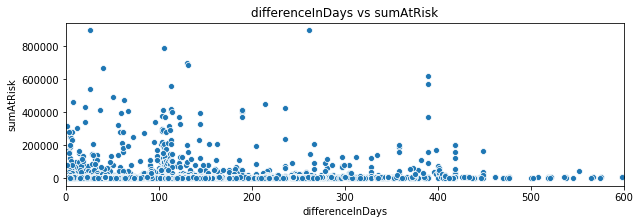

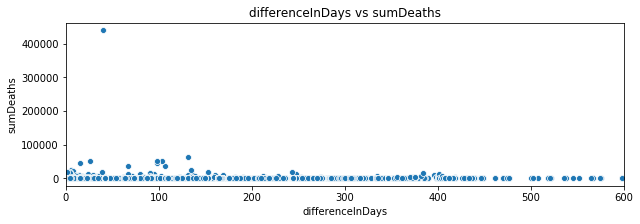

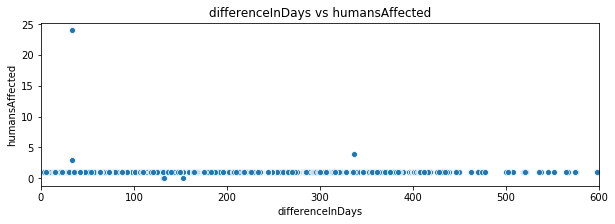

In [84]:
plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumCases'])
plt.title('differenceInDays vs sumCases')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumAtRisk'])
plt.title('differenceInDays vs sumAtRisk')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumDeaths'])
plt.title('differenceInDays vs sumDeaths')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['humansAffected'])
plt.title('differenceInDays vs humansAffected')
scatterplot.set_xlim(0, 600)
plt.show()

## Regions

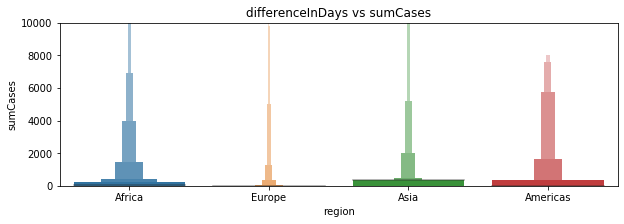

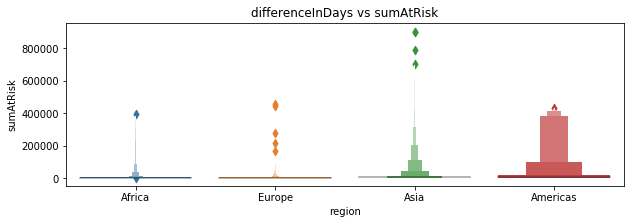

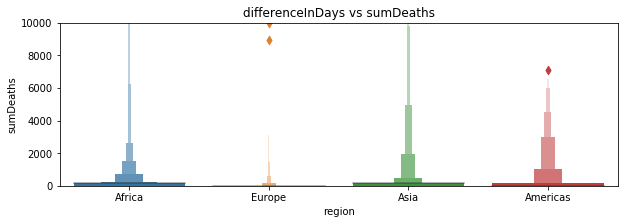

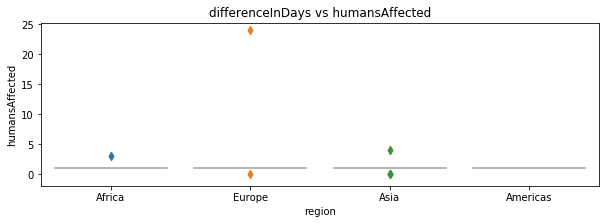

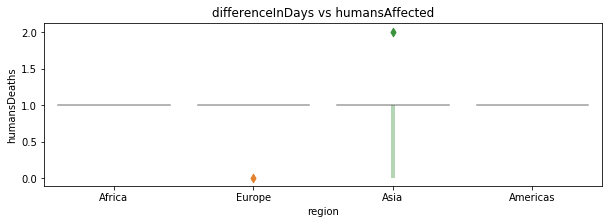

In [33]:
plt.figure(figsize=(10,3))
box = boxenplot = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumCases'])
plt.title('differenceInDays vs sumCases')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
boxenplot = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumAtRisk'])
plt.title('differenceInDays vs sumAtRisk')
# boxenplot.set_ylim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['region'], y=outbreaks['sumDeaths'])
plt.title('differenceInDays vs sumDeaths')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['region'], y=outbreaks['humansAffected'])
plt.title('differenceInDays vs humansAffected')
# box.set_ylim(0, 10)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['region'], y=outbreaks['humansDeaths'])
plt.title('differenceInDays vs humansAffected')
# box.set_ylim(0, 10)
plt.show()

## Human Deaths

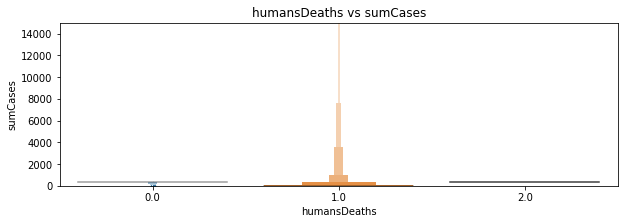

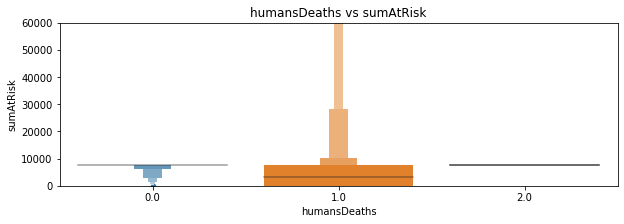

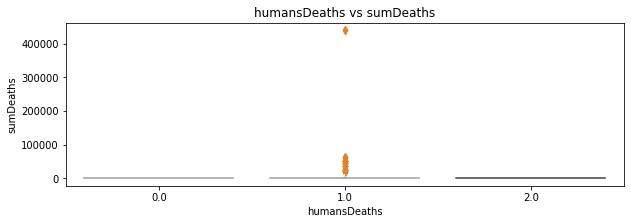

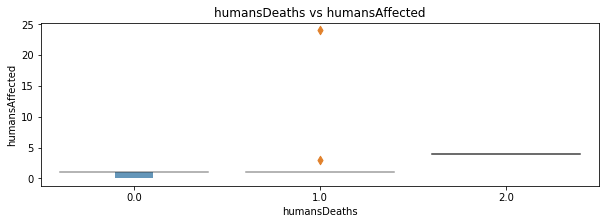

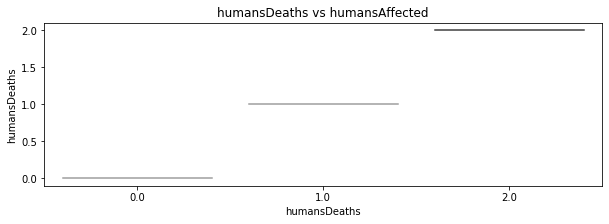

In [20]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['humansDeaths'], y=outbreaks['sumCases'])
plt.title('humansDeaths vs sumCases')
box.set_ylim(0, 15000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['humansDeaths'], y=outbreaks['sumAtRisk'])
plt.title('humansDeaths vs sumAtRisk')
box.set_ylim(0, 60000)
plt.show()

plt.figure(figsize=(10,3))
bpx = sns.boxenplot(x=outbreaks['humansDeaths'], y=outbreaks['sumDeaths'])
plt.title('humansDeaths vs sumDeaths')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['humansDeaths'], y=outbreaks['humansAffected'])
plt.title('humansDeaths vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['humansDeaths'], y=outbreaks['humansDeaths'])
plt.title('humansDeaths vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

In [21]:
outbreaks.corr().round(4)

# Mexico : H7N3 HPAI

#Saudi Arabia : MERS-CoV

# Influenza - Avian : birds

# Brazil : Glanders

# Chile : H7N6 LPAI

# China : H7N9 LPAI

# Influenza - Equine : H3N8

Id  latitude  longitude  sumAtRisk  sumCases  sumDeaths  \
Id           1.0000   -0.0240     0.1552     0.0690    0.0166    -0.0056   
latitude    -0.0240    1.0000    -0.2508    -0.0569   -0.0220    -0.0353   
longitude    0.1552   -0.2508     1.0000     0.1507    0.0119     0.0262   
sumAtRisk    0.0690   -0.0569     0.1507     1.0000    0.2885     0.2729   
sumCases     0.0166   -0.0220     0.0119     0.2885    1.0000     0.6737   
...             ...       ...        ...        ...       ...        ...   
domestic     0.1251   -0.2049    -0.1800    -0.0074    0.0290     0.0219   
captive      0.0001   -0.0235    -0.0203    -0.0069   -0.0019    -0.0016   
unspecified  0.0764   -0.1140     0.0131     0.0874    0.0415     0.0585   
birds        0.1816   -0.2174     0.1862     0.2017    0.0705     0.0568   
mammals     -0.2560    0.3870    -0.1122    -0.0594   -0.0338    -0.0276   

             sumDestroyed  sumSlaughtered  humansAge  humansAffected  \
Id                 0.1015          0.0116     0.0144         -0.0053   
latitude          -0.0533         -0.0414    -0.0596          0.0117   
longitude          0.1996         -0.0138     0.0731          0.0075   
sumAtRisk          0.8331          0.1273    -0.0153          0.0001   
sumCases           0.1271          0.0059    -0.0138         -0.0000   
...                   ...             ...        ...             ...   
domestic           0.0716          0.0080    -0.1375         -0.0161   
captive           -0.0049         -0.0008    -0.0465         -0.0004   
unspecified        0.0211          0.0038    -0.0898         -0.0027   
birds              0.1666          0.0323    -0.1335         -0.0090   
mammals           -0.0874         -0.0159    -0.0449         -0.0057   

             humansDeaths  differenceInDays  observationYear  \
Id                 0.0469           -0.0221           0.6878   
latitude           0.0459           -0.0677           0.0097   
longitude         -0.0306            0.0666           0.0656   
sumAtRisk          0.0012            0.0343           0.0261   
sumCases           0.0004           -0.0041           0.0224   
...                   ...               ...              ...   
domestic           0.0631            0.0188          -0.0149   
captive            0.0022           -0.0017           0.0085   
unspecified        0.0142           -0.0193           0.1161   
birds              0.0254            0.0026           0.1649   
mammals            0.0302            0.0510          -0.1914   

             observationMonth  observationDay  observationFirstHalfMonth  \
Id                    -0.0741          0.0069                    -0.0358   
latitude               0.0599         -0.0274                     0.0190   
longitude             -0.0184          0.0795                    -0.0462   
sumAtRisk              0.0026          0.0179                    -0.0109   
sumCases              -0.0062         -0.0010                    -0.0026   
...                       ...             ...                        ...   
domestic               0.1094          0.0186                     0.0096   
captive               -0.0014         -0.0254                     0.0088   
unspecified           -0.0709         -0.0184                    -0.0120   
birds                 -0.0648          0.0330                    -0.0338   
mammals                0.0212         -0.0499                     0.0378   

             observationSecondHalfMonth      EC  FAO Field Officer  \
Id                               0.0358 -0.0350            -0.0292   
latitude                        -0.0190  0.0134            -0.1093   
longitude                        0.0462 -0.0249             0.0011   
sumAtRisk                        0.0109 -0.0124            -0.0035   
sumCases                         0.0026  0.0378             0.0041   
...                                 ...     ...                ...   
domestic                        -0.0096  0.0527             0.0209 

In [22]:
features_to_test = outbreaks[['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge',
                             'humansAffected', 'humansDeaths', 'differenceInDays']]
for feat in features_to_test:
    jb_stats = stats.jarque_bera(outbreaks[feat])
    norm_stats = stats.normaltest(outbreaks[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))


Testing for normality on sumAtRisk:
Jarque-Bera test statistics for sumAtRisk is 31000614.79592809 and p value is 0.0
Normality test statistics for sumAtRisk is 23142.035622884763 and p value is 0.0

Testing for normality on sumCases:
Jarque-Bera test statistics for sumCases is 11137004109.799223 and p value is 0.0
Normality test statistics for sumCases is 43488.628730504606 and p value is 0.0

Testing for normality on sumDeaths:
Jarque-Bera test statistics for sumDeaths is 49823527573.628174 and p value is 0.0
Normality test statistics for sumDeaths is 49389.573754484634 and p value is 0.0

Testing for normality on sumDestroyed:
Jarque-Bera test statistics for sumDestroyed is 91313545.70287018 and p value is 0.0
Normality test statistics for sumDestroyed is 26247.14098262732 and p value is 0.0

Testing for normality on sumSlaughtered:
Jarque-Bera test statistics for sumSlaughtered is 8674319210.08637 and p value is 0.0
Normality test statistics for sumSlaughtered is 42615.69380389212 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for sumAtRisk feature. 







'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really wa



No boxcox transformation for sumAtRisk because not all data is positive.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for sumCases feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No boxcox transformation for sumCases because not all data is positive.

 Outlier Visualization for sumDeaths feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.






No boxcox transformation for sumDeaths because not all data is positive.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for sumDestroyed feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No boxcox transformation for sumDestroyed because not all data is positive.

 Outlier Visualization for sumSlaughtered feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.






No boxcox transformation for sumSlaughtered because not all data is positive.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for humansAge feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No boxcox transformation for humansAge because not all data is positive.

 Outlier Visualization for humansAffected feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.








No boxcox transformation for humansAffected because not all data is positive.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for humansDeaths feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No boxcox transformation for humansDeaths because not all data is positive.

 Outlier Visualization for differenceInDays feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<Figure size 432x288 with 0 Axes>

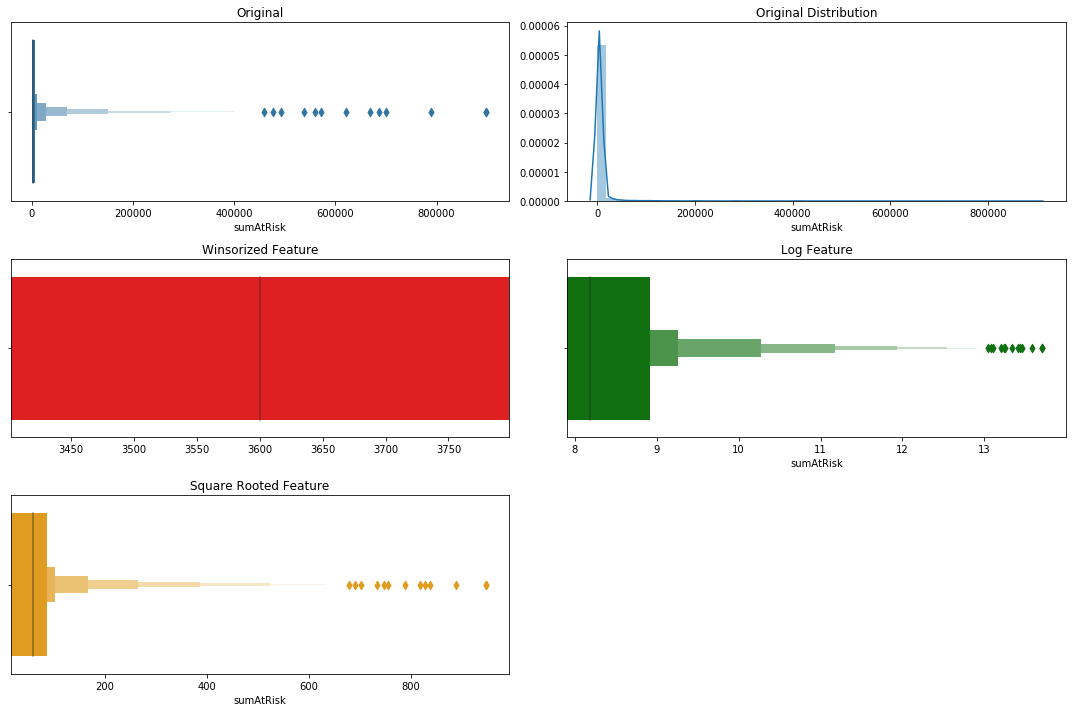

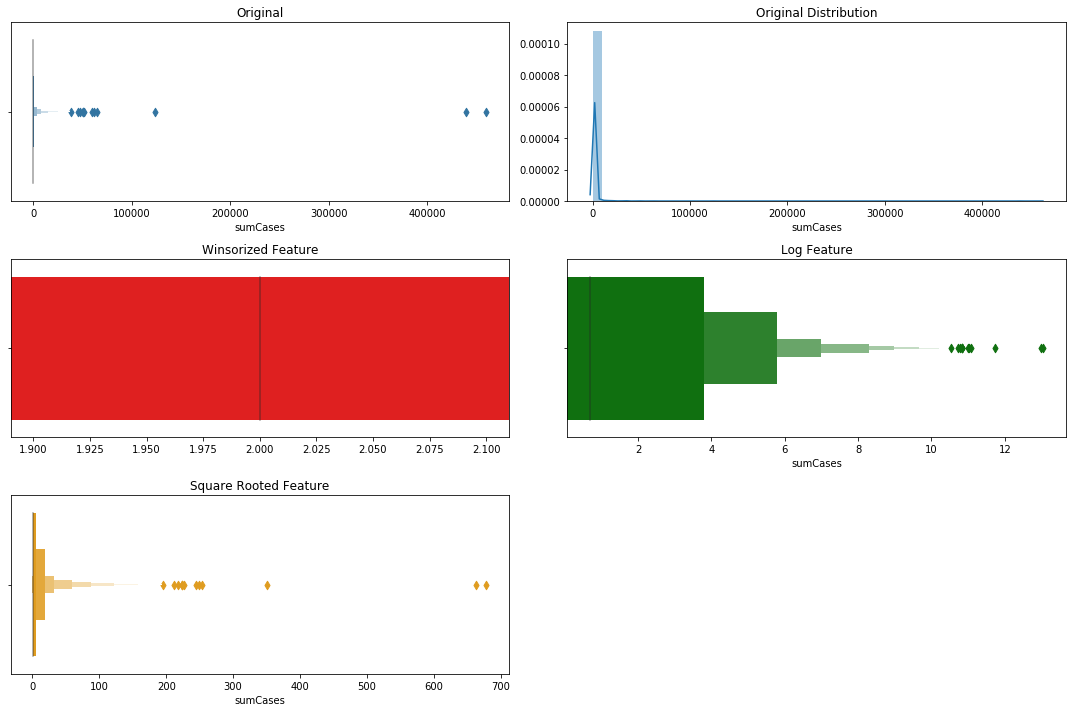

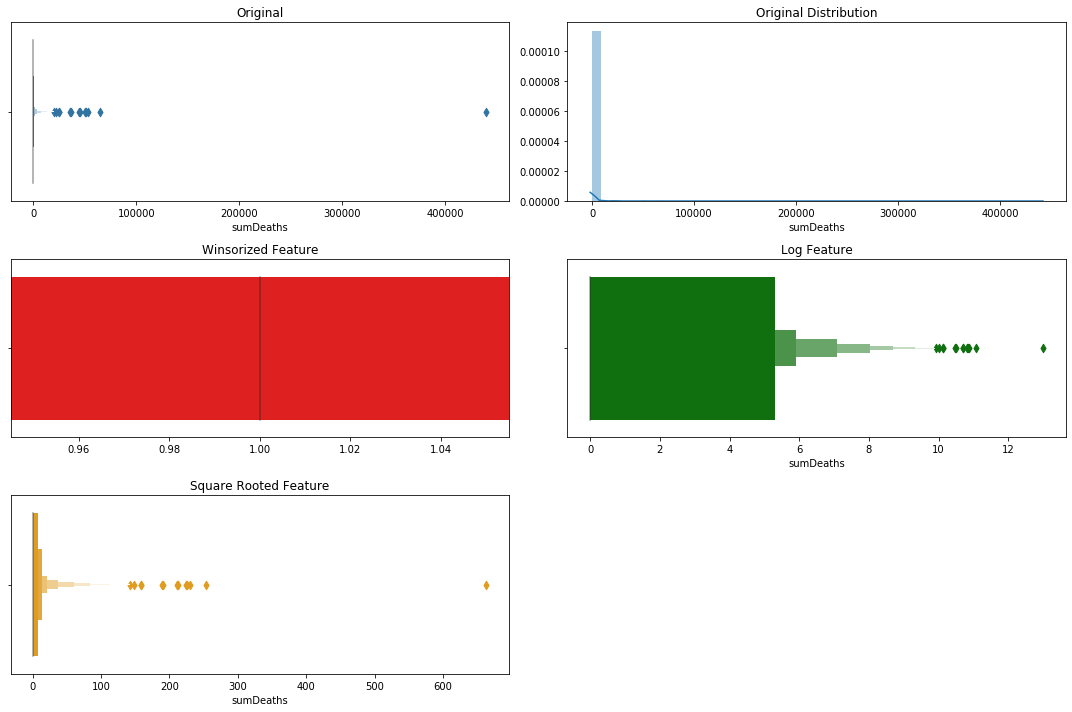

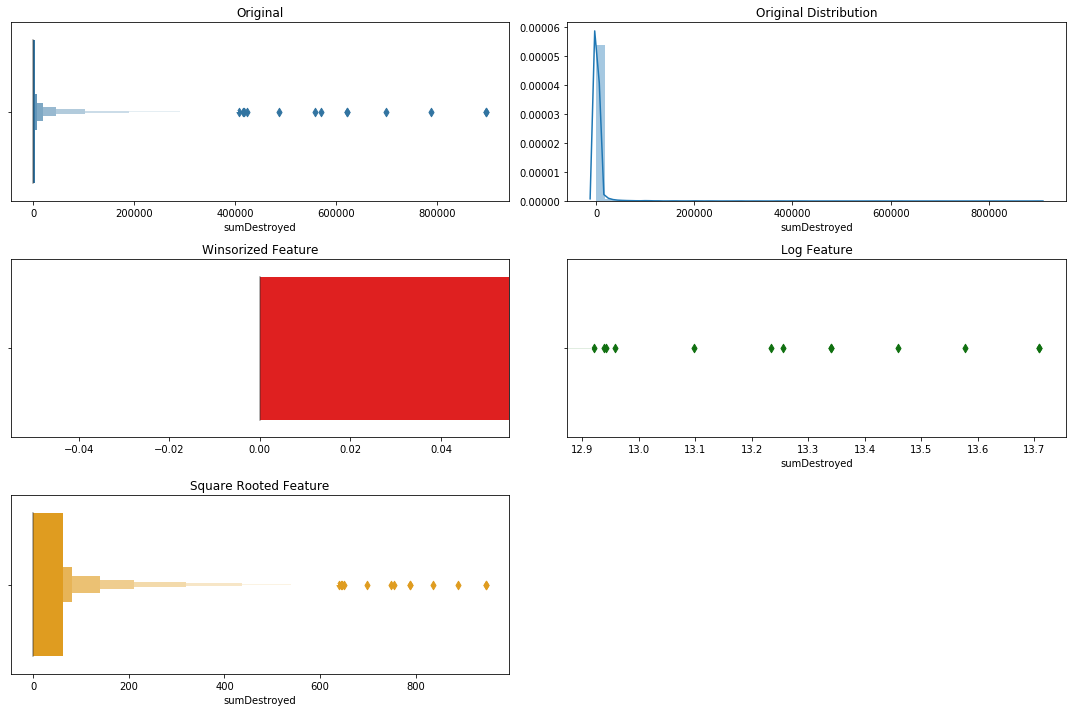

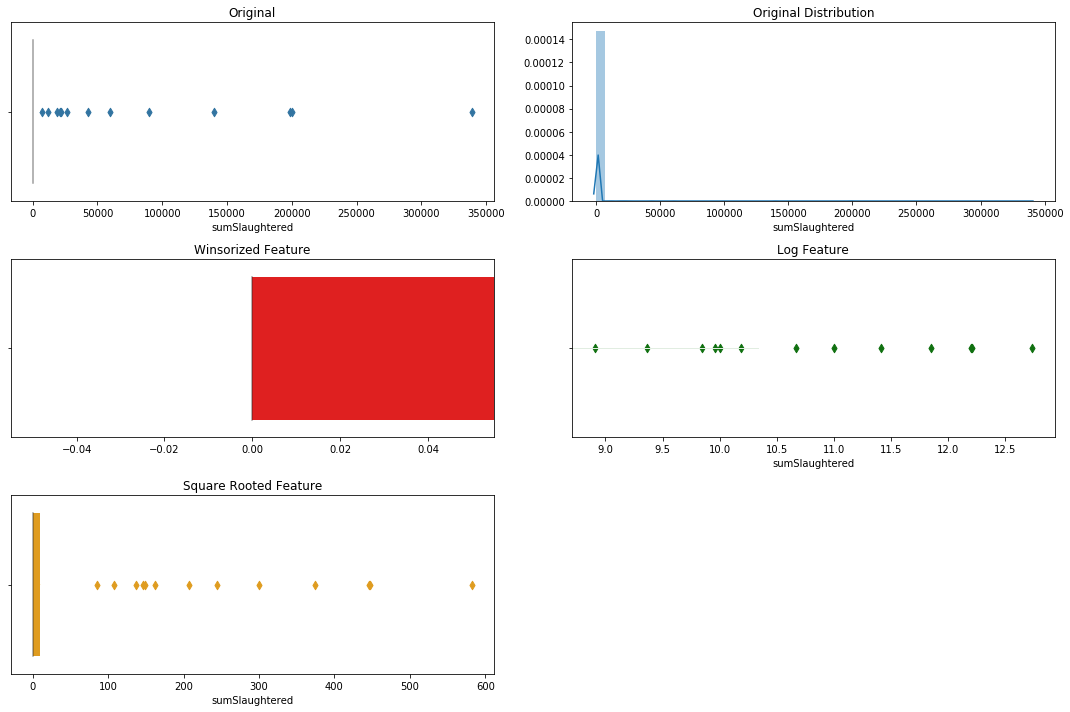

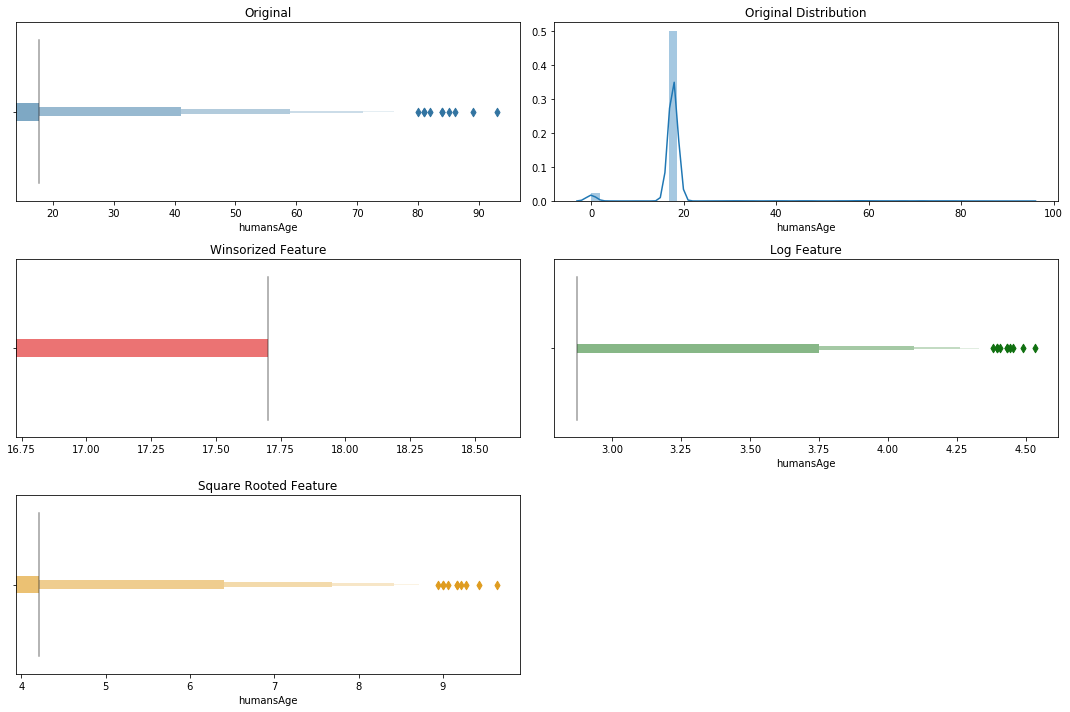

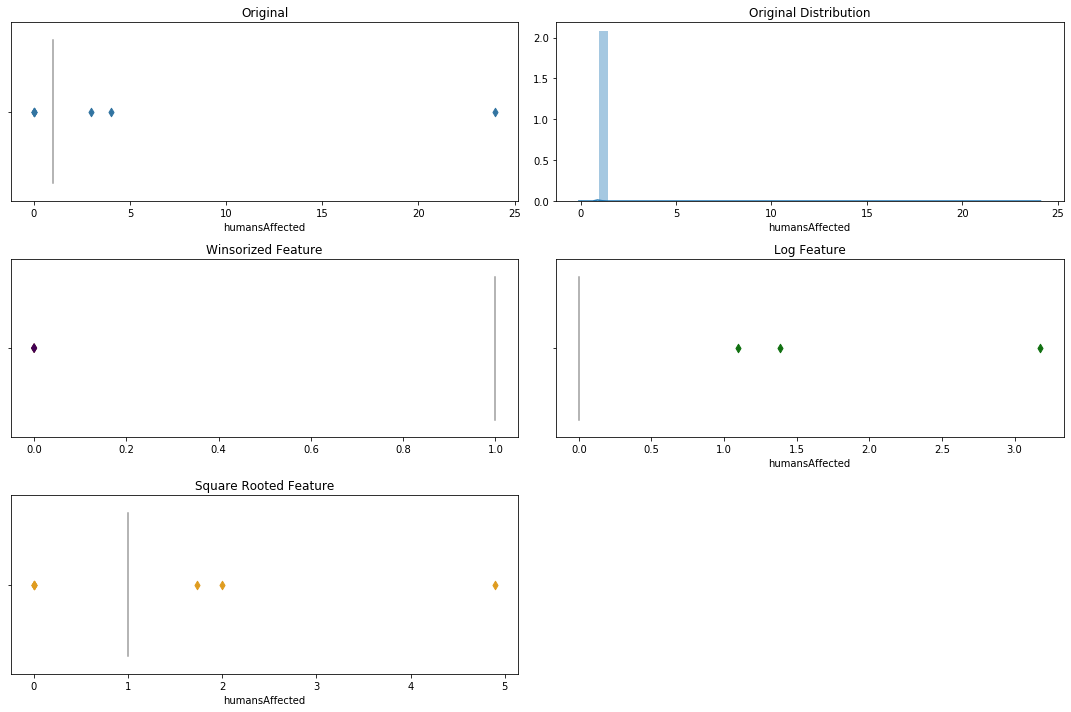

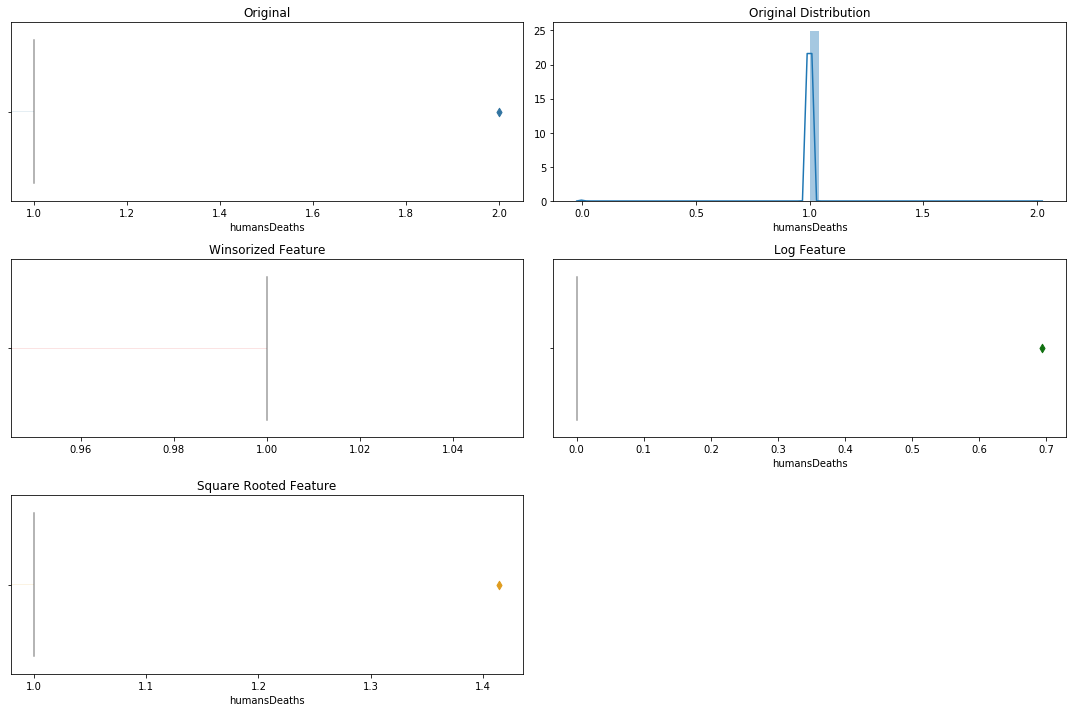

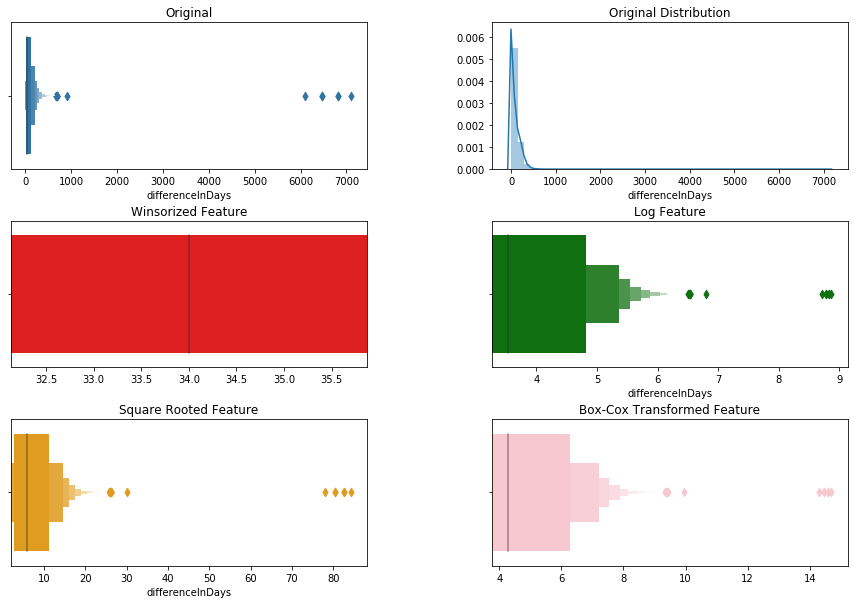

In [23]:
# Specify a list with features we want to test for normality. 
# Visuals for outliers and normality

for feat in features_to_test:
    winsorized_feature = winsorize(outbreaks[feat], (0, 0.10))
    sqrt_feature = np.sqrt(outbreaks[feat])
    
    plt.tight_layout()
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=outbreaks)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(outbreaks[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    winsorized_feature = winsorize(outbreaks[feat], (0, 0.10))
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    try:
        log_feature = np.log(outbreaks[feat])
        plt.subplot(3, 2, 4)
        log_feature = np.log(outbreaks[feat])
        sns.boxenplot(log_feature, color='green')
        plt.title('Log Feature')
    except ValueError: 
        print('No log transformation for', feat, 'because not all data is positive.')
    print('\n')
    plt.subplot(3, 2, 5)
    sqrt_feature = np.sqrt(outbreaks[feat])
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    try:
        bc_feature,_ = stats.boxcox(outbreaks[feat])
        plt.subplot(3, 2, 6)
        sns.boxenplot(bc_feature, color='pink')
        plt.title('Box-Cox Transformed Feature')
        plt.subplots_adjust(hspace=0.35, wspace=0.35)
        plt.show()
    except ValueError: 
        print('No boxcox transformation for', feat, 'because not all data is positive.')

## Checking Outliers
differenceInDays: many outbreaks were reported when this data was being gathered, on September 18 of 2015. (sr)
sumAtRisk: square root
sumCases: square root
sumDeaths: log/sr
sumDestroyed: log
sumSlaughtered: log
humansAge: sr
humansAffected: sr
humansDeaths: sr


In [209]:
outbreaks['norm_differenceInDays'] = normalize(np.array(np.log(outbreaks['differenceInDays'])).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_sumAtRisk'] = normalize(np.array(np.sqrt(outbreaks['sumAtRisk'])).reshape(-1, 1))
outbreaks['norm_sumCases'] = normalize(np.array(np.sqrt(outbreaks['sumCases'])).reshape(1,-1).reshape(-1,1))
outbreaks['norm_sumDeaths'] = normalize(np.array(np.sqrt(outbreaks['sumDeaths'])).reshape(1,-1).reshape(-1,1))
outbreaks['norm_sumDestroyed'] = normalize(np.array(np.log(outbreaks['sumDestroyed'] + 1)).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_sumSlaughtered'] = normalize(np.array(np.log(outbreaks['sumSlaughtered'] + 1)).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_humansAge'] = normalize(np.array(np.sqrt(outbreaks['humansAge'])).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_humansAffected'] = normalize(np.array(np.sqrt(outbreaks['humansAffected'])).reshape(1,-1)).reshape(-1,1)
outbreaks['norm_humansDeaths'] = normalize(np.array(np.sqrt(outbreaks['humansDeaths'])).reshape(1,-1)).reshape(-1,1)

norm_features_to_test = ['norm_differenceInDays', 'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDestroyed', 
                         'norm_sumSlaughtered', 'norm_humansAge', 'norm_humansAffected', 'norm_humansDeaths']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in norm_features_to_test:
    jb_stats = stats.jarque_bera(outbreaks[feat])
    norm_stats = stats.normaltest(outbreaks[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_differenceInDays:
Jarque-Bera test statistics for norm_differenceInDays is 613.9940887824272 and p value is 0.0
Normality test statistics for norm_differenceInDays is 1760.3923896373988 and p value is 0.0

Testing for normality on norm_sumAtRisk:
Jarque-Bera test statistics for norm_sumAtRisk is 2046676.5838905706 and p value is 0.0
Normality test statistics for norm_sumAtRisk is 16853.327562212307 and p value is 0.0

Testing for normality on norm_sumCases:
Jarque-Bera test statistics for norm_sumCases is 93002.3029832742 and p value is 0.0
Normality test statistics for norm_sumCases is 9160.86293459418 and p value is 0.0

Testing for normality on norm_sumDestroyed:
Jarque-Bera test statistics for norm_sumDestroyed is 1823.6498306850474 and p value is 0.0
Normality test statistics for norm_sumDestroyed is 100714.73793381744 and p value is 0.0

Testing for normality on norm_sumSlaughtered:
Jarque-Bera test statistics for norm_sumSlaughtered is 2769.21266793

In [210]:
corr_mat = outbreaks.corr().loc[:, ['norm_humansDeaths']].abs().sort_values(by='norm_humansDeaths', ascending=False)
corr_mat[:20]

norm_humansDeaths
norm_humansDeaths              1.000000
humansDeaths                   0.995235
MERS-CoV                       0.175741
Saudi Arabia                   0.169479
H5N8 HPAI, H5N2 HPAI           0.168391
norm_humansAffected            0.130030
Portugal                       0.118750
WHO                            0.111296
Centroid Admin1                0.096415
Asia                           0.085707
norm_sumSlaughtered            0.084846
OIE                            0.084352
Other                          0.083516
National authorities           0.075009
Europe                         0.068024
norm_sumDestroyed              0.065996
domestic                       0.065104
mammals                        0.059130
Jordan                         0.058414
latitude                       0.048604

In [216]:
corr_mat = outbreaks.corr().loc[:, ['norm_sumCases']].abs().sort_values(by='norm_sumCases', ascending=False)
corr_mat[:50]

norm_sumCases
norm_sumCases                    1.000000
norm_sumAtRisk                   0.481562
birds                            0.333581
H5N8 HPAI                        0.316726
Hungary                          0.309938
norm_sumDeaths                   0.291287
mammals                          0.290344
Influenza - Avian                0.290074
France                           0.206353
UknownSerotypes                  0.165704
unspecified                      0.146306
norm_sumSlaughtered              0.146153
H5N1 LPAI                        0.145786
Bluetongue                       0.136189
Newcastle disease                0.128541
wild                             0.127813
H5N2 HPAI                        0.125733
Israel                           0.124392
domestic                         0.121160
African swine fever              0.119808
Republic of Korea                0.116860
H5N9 HPAI                        0.113437
OIE                              0.110362
National authorities             0.104013
8                                0.103327
H5N3 LPAI                        0.102806
Id                               0.100181
H7N8 LPAI                        0.097351
Lumpy skin disease               0.093322
observationYear                  0.086668
Taiwan (Province of China)       0.082800
Exact                            0.079089
H5N9 LPAI                        0.076953
Africa                           0.074814
4                                0.072270
United States of America         0.067565
Centroid Admin2                  0.063820
Albania                          0.059542
Latvia                           0.055896
Serbia                           0.055587
Estonia                          0.055535
Centroid Admin1                  0.053234
MERS-CoV                         0.051819
Saudi Arabia                     0.051380
Russian Federation               0.050190
H5N1 HPAI                        0.048717
H5N2 LPAI                        0.048011
Lithuania                        0.046739
Egypt                            0.043536
China                            0.041500

# Visualizations with Dimensionality Reduction

## PCA

The best clustering seen with PCA is when 

In [212]:
# PCA with all variables, including norm_humansDeaths
X_all = outbreaks.drop(columns=['disease', 'serotypes', 'speciesDescription', 'sumAtRisk', 'sumCases', 'sumDeaths', 
                            'sumDestroyed','sumSlaughtered', 'humansAge', 'humansAffected', 'humansDeaths', 
                            'differenceInDays', 'source','region', 'country', 'localityQuality', 'status', 
                            'observationDate', 'reportingDate'])


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
print(pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_all)
print(pca_80.explained_variance_ratio_)


[9.99959479e-01 3.43963815e-05]
[0.99995948]


Cluster Graph with PCA 


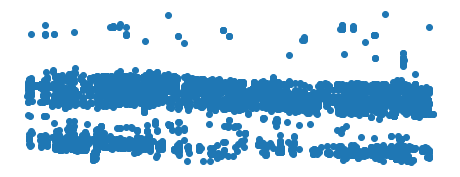

In [213]:
print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

First two PCA components:  [0.39140574 0.1735997 ]
PCA components for 80% of variance:  [0.39140574 0.1735997  0.11733417 0.09430421 0.07528756]
Cluster Graph with PCA 


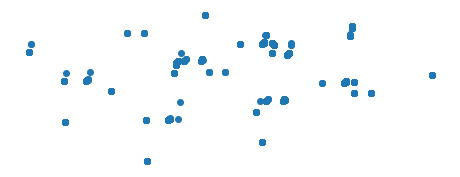

In [162]:
# PCA with floats, diseases, and regions
X_floats = outbreaks[['norm_sumAtRisk', 'norm_sumCases', 'norm_sumDeaths', 
                      'norm_sumDestroyed','norm_sumSlaughtered', 'norm_humansAge',
               'norm_humansAffected', 'norm_differenceInDays', 'norm_humansDeaths', 'Europe', 'Asia',
                      'Africa', 'Americas', 'Influenza - Avian', 'Bluetongue', 'African swine fever', 
                      'Lumpy skin disease', 'MERS-CoV ', 'Foot and mouth disease', 'Newcastle disease',
                      'Sheep pox and goat pox']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_floats)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_floats)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [160]:
outbreaks.disease.value_counts()

Influenza - Avian                                4847
Bluetongue                                       2820
African swine fever                              2255
Lumpy skin disease                               1527
MERS-CoV                                          493
Foot and mouth disease                            245
Newcastle disease                                 150
Sheep pox and goat pox                            112
Anthrax                                            49
Peste des petits ruminants                         44
Rift Valley fever                                  40
Rabies                                             26
West Nile Fever                                    17
Glanders                                           13
Equine infectious anaemia                          13
Porcine reproductive and respiratory syndrome       8
Classical swine fever                               7
African horse sickness                              7
Influenza - Equine          

First two PCA components:  [0.77778944 0.05276306]
PCA components for 80% of variance:  [0.77778944 0.05276306]
Cluster Graph with PCA 


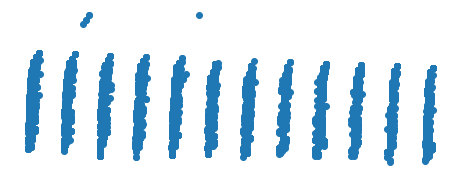

In [222]:
# PCA for features with greater than 0.01 absolute correlation with norm_humanDeaths

X_01hd = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI',  'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe',  'Jordan', 'Exact', 'Centroid Locality', 
                      'observationYear',  'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer',  'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea',
                     'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDeaths', 
                      'norm_sumDestroyed','norm_sumSlaughtered', 'norm_humansAge',
                   'norm_humansAffected', 'norm_differenceInDays', 'norm_humansDeaths']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01hd)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_01hd)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

First two PCA components:  [0.24028244 0.16766427]
PCA components for 80% of variance:  [0.24028244 0.16766427 0.12065176 0.10780556 0.06740447 0.03886172
 0.03694601 0.03092482]
Cluster Graph with PCA 


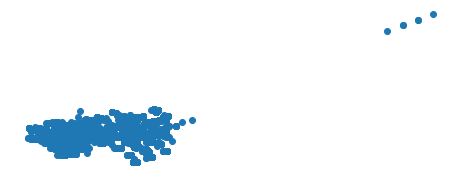

In [223]:
# PCA for features with greater than 0.01 absolute correlation with potential target

X_01sc = outbreaks[['birds', 'H5N8 HPAI', 'Hungary', 'mammals', 'Influenza - Avian', 'France', 'UknownSerotypes', 
                  'unspecified', 'H5N1 LPAI', 'Bluetongue', 'Newcastle disease', 'wild', 'H5N2 HPAI', 'Israel',
                  'domestic', 'African swine fever', 'Republic of Korea', 'H5N9 HPAI', 'OIE', 'National authorities',
                  '8', 'H5N3 LPAI', 'H7N8 LPAI', 'Lumpy skin disease', 'observationYear', 'Taiwan (Province of China)', 
                  'Exact', 'H5N9 LPAI', 'Africa', '4', 'United States of America', 'Centroid Admin2', 'Albania', 
                  'Latvia', 'Serbia', 'Estonia', 'Centroid Admin1', 'MERS-CoV ', 'Saudi Arabia', 'Russian Federation',
                  'norm_sumAtRisk', 'norm_sumCases', 'norm_sumDeaths', 
                      'norm_sumDestroyed','norm_sumSlaughtered', 'norm_humansAge',
                   'norm_humansAffected', 'norm_differenceInDays', 'norm_humansDeaths']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01sc)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_01sc)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## TSNE

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.257s...
[t-SNE] Computed neighbors for 12702 samples in 1.519s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

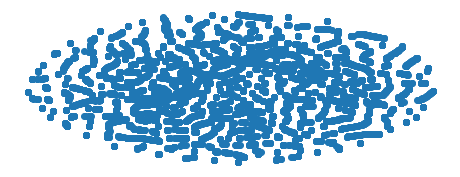

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.237s...
[t-SNE] Computed neighbors for 12702 samples in 1.543s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

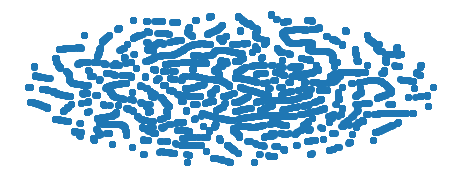

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.234s...
[t-SNE] Computed neighbors for 12702 samples in 1.515s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

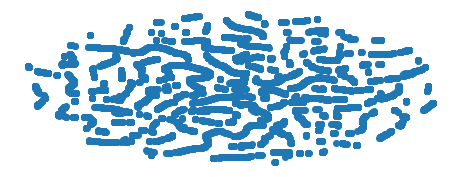

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.215s...
[t-SNE] Computed neighbors for 12702 samples in 1.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sa

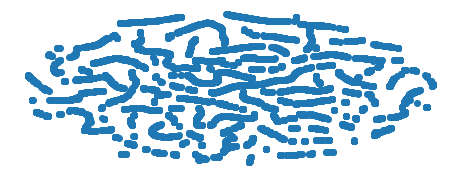

In [165]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_all)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.051s...
[t-SNE] Computed neighbors for 12702 samples in 0.374s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

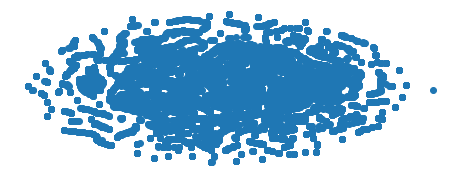

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.048s...
[t-SNE] Computed neighbors for 12702 samples in 0.467s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

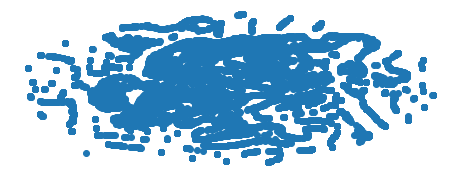

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.047s...
[t-SNE] Computed neighbors for 12702 samples in 0.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

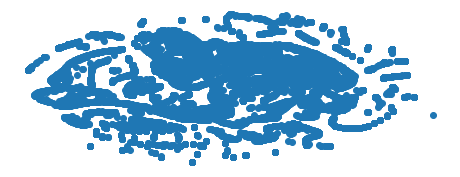

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.044s...
[t-SNE] Computed neighbors for 12702 samples in 0.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sa

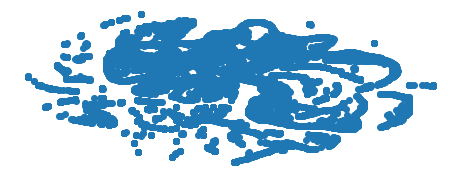

In [40]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_floats)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.077s...
[t-SNE] Computed neighbors for 12702 samples in 0.644s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

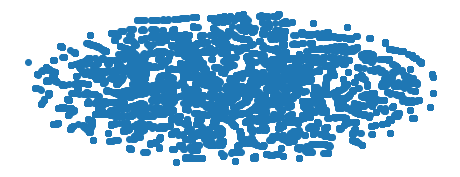

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.047s...
[t-SNE] Computed neighbors for 12702 samples in 0.868s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

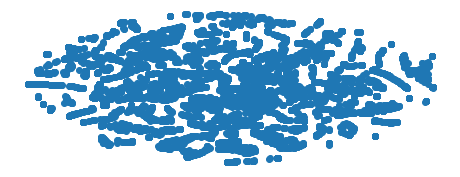

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.051s...
[t-SNE] Computed neighbors for 12702 samples in 1.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sam

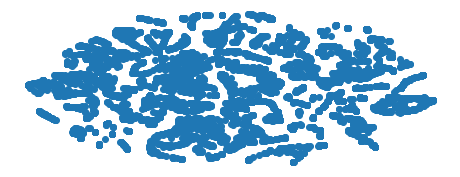

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12702 samples in 0.050s...
[t-SNE] Computed neighbors for 12702 samples in 1.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12702
[t-SNE] Computed conditional probabilities for sample 2000 / 12702
[t-SNE] Computed conditional probabilities for sample 3000 / 12702
[t-SNE] Computed conditional probabilities for sample 4000 / 12702
[t-SNE] Computed conditional probabilities for sample 5000 / 12702
[t-SNE] Computed conditional probabilities for sample 6000 / 12702
[t-SNE] Computed conditional probabilities for sample 7000 / 12702
[t-SNE] Computed conditional probabilities for sample 8000 / 12702
[t-SNE] Computed conditional probabilities for sample 9000 / 12702
[t-SNE] Computed conditional probabilities for sample 10000 / 12702
[t-SNE] Computed conditional probabilities for sample 11000 / 12702
[t-SNE] Computed conditional probabilities for sample 12000 / 12702
[t-SNE] Computed conditional probabilities for sa

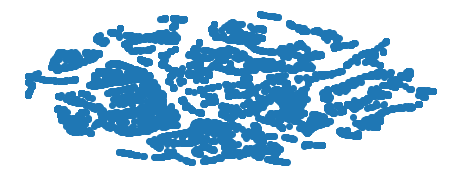

In [120]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_01)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

## UMAP

## UMAP

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py:719: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.01 minimum distance.


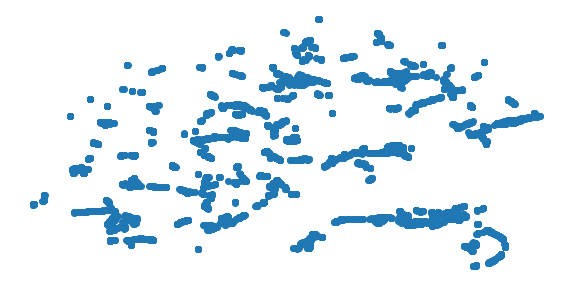

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py:719: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.1 minimum distance.


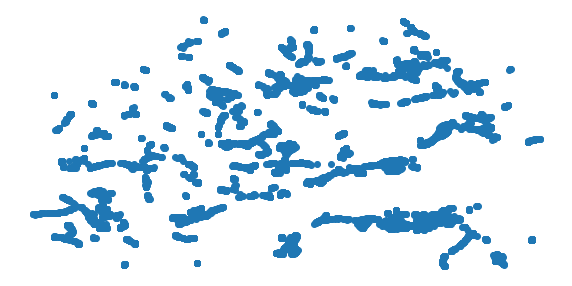

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py:719: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.5 minimum distance.


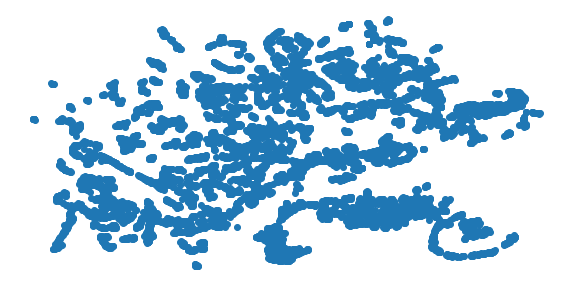

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py:719: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.75 minimum distance.


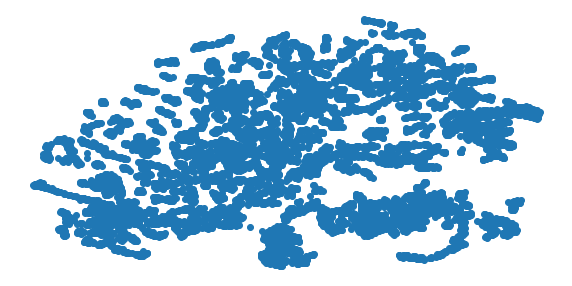

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py:719: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  1 minimum distance.


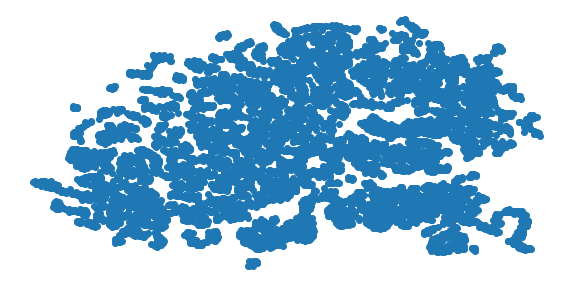

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.01 minimum distance.


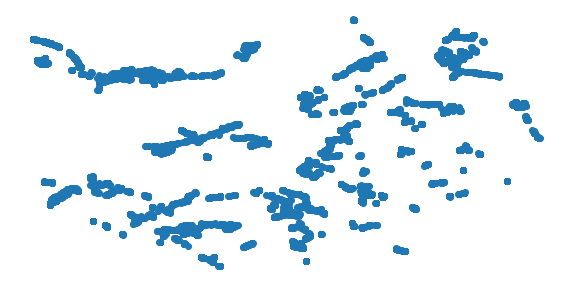

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.1 minimum distance.


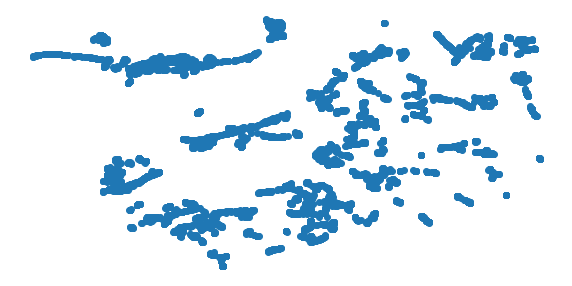

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.5 minimum distance.


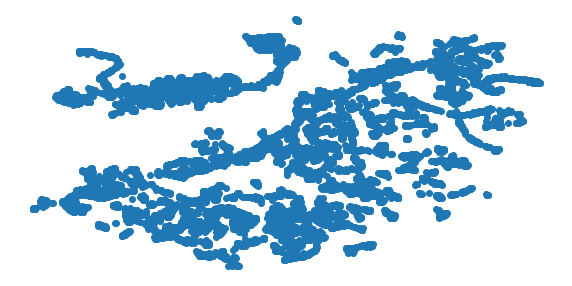

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.75 minimum distance.


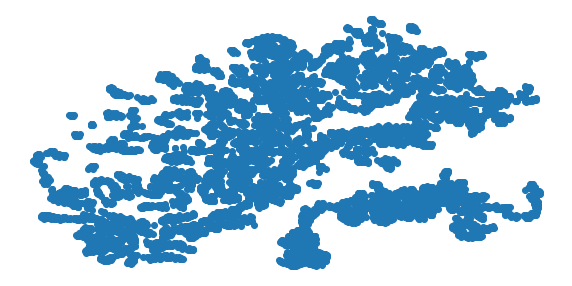

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  1 minimum distance.


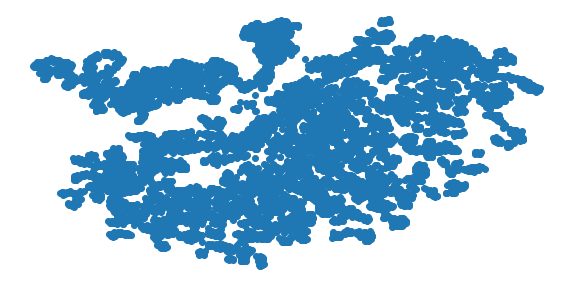

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.01 minimum distance.


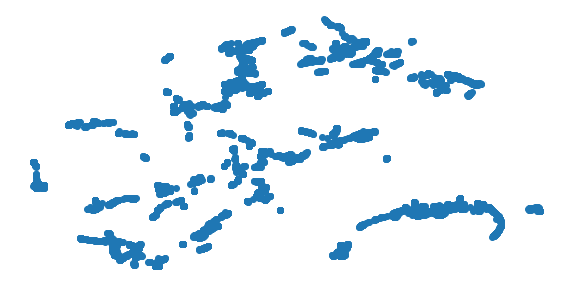

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.1 minimum distance.


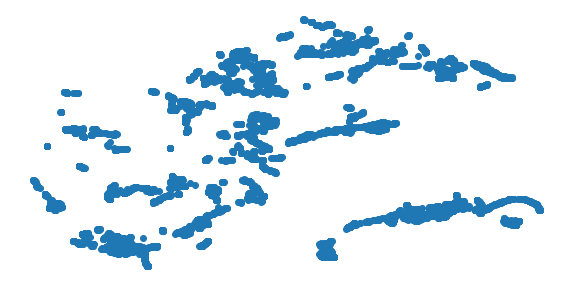

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.5 minimum distance.


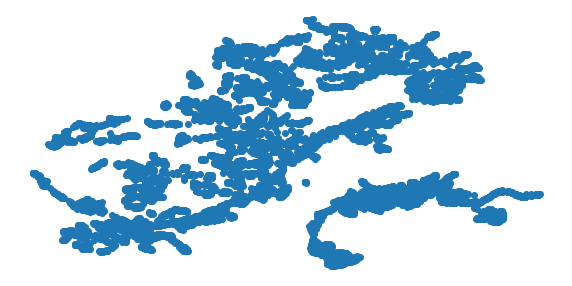

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.75 minimum distance.


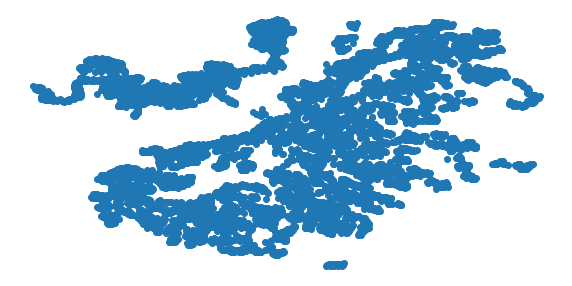

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  1 minimum distance.


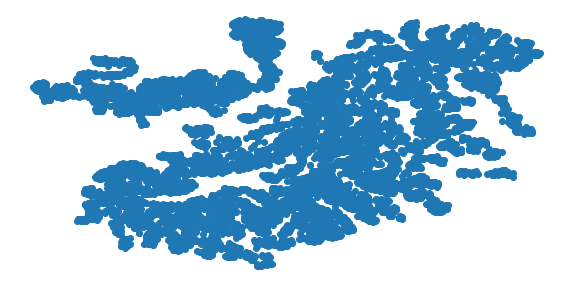

In [224]:
# UMAP with all features
print('UMAP with all features. \n')
for n_neighbors in [50, 100, 250]:
    for min_dist in [ 0.01, 0.1, 0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_all)
        print('UMAP for X_all with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

UMAP with features highly correlated with norm_humansDeaths. 



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 47 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  50 neighbors and  0.01 minimum distance.


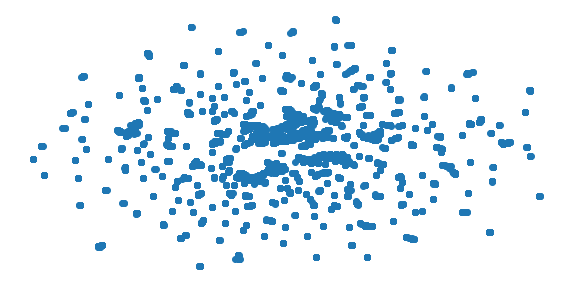

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 45 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  50 neighbors and  0.1 minimum distance.


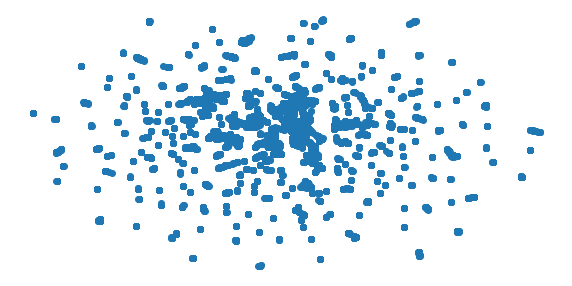

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 45 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  50 neighbors and  0.5 minimum distance.


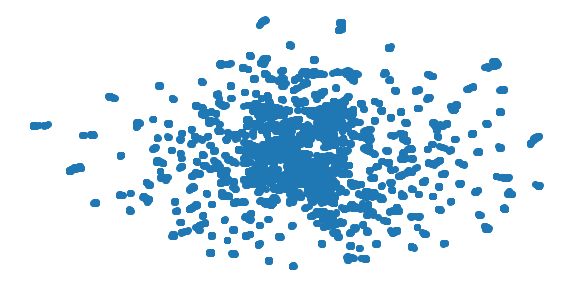

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 48 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  50 neighbors and  0.75 minimum distance.


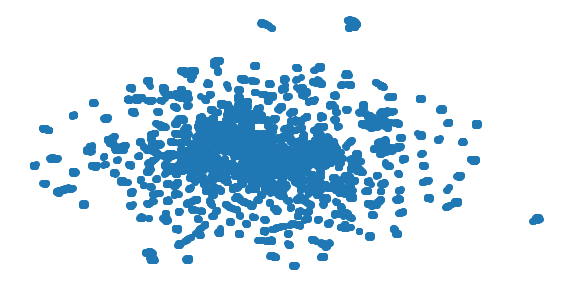

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 45 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  50 neighbors and  1 minimum distance.


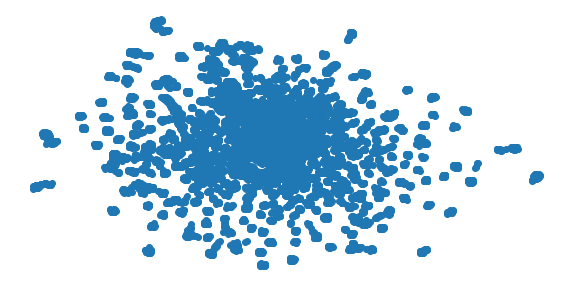

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 17 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  100 neighbors and  0.01 minimum distance.


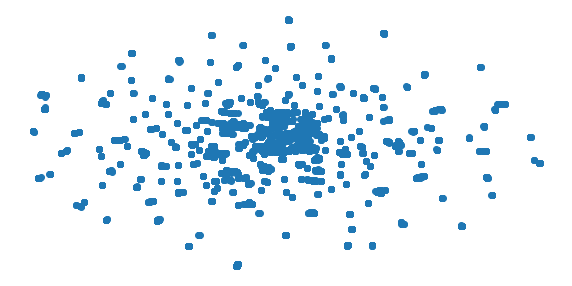

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 16 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  100 neighbors and  0.1 minimum distance.


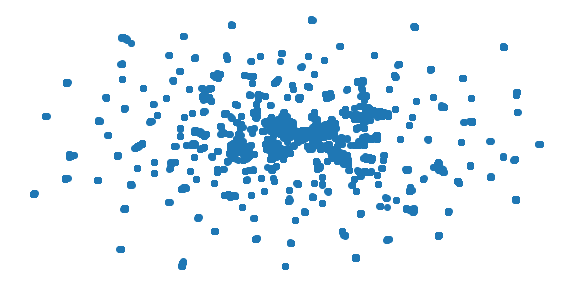

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 17 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  100 neighbors and  0.5 minimum distance.


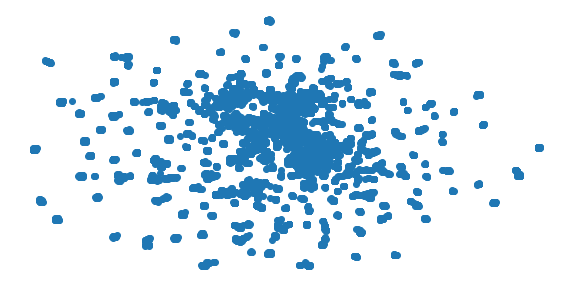

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 17 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  100 neighbors and  0.75 minimum distance.


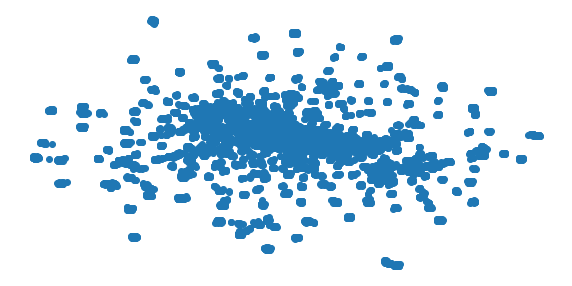

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 16 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  100 neighbors and  1 minimum distance.


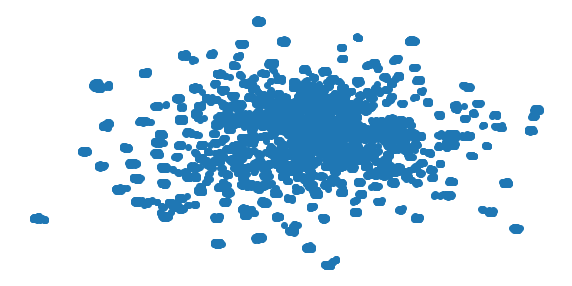

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  250 neighbors and  0.01 minimum distance.


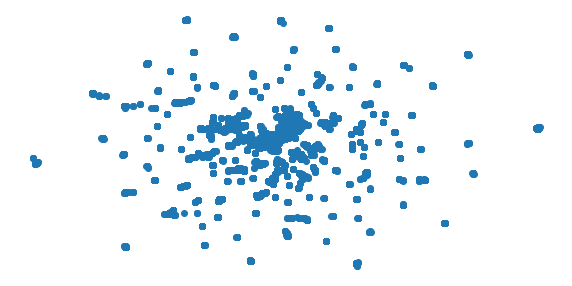

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  250 neighbors and  0.1 minimum distance.


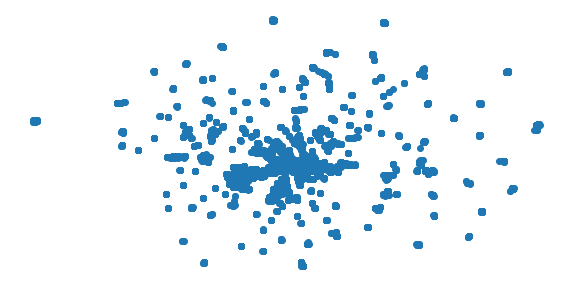

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  250 neighbors and  0.5 minimum distance.


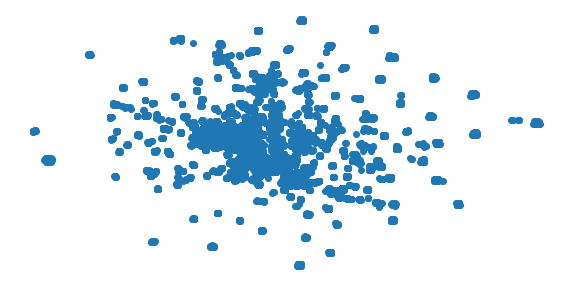

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  250 neighbors and  0.75 minimum distance.


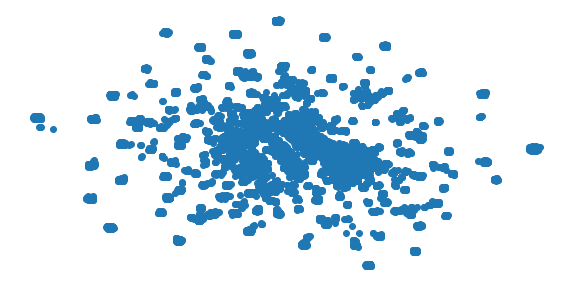

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components


UMAP for X_01hd with  250 neighbors and  1 minimum distance.


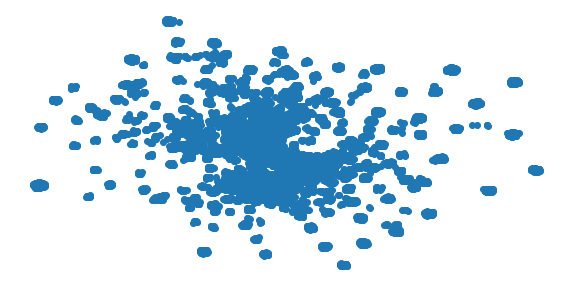

In [226]:
print('UMAP with features highly correlated with norm_humansDeaths. \n')
for n_neighbors in [50, 100, 250]:
    for min_dist in [ 0.01, 0.1, 0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_01hd)
        print('UMAP for X_01hd with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')
        


UMAP with features highly correlated with norm_sumCases. 



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 79 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  50 neighbors and  0.01 minimum distance.


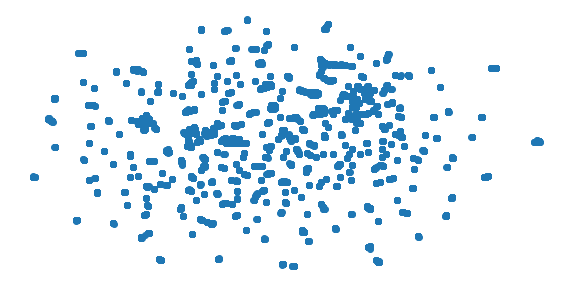

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 79 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  50 neighbors and  0.1 minimum distance.


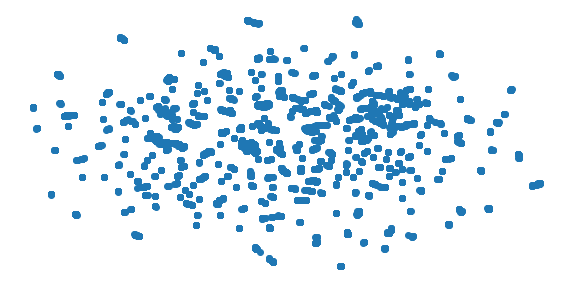

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 74 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  50 neighbors and  0.5 minimum distance.


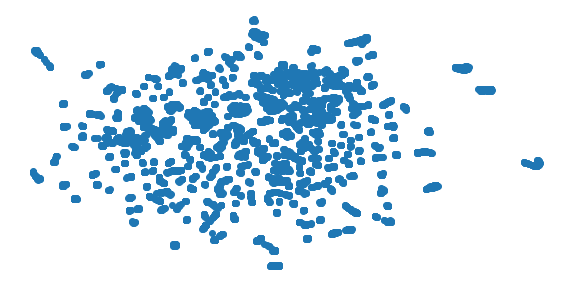

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 74 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  50 neighbors and  0.75 minimum distance.


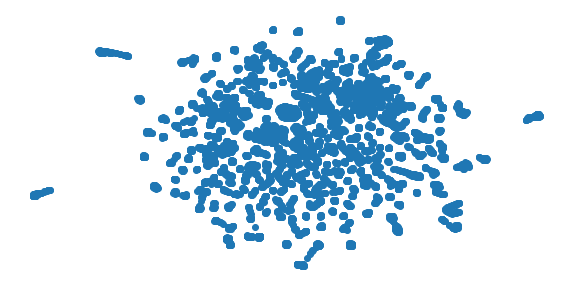

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 77 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  50 neighbors and  1 minimum distance.


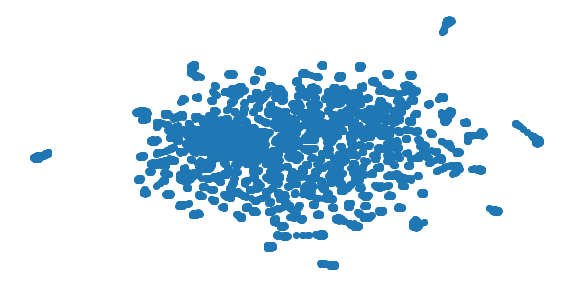

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  100 neighbors and  0.01 minimum distance.


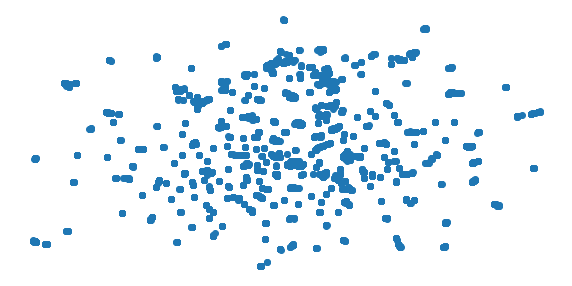

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  100 neighbors and  0.1 minimum distance.


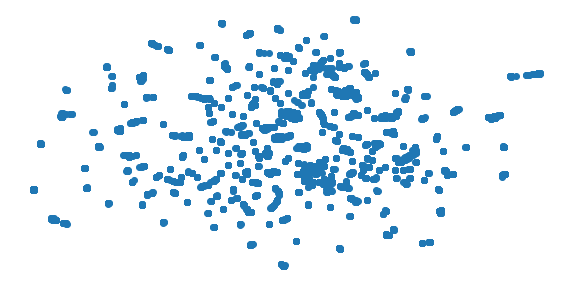

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  100 neighbors and  0.5 minimum distance.


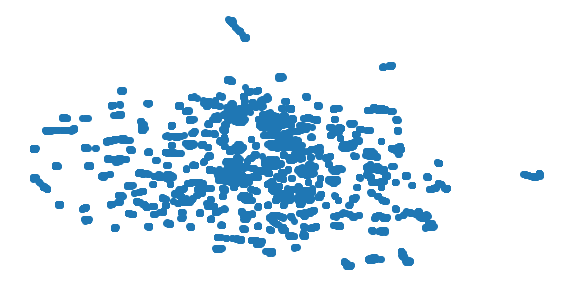

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  100 neighbors and  0.75 minimum distance.


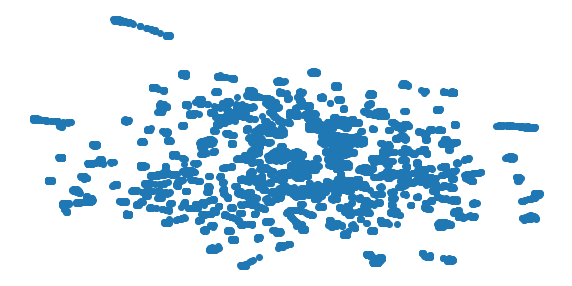

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  100 neighbors and  1 minimum distance.


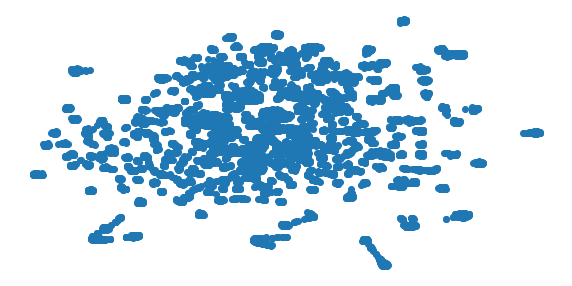

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 16 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  250 neighbors and  0.01 minimum distance.


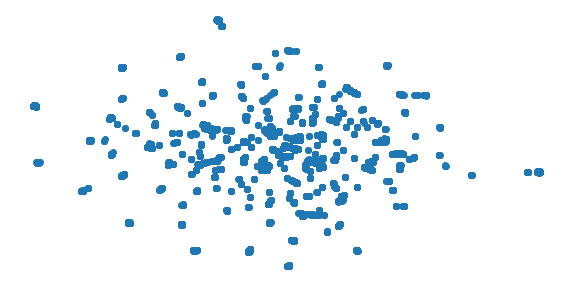

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 15 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  250 neighbors and  0.1 minimum distance.


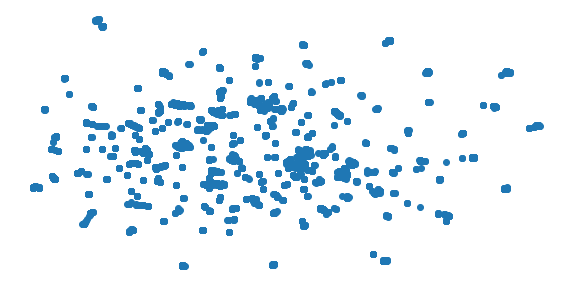

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 16 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  250 neighbors and  0.5 minimum distance.


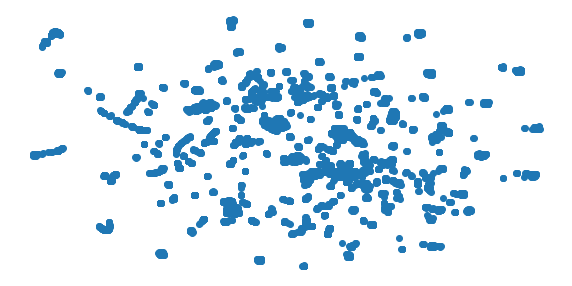

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 15 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  250 neighbors and  0.75 minimum distance.


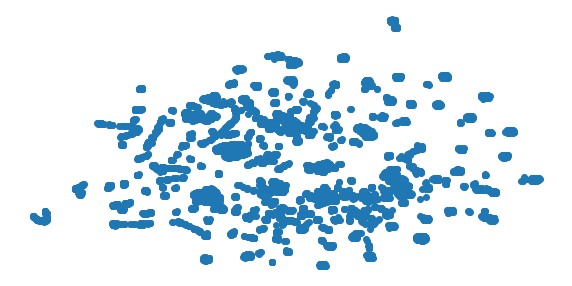

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 16 separate connected components using meta-embedding (experimental)
  n_components


UMAP with  250 neighbors and  1 minimum distance.


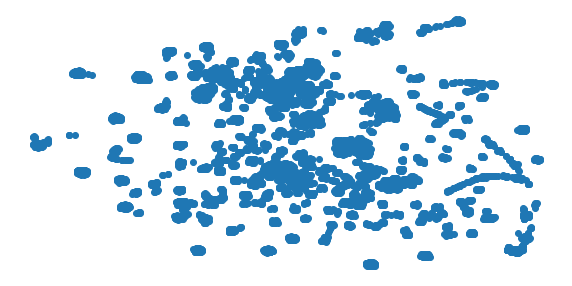

In [227]:
print('UMAP with features highly correlated with norm_sumCases. \n')
for n_neighbors in [50, 100, 250]:
    for min_dist in [ 0.01, 0.1, 0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_01sc)
        print('UMAP with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.p

UMAP with  50 neighbors and  0.01 minimum distance.


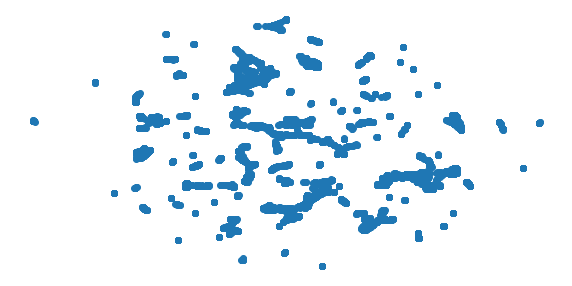

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.1 minimum distance.


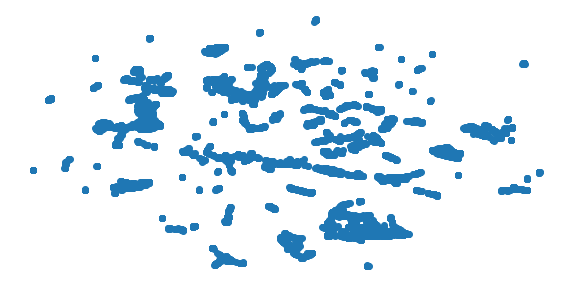

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.5 minimum distance.


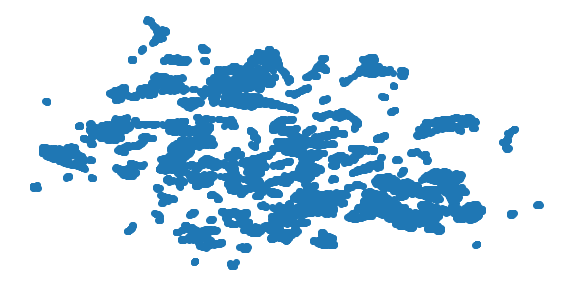

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  0.75 minimum distance.


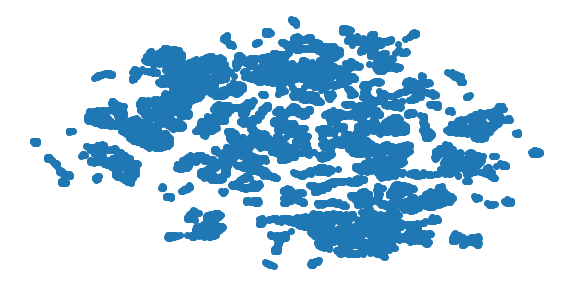

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  50 neighbors and  1 minimum distance.


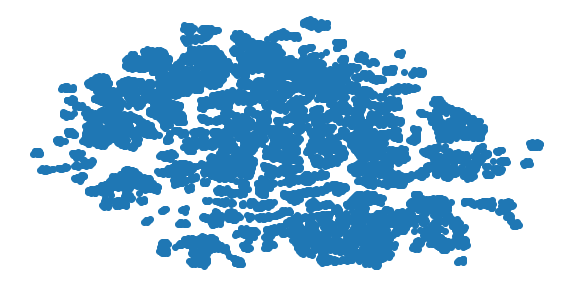

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.01 minimum distance.


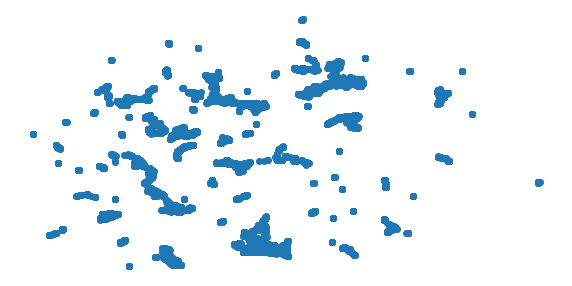

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.1 minimum distance.


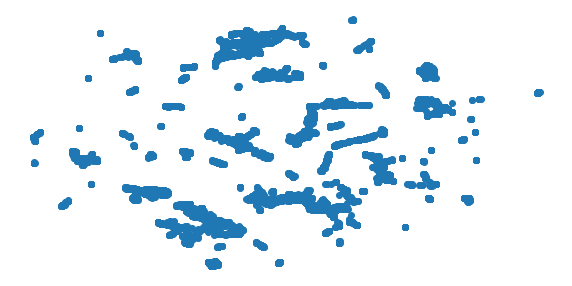

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.5 minimum distance.


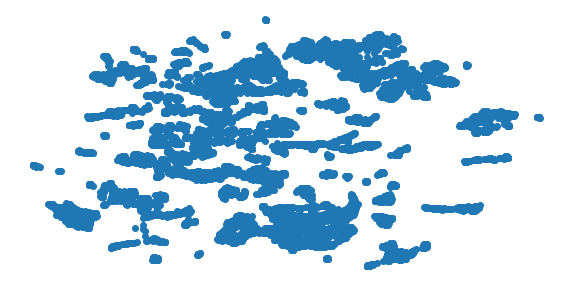

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  0.75 minimum distance.


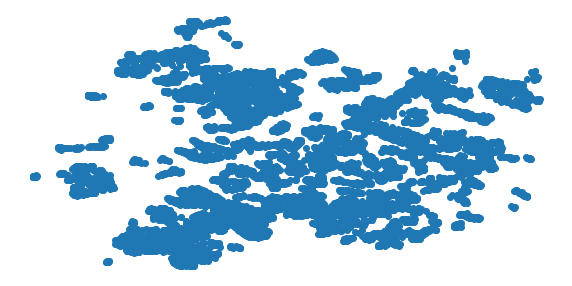

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  100 neighbors and  1 minimum distance.


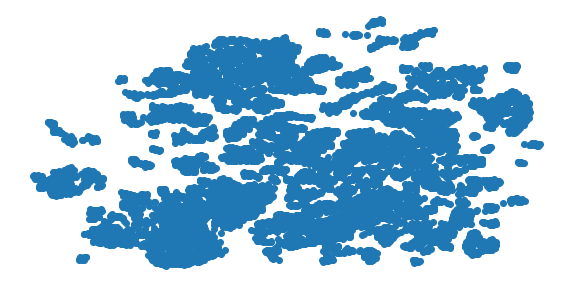

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.01 minimum distance.


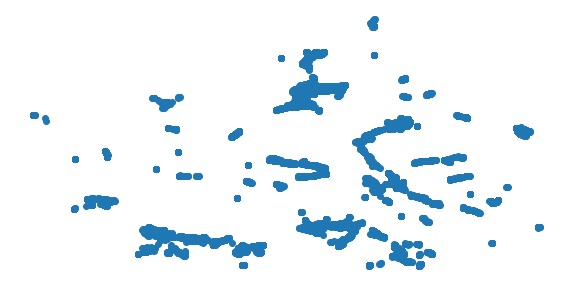

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.1 minimum distance.


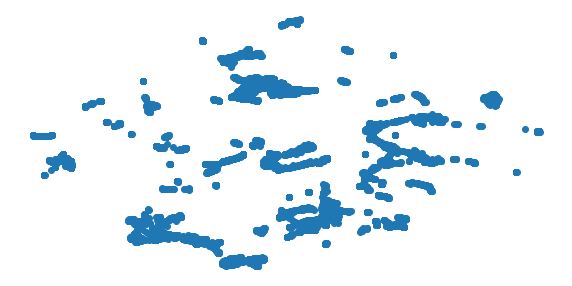

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.5 minimum distance.


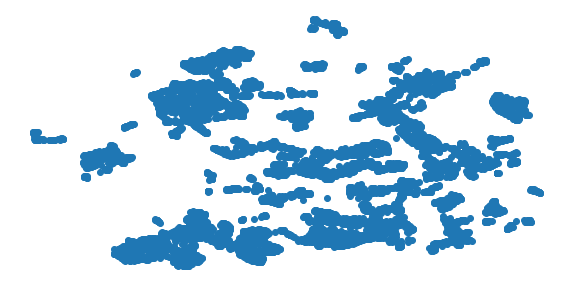

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  0.75 minimum distance.


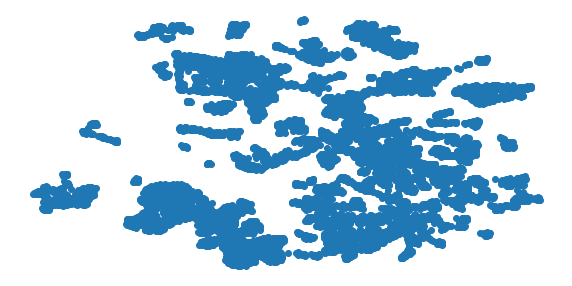

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP with  250 neighbors and  1 minimum distance.


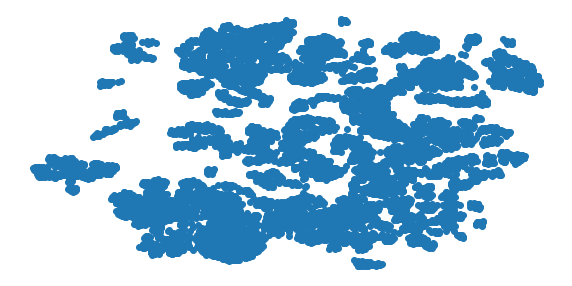

In [30]:
# UMAP with >0.01 correlation
for n_neighbors in [100, 250]:
    for min_dist in [0.1, 0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X_01)
        print('UMAP with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

## LLE 

LLE with  10 neighbors and two components.


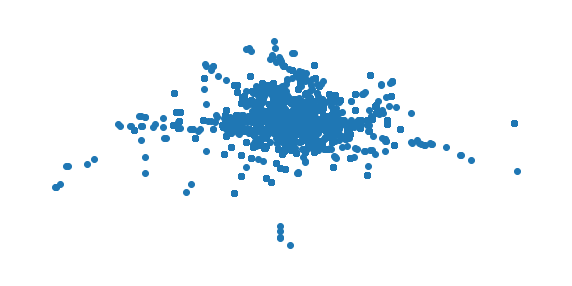



LLE with  25 neighbors and two components.


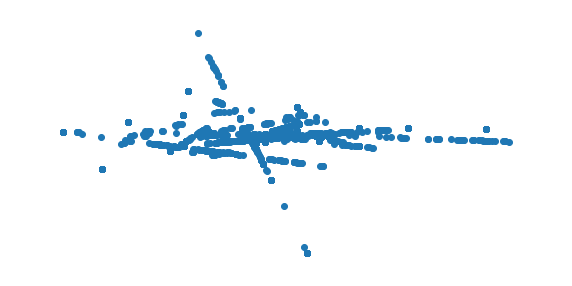



LLE with  50 neighbors and two components.


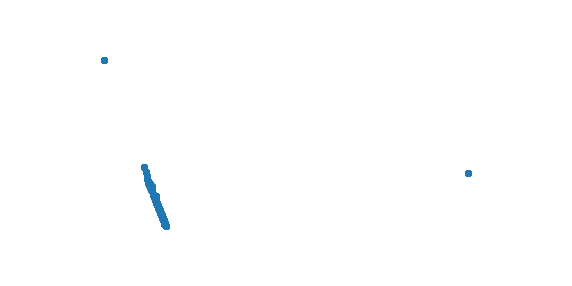

In [43]:
# LLE with all features
for n_neighbors in [10, 25, 50]:
    lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=n_neighbors,
                    eigen_solver='dense').fit_transform(X_all)
    print('LLE with ', n_neighbors, 'neighbors and two components.')
    plt.figure(figsize=(10,5))
    plt.scatter(lle_results[:, 0], lle_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    print('\n')


LLE with  10 neighbors and two components.


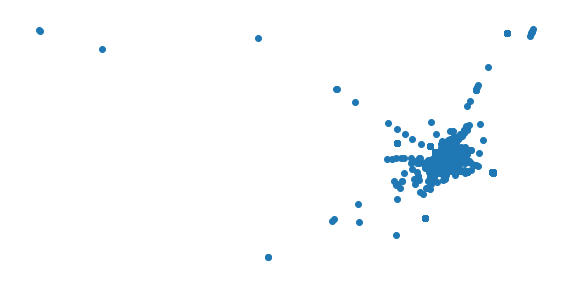



LLE with  25 neighbors and two components.


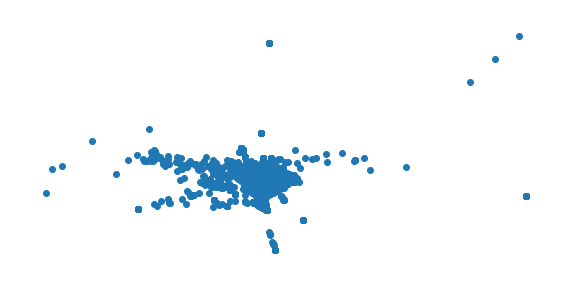



LLE with  50 neighbors and two components.


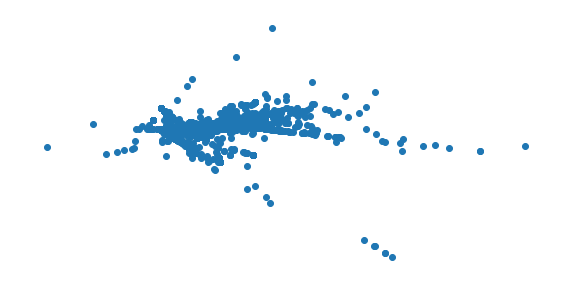

In [41]:
# LLE with all float features
for n_neighbors in [10, 25, 50]:
    lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=n_neighbors,
                    eigen_solver='dense').fit_transform(X_floats)
    print('LLE with ', n_neighbors, 'neighbors and two components.')
    plt.figure(figsize=(10,5))
    plt.scatter(lle_results[:, 0], lle_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    print('\n')

LLE with  25 neighbors and two components.


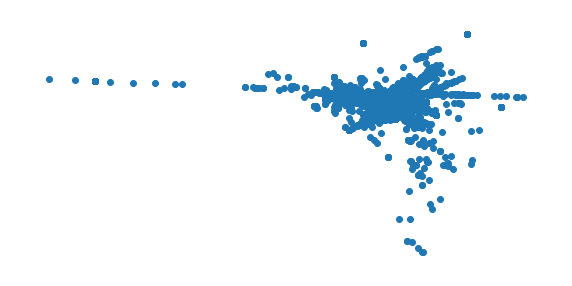



LLE with  50 neighbors and two components.


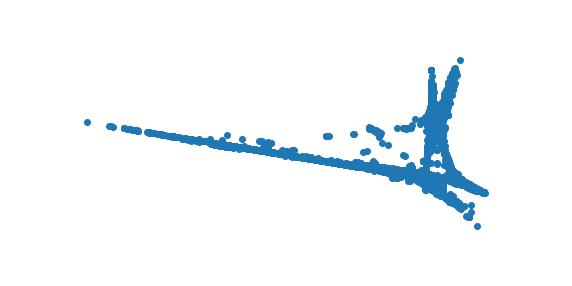



LLE with  100 neighbors and two components.


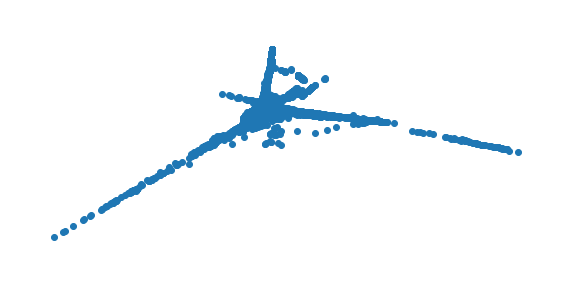

In [42]:
# LLE with features with greater than 0.01 correlation with humansDeaths
for n_neighbors in [25, 50, 100]:
    lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=n_neighbors,
                    eigen_solver='dense').fit_transform(X_01)
    print('LLE with ', n_neighbors, 'neighbors and two components.')
    plt.figure(figsize=(10,5))
    plt.scatter(lle_results[:, 0], lle_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()
    print('\n')

For your third capstone, you’ll complete an unsupervised learning project. You can choose your own research question or choose from one below.

Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

Be prepared to talk about:

- Your end-user and the value your project provides to them.
- Quantifiable results based on the research you’ve conducted.
- The visuals you chose and what they represent for your research.
- Next steps you'd take to expand on your work.
- A specified research question your model addresses.
- How you chose your model specification and what alternatives you compared it to.
- The practical uses of your model for an audience of interest.
- Any weak points or shortcomings of your model.


# Clustering

## K-Means for all features with PCA Components

K-means with 2 clusters.
83.1 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.6449481506982858
Davies-Bouldin Index:  0.47462758187613957


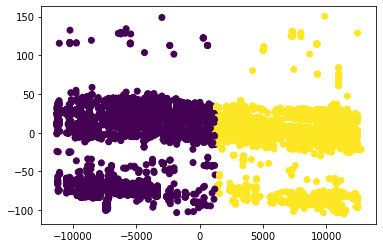



K-means with 4 clusters.
182 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Silhouette Score:  0.594159888666135
Davies-Bouldin Index:  0.49037981781592677


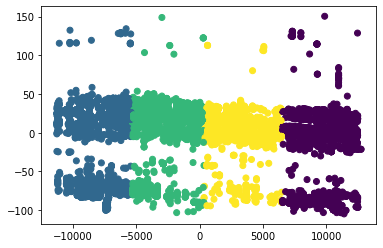



K-means with 6 clusters.
186 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Silhouette Score:  0.5593551798936921
Davies-Bouldin Index:  0.5054395050277002


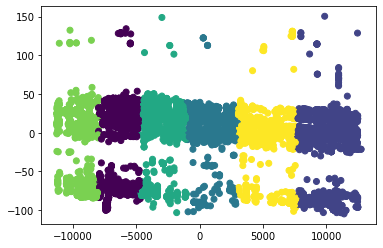



K-means with 8 clusters.
244 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Silhouette Score:  0.5702995013403298
Davies-Bouldin Index:  0.5051946140400023


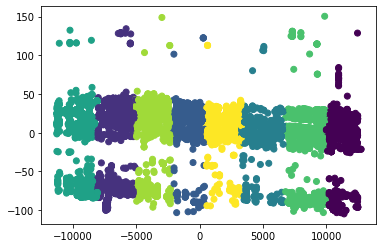



Best Silhouette Score:  0.6449481506982858
Best Davies-Bouldin Index:  0.5054395050277002


In [146]:
# K-means with PCA with all variables, including humansDeaths
X_all = outbreaks.drop(columns=['disease', 'serotypes', 'speciesDescription', 'sumAtRisk', 'sumCases', 'sumDeaths', 
                            'sumDestroyed','sumSlaughtered', 'humansAge', 'humansAffected', 'humansDeaths', 
                            'differenceInDays', 'source','region', 'country', 'localityQuality', 'status', 
                            'observationDate', 'reportingDate'])


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
clusters = [2, 4, 6, 8]
silhouettes = []
dbs = []

for cluster in clusters:
    
    print('K-means with', cluster, 'clusters.')
    labels = KMeans(n_clusters= cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean')
    db = metrics.davies_bouldin_score(pca_components, labels)
    print('Silhouette Score: ', silhouette)
    print('Davies-Bouldin Index: ', db)
    silhouettes.append(silhouette)
    dbs.append(db)
    plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
    plt.show()
    print('\n')
    
print('Best Silhouette Score: ', max(silhouettes))
print('Best Davies-Bouldin Index: ', min(dbs))

## K-Means with floats features, diseases, and regions with PCA components

K-means with 2 clusters.
57.2 ms ± 8.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.9061085908116282


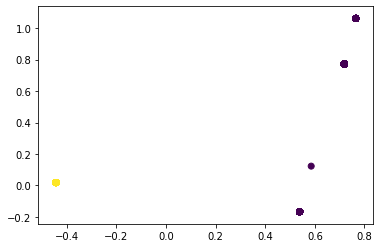



K-means with 3 clusters.
70.7 ms ± 9.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.9936156796693604


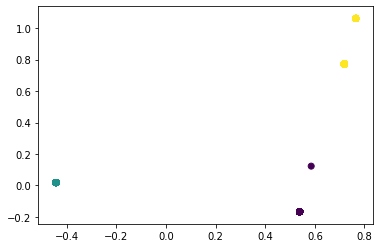



K-means with 4 clusters.
62.2 ms ± 5.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.9998611465671903


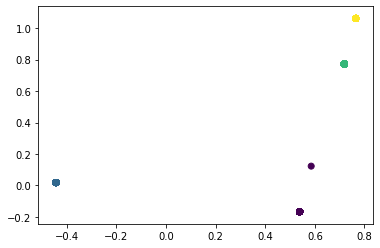



K-means with 5 clusters.
76 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.9998119058076916


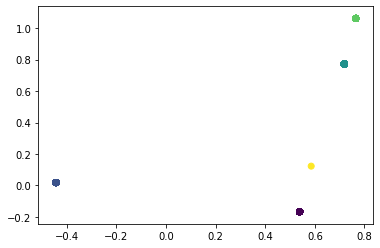



K-means with 6 clusters.
89.3 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.876249316775835


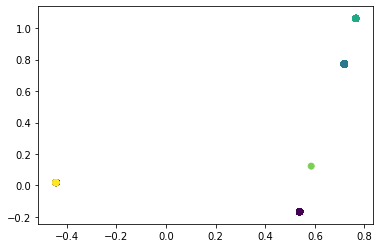



The greatest silhouette score is 0.9998611465671903.


In [116]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_floats)
clusters = [2, 3, 4, 5, 6]
silhouettes_kpca = []
dbs = []
for cluster in clusters:    
    print('K-means with', cluster, 'clusters.')
    labels = KMeans(n_clusters= cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean')
    silhouettes_kpca.append(silhouette)
    print('Silhouette Score: ', silhouette)
    db = metrics.davies_bouldin_score(pca_components, labels)
    dbs.append(db)
    print('Davies Bouldin Index: ', db)
    plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
    plt.show()
    print('\n')
    
print('Best Silhouette Score: ', max(silhouettes_kpca))
print('Best Davies Bouldin Index: ', min(dbs))

## K-Means with greater correlation with PCA components

K-means with 2 clusters.
77.3 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.7651674873331588
Davies Bouldin Index:  0.2894053942136346


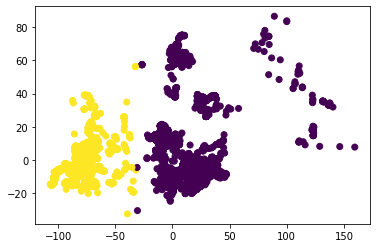



K-means with 3 clusters.
97.9 ms ± 5.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.5876398689537584
Davies Bouldin Index:  0.7981993669021112


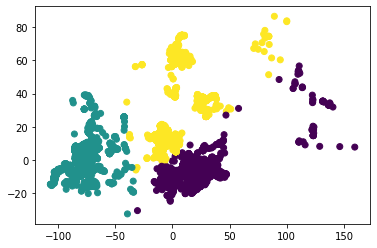



K-means with 4 clusters.
147 ms ± 35.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Silhouette Score:  0.5304061212411122
Davies Bouldin Index:  0.6054768087729739


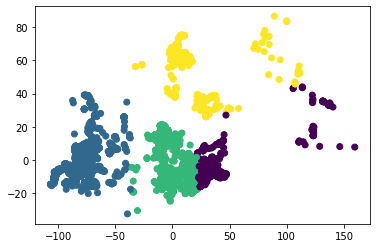



Best Silhouette Score: 0.7651674873331588
Best Davies Bouldin Index:  0.2894053942136346


In [154]:
# K-means with PCA for features with greater than 0.01 absolute correlation with potential target

X_01 = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'norm_humansAffected', 'Portugal', 'MERS-CoV ',
                      'WHO', 'Centroid Admin1', 'Asia', 'norm_sumSlaughtered', 'OIE', 'Other', 'National authorities',
                      'Europe', 'norm_sumDestroyed', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear', 'Uknown', 'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8', 'norm_humansAge', 
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'norm_sumCases', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_humansDeaths']]

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)
clusters = [2, 3, 4]
silhouettes_kpca = []
dbs = []

for cluster in clusters:
    
    print('K-means with', cluster, 'clusters.')
    labels = KMeans(n_clusters= cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean')
    print('Silhouette Score: ', silhouette)
    silhouettes_kpca.append(silhouette)
    db = metrics.davies_bouldin_score(pca_components, labels)
    dbs.append(db)
    print('Davies Bouldin Index: ', db)
    plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
    plt.show()
    print('\n')
    
    
print('Best Silhouette Score:', max(silhouettes_kpca))
print('Best Davies Bouldin Index: ', min(dbs))

In [ ]:
print('Best Cluster:')

silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean')
print('Silhouette Score: ', silhouette)
silhouettes_kpca.append(silhouette)
db = metrics.davies_bouldin_score(pca_components, labels)
dbs.append(db)
print('Davies Bouldin Index: ', db)
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

//anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


104 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The Silhoutte score with 2 clusters: 0.41921085119247437


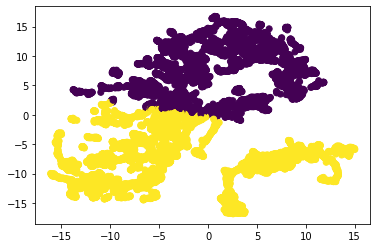



145 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The Silhoutte score with 3 clusters: 0.4787784814834595


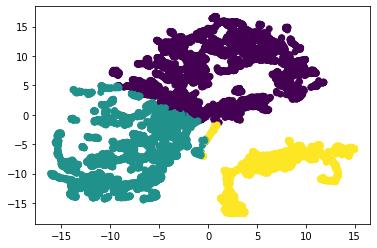



190 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The Silhoutte score with 4 clusters: 0.4569926857948303


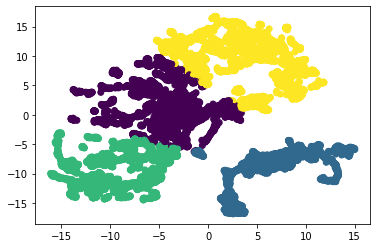

In [428]:
clusters = [2, 3, 4]
silhouettes_kumap = []
umap_results = umap.UMAP(n_neighbors=250,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_all)
for cluster in clusters: 
    k_means = KMeans(n_clusters=cluster, random_state=123)
    labels = KMeans(n_clusters= cluster, random_state=123).fit_predict(umap_results)
    %timeit k_means.fit(umap_results)
    y_pred = k_means.predict(umap_results)
    print('The Silhoutte score with', cluster, 'clusters: {}'.format(metrics.silhouette_score(umap_results, labels, metric='euclidean')))
    silhouettes_kumap.append(metrics.silhouette_score(umap_results, clusters, metric='euclidean'))
    # Plot the solution.
    plt.scatter(umap_results[:,0], umap_results[:,1], c=y_pred)
    plt.show()
    print('\n')
    
print('The greatest silhouette score is {}.'.format(max(silhouettes_kumap)))

53.5 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The Silhoutte score with 2 clusters: 0.4546541899212932


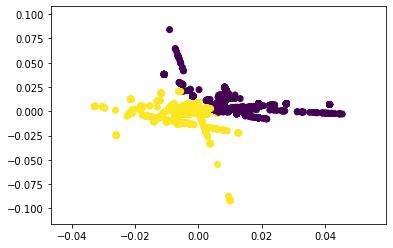



80.7 ms ± 866 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The Silhoutte score with 3 clusters: 0.5110947982357423


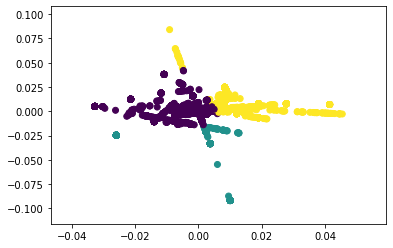



91.6 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The Silhoutte score with 4 clusters: 0.5408601987889076


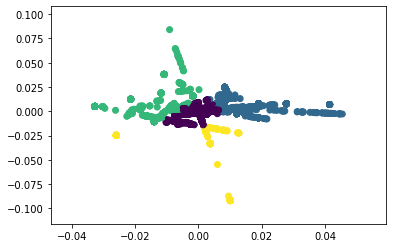



The greatest silhouette score is 0.5408601987889076.


In [46]:
clusters = [2, 4, 6, 8]
silhouettes_klle = []
lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=25,
                    eigen_solver='dense').fit_transform(X_all)
for cluster in clusters: 
    k_means = KMeans(n_clusters=cluster, random_state=123)
    labels = KMeans(n_clusters= cluster, random_state=123).fit_predict(lle_results)
    %timeit k_means.fit(lle_results)
    y_pred = k_means.predict(lle_results)
    silhouette = metrics.silhouette_score(lle_results, labels, metric='euclidean')
    print('The Silhoutte score with', cluster, 'clusters: {}'.format(silhouette))
    silhouettes_klle.append(silhouette)
    # Plot the solution.
    plt.scatter(lle_results[:,0], lle_results[:,1], c=y_pred)
    plt.show()
    print('\n')
    
print('The greatest silhouette score is {}.'.format(max(silhouettes_klle)))


In [ ]:
clusters = [2, 4, 6, 8]
silhouettes_klle = []
lle_results = LocallyLinearEmbedding(n_components=2, 
                    n_neighbors=100,
                    eigen_solver='dense').fit_transform(X_01)
for cluster in clusters: 
    k_means = KMeans(n_clusters=cluster, random_state=123)
    labels = KMeans(n_clusters= cluster, random_state=123).fit_predict(lle_results)
    %timeit k_means.fit(lle_results)
    y_pred = k_means.predict(lle_results)
    silhouette = metrics.silhouette_score(lle_results, labels, metric='euclidean')
    print('The Silhoutte score with', cluster, 'clusters: {}'.format(silhouette))
    silhouettes_klle.append(silhouette)
    # Plot the solution.
    plt.scatter(lle_results[:,0], lle_results[:,1], c=y_pred)
    plt.show()
    print('\n')
    
print('The greatest silhouette score is {}.'.format(max(silhouettes_klle)))

In [122]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)

k_means_clusters = KMeans(n_clusters=2, random_state=123).fit_predict(pca_components)

unique, counts = np.unique(k_means_clusters, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['k_means_clusters'] = k_means_clusters
outbreaks.head()



{0: 10319, 1: 2383}


Id source   latitude  longitude  region             country  \
0  230399    OIE -27.900000  30.800000  Africa        South Africa   
1  230381    OIE  54.837037  73.354155  Europe  Russian Federation   
3  230396    OIE -26.000000  28.300000  Africa        South Africa   
4  230371    OIE  49.237900  17.700200  Europe      Czech Republic   
5  230370    OIE  49.237300  17.700800  Europe      Czech Republic   

  localityQuality observationDate reportingDate     status  \
0           Exact      2017-08-17    2017-08-22  Confirmed   
1           Exact      2017-08-16    2017-08-18  Confirmed   
3           Exact      2017-08-15    2017-08-22  Confirmed   
4           Exact      2017-08-15    2017-08-17  Confirmed   
5           Exact      2017-08-15    2017-08-17  Confirmed   

               disease  serotypes              speciesDescription  \
0    Influenza - Avian  H5N8 HPAI  [domestic,, unspecified, bird]   
1  African swine fever     Uknown              [domestic,, swine]   
3    Influenza - Avian  H5N8 HPAI      [wild,, unspecified, bird]   
4  African swine fever     Uknown             [wild,, wild, boar]   
5  African swine fever     Uknown             [wild,, wild, boar]   

       sumAtRisk  sumCases  sumDeaths  sumDestroyed  sumSlaughtered  \
0  248000.000000      12.0       12.0  50000.000000        0.000000   
1     122.000000       6.0        1.0      0.000000        0.000000   
3    7500.691709       1.0        1.0      0.000000        0.000000   
4    7500.691709       1.0        1.0   3765.857978      100.211443   
5    7500.691709       1.0        1.0   3765.857978      100.211443   

   humansAge  humansAffected  humansDeaths  differenceInDays  observationYear  \
0   0.000000             1.0           1.0               5.0             2017   
1  17.701311             1.0           1.0               2.0             2017   
3   0.000000             1.0           1.0               7.0             2017   
4  17.701311             1.0           1.0               2.0             2017   
5  17.701311             1.0           1.0               2.0             2017   

   observationMonth  observationDay  observationFirstHalfMonth  \
0                 8              17                          0   
1                 8              16                          0   
3                 8              15                          1   
4                 8              15                          1   
5                 8              15                          1   

   observationSecondHalfMonth  EC  FAO Field Officer  FAO officer  FAO-Report  \
0                           1   0                  0            0           0   
1                           1   0                  0            0           0   
3                           0   0                  0            0           0   
4                           0   0                  0            0           0   
5                           0   0                  0            0           0   

   International reference laboratory  \
0                                   0   
1                                   0   
3                                   0   
4                                   0   
5                                   0   

   National Institute for Communicable Diseases, NICD  National authorities  \
0                                                  0                      0   
1                                                  0                      0   
3                                                  0                      0   
4                                                  0                      0   
5                                                  0                      0   

   OIE  Other  Publications  WHO  sequence only  Africa  Americas  Asia  \
0    1      0             0    0              0       1         0     0   
1    1      0             0    0              0       0         0     0   
3    1      0             0    0              0      

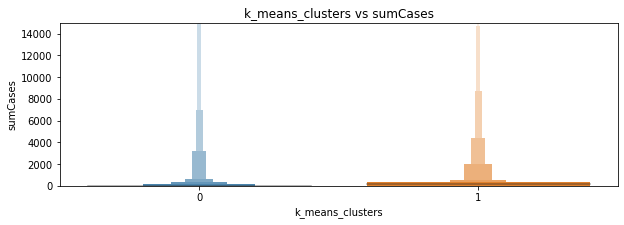

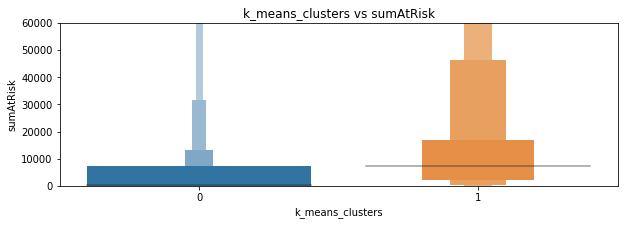

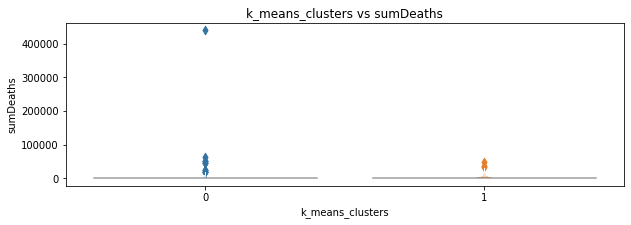

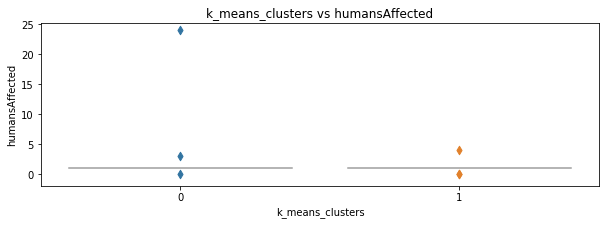

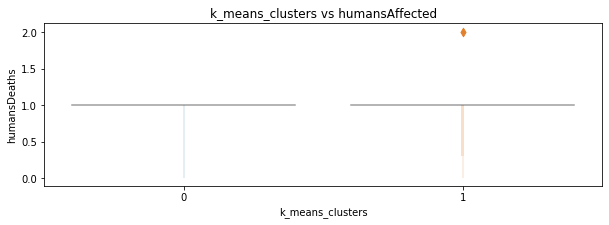

In [123]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumCases'])
plt.title('k_means_clusters vs sumCases')
box.set_ylim(0, 15000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumAtRisk'])
plt.title('k_means_clusters vs sumAtRisk')
box.set_ylim(0, 60000)
plt.show()

plt.figure(figsize=(10,3))
bpx = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumDeaths'])
plt.title('k_means_clusters vs sumDeaths')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['humansAffected'])
plt.title('k_means_clusters vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['humansDeaths'])
plt.title('k_means_clusters vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

## Agglomerative Clustering with PCA Components

The Silhoutte score with ward linkage and 2 clusters: 0.7651157814536663
The Davies Bouldin score with ward linkage and 2 clusters:  0.2893401095652642


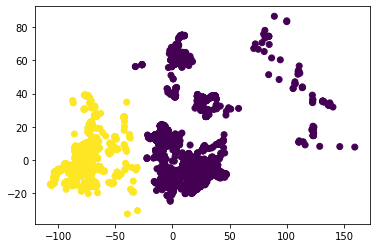



The Silhoutte score with ward linkage and 3 clusters: 0.5825725611287319
The Davies Bouldin score with ward linkage and 3 clusters:  0.7853499775498923


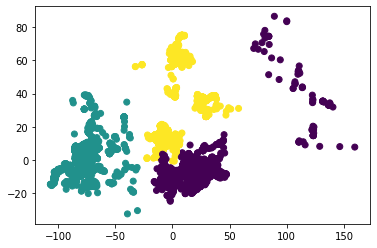



The Silhoutte score with ward linkage and 4 clusters: 0.6012944443790336
The Davies Bouldin score with ward linkage and 4 clusters:  0.6797571060371833


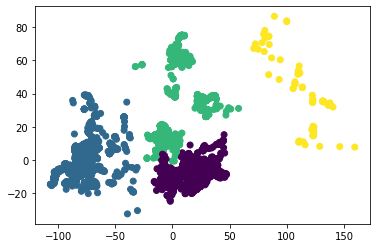



The Silhoutte score with complete linkage and 2 clusters: 0.6379194869721895
The Davies Bouldin score with complete linkage and 2 clusters:  0.49663220514803386


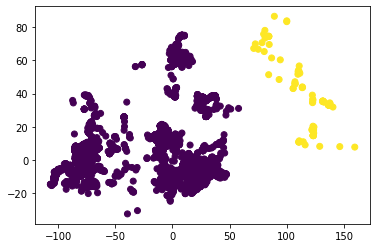



The Silhoutte score with complete linkage and 3 clusters: 0.7598552706116315
The Davies Bouldin score with complete linkage and 3 clusters:  0.3567463090298044


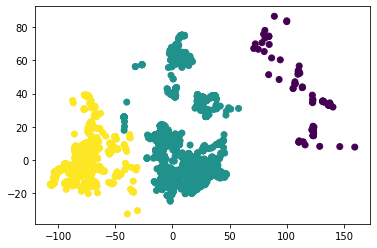



The Silhoutte score with complete linkage and 4 clusters: 0.7511704704929765
The Davies Bouldin score with complete linkage and 4 clusters:  0.4843124601718921


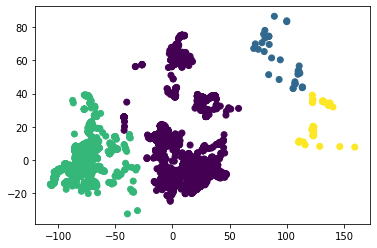



The Silhoutte score with average linkage and 2 clusters: 0.6379194869721895
The Davies Bouldin score with average linkage and 2 clusters:  0.49663220514803386


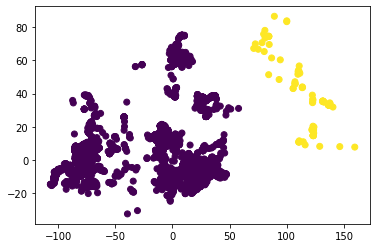



The Silhoutte score with average linkage and 3 clusters: 0.7610537116579972
The Davies Bouldin score with average linkage and 3 clusters:  0.357414446300157


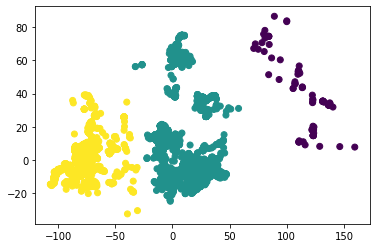



The Silhoutte score with average linkage and 4 clusters: 0.7479352345631413
The Davies Bouldin score with average linkage and 4 clusters:  0.3795446161964321


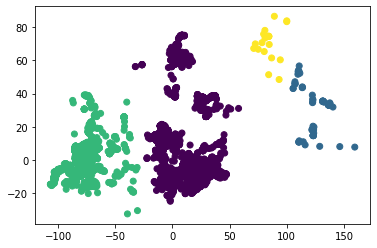



Best Silhouette score:  0.7651157814536663


ValueError: min() arg is an empty sequence

In [183]:
# With PCA components from features with greater than 0.01 correlation
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)
silhouettes_aggpca = []

linkage = ['ward', 'complete', 'average']
numbers = [2, 3, 4]
silhouettes_aggpca = []
db_aggpca = []

for link in linkage:
    for cluster in numbers:
        agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        clusters = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
        silhouettes_aggpca.append(silhouette)
        print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: {}'.format(metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
        db = metrics.davies_bouldin_score(pca_components, clusters)
        db_aggpca.append(db)
        print('The Davies Bouldin score with', link,'linkage and', cluster, 'clusters: ', db)
        plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
        plt.show()
        print('\n')
        
print('Best Silhouette score: ', max(silhouettes_aggpca))
print('Best Davies Bouldin score: ', min(db_aggpca))

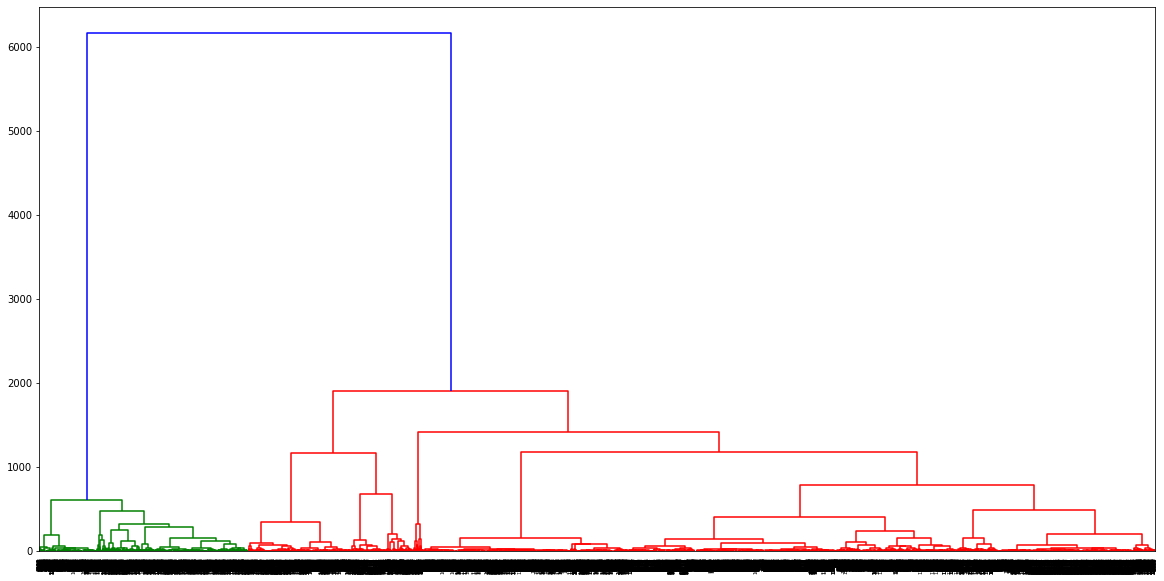

In [184]:
agg_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

plt.figure(figsize=(20,10))
dendrogram(lnkg(pca_components, method='ward'))
plt.show()

In [141]:
outbreaks.isnull()
null_columns = outbreaks.columns[outbreaks.isnull().any()]

outbreaks[null_columns].isnull().sum()

outbreaks[outbreaks['agg_pca_clusters'] == 3]

Id                source   latitude  longitude    region  \
3754   223456                   OIE -32.432700 -71.135600  Americas   
5187   221131  National authorities -33.080700 -71.250000  Americas   
12546  214913                   OIE -25.450144 -54.549905  Americas   
12730  211657  National authorities -36.856210 -60.712906  Americas   
16798  208118                   OIE -22.135200 -42.372000  Americas   
16822  208117                   OIE -29.263300 -51.574800  Americas   
16837  208116                   OIE -20.453100 -54.418600  Americas   
16850  208115                   OIE -27.170200 -50.224100  Americas   
16856  209791                   OIE -25.450144 -54.549906  Americas   
16857  209790                   OIE -25.450144 -54.549906  Americas   
16858  209789                   OIE -25.450144 -54.549906  Americas   
16950  208114                   OIE   1.480100 -60.784100  Americas   
16951  208113                   OIE -16.765800 -49.618700  Americas   
16987  208112                   OIE -18.662700 -44.573100  Americas   
16988  208111                   OIE -22.250400 -48.259800  Americas   
16989  208110                   OIE -19.543600 -40.699700  Americas   
16990  208109                   OIE -12.169700 -55.640200  Americas   
16996  208108                   OIE  -2.338500 -52.004300  Americas   
16999  208107                   OIE -10.186300 -63.081300  Americas   
17001  208106                   OIE -24.667000 -51.162000  Americas   

         country  localityQuality observationDate reportingDate     status  \
3754       Chile          Unknown      2017-01-28    2017-07-02  Confirmed   
5187       Chile            Exact      2016-12-26    2017-04-01  Confirmed   
12546     Brazil            Exact      2016-04-17    2016-07-28  Confirmed   
12730  Argentina  Centroid Admin2      2016-03-24    2016-03-29  Confirmed   
16798     Brazil            Exact      2015-06-30    2015-10-28  Confirmed   
16822     Brazil            Exact      2015-01-06    2015-10-28  Confirmed   
16837     Brazil            Exact      2015-04-28    2015-10-28  Confirmed   
16850     Brazil            Exact      2015-02-04    2015-10-28  Confirmed   
16856     Brazil            Exact      2015-11-03    2016-01-15  Confirmed   
16857     Brazil            Exact      2015-11-03    2016-01-15  Confirmed   
16858     Brazil            Exact      2015-11-03    2016-01-15  Confirmed   
16950     Brazil            Exact      2014-04-11    2015-10-28  Confirmed   
16951     Brazil            Exact      2014-10-29    2015-10-28  Confirmed   
16987     Brazil            Exact      2014-08-08    2015-10-28  Confirmed   
16988     Brazil            Exact      2014-07-08    2015-10-28  Confirmed   
16989     Brazil            Exact      2014-05-27    2015-10-28  Confirmed   
16990     Brazil            Exact      2014-05-27    2015-10-28  Confirmed   
16996     Brazil            Exact      2014-01-04    2015-10-28  Confirmed   
16999     Brazil            Exact      2014-03-02    2015-10-28  Confirmed   
17001     Brazil            Exact      2013-05-09    2015-10-28  Confirmed   

                 disease  serotypes               speciesDescription  \
3754   Influenza - Avian  H7N6 LPAI   [domestic,, unspecified, bird]   
5187   Influenza - Avian    H7 LPAI              [domestic,, turkey]   
12546         Bluetongue         22                 [captive,, deer]   
12730            Anthrax     Uknown              [domestic,, cattle]   
16798           Glanders     Uknown               [domestic,, horse]   
16822           Glanders     Uknown               [domestic,, horse]   
16837           Glanders     Uknown               [domestic,, horse]   
16850           Glanders     Uknown               [domestic,, horse]   
16856         Bluetongue         18  [captive,, unspecified, mammal]   
16857         Bluetongue         14  [captive,, unspecified, mammal]   
16858         Bluetongue          3  [captive,, unspecified, mammal]   
16950           

In [134]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)

agg_clusters = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
agg_custer = agg_clusters.fit_predict(pca_components)
unique, counts = np.unique(agg_cluster.labels_, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['agg_pca_clusters'] = agg_cluster.labels_
outbreaks.head()

{0: 10227, 1: 72, 2: 2383, 3: 20}


Id source   latitude  longitude  region             country  \
0  230399    OIE -27.900000  30.800000  Africa        South Africa   
1  230381    OIE  54.837037  73.354155  Europe  Russian Federation   
3  230396    OIE -26.000000  28.300000  Africa        South Africa   
4  230371    OIE  49.237900  17.700200  Europe      Czech Republic   
5  230370    OIE  49.237300  17.700800  Europe      Czech Republic   

  localityQuality observationDate reportingDate     status  \
0           Exact      2017-08-17    2017-08-22  Confirmed   
1           Exact      2017-08-16    2017-08-18  Confirmed   
3           Exact      2017-08-15    2017-08-22  Confirmed   
4           Exact      2017-08-15    2017-08-17  Confirmed   
5           Exact      2017-08-15    2017-08-17  Confirmed   

               disease  serotypes              speciesDescription  \
0    Influenza - Avian  H5N8 HPAI  [domestic,, unspecified, bird]   
1  African swine fever     Uknown              [domestic,, swine]   
3    Influenza - Avian  H5N8 HPAI      [wild,, unspecified, bird]   
4  African swine fever     Uknown             [wild,, wild, boar]   
5  African swine fever     Uknown             [wild,, wild, boar]   

       sumAtRisk  sumCases  sumDeaths  sumDestroyed  sumSlaughtered  \
0  248000.000000      12.0       12.0  50000.000000        0.000000   
1     122.000000       6.0        1.0      0.000000        0.000000   
3    7500.691709       1.0        1.0      0.000000        0.000000   
4    7500.691709       1.0        1.0   3765.857978      100.211443   
5    7500.691709       1.0        1.0   3765.857978      100.211443   

   humansAge  humansAffected  humansDeaths  differenceInDays  observationYear  \
0   0.000000             1.0           1.0               5.0             2017   
1  17.701311             1.0           1.0               2.0             2017   
3   0.000000             1.0           1.0               7.0             2017   
4  17.701311             1.0           1.0               2.0             2017   
5  17.701311             1.0           1.0               2.0             2017   

   observationMonth  observationDay  observationFirstHalfMonth  \
0                 8              17                          0   
1                 8              16                          0   
3                 8              15                          1   
4                 8              15                          1   
5                 8              15                          1   

   observationSecondHalfMonth  EC  FAO Field Officer  FAO officer  FAO-Report  \
0                           1   0                  0            0           0   
1                           1   0                  0            0           0   
3                           0   0                  0            0           0   
4                           0   0                  0            0           0   
5                           0   0                  0            0           0   

   International reference laboratory  \
0                                   0   
1                                   0   
3                                   0   
4                                   0   
5                                   0   

   National Institute for Communicable Diseases, NICD  National authorities  \
0                                                  0                      0   
1                                                  0                      0   
3                                                  0                      0   
4                                                  0                      0   
5                                                  0                      0   

   OIE  Other  Publications  WHO  sequence only  Africa  Americas  Asia  \
0    1      0             0    0              0       1         0     0   
1    1      0             0    0              0       0         0     0   
3    1      0             0    0              0      

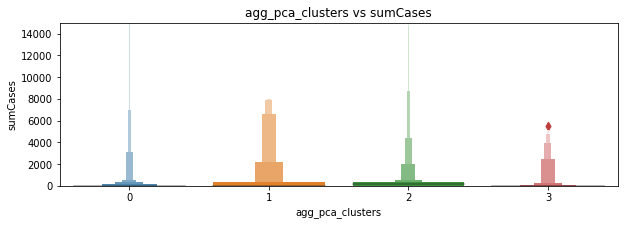

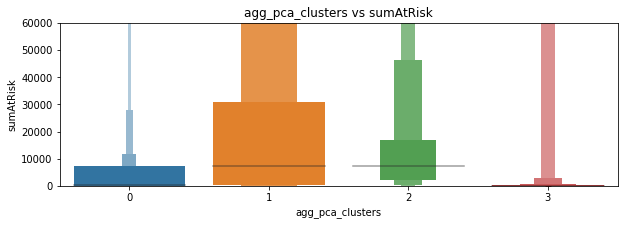

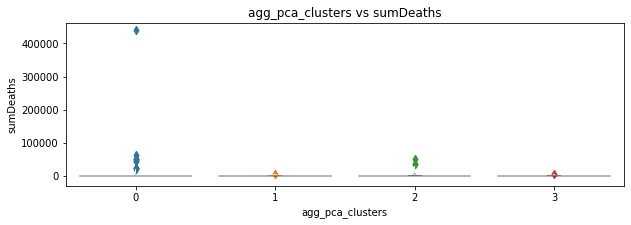

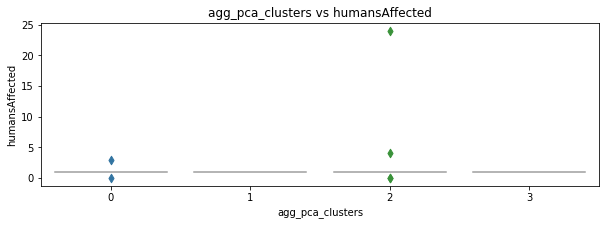

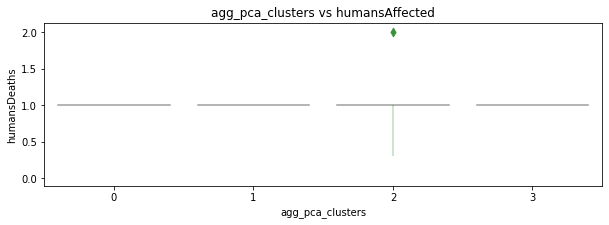

In [135]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['agg_pca_clusters'], y=outbreaks['sumCases'])
plt.title('agg_pca_clusters vs sumCases')
box.set_ylim(0, 15000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['agg_pca_clusters'], y=outbreaks['sumAtRisk'])
plt.title('agg_pca_clusters vs sumAtRisk')
box.set_ylim(0, 60000)
plt.show()

plt.figure(figsize=(10,3))
bpx = sns.boxenplot(x=outbreaks['agg_pca_clusters'], y=outbreaks['sumDeaths'])
plt.title('agg_pca_clusters vs sumDeaths')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['agg_pca_clusters'], y=outbreaks['humansAffected'])
plt.title('agg_pca_clusters vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['agg_pca_clusters'], y=outbreaks['humansDeaths'])
plt.title('agg_pca_clusters vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

## Agglomerative Clustering with UMAP

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


The Silhoutte score with ward linkage and 2 clusters:  0.3160671


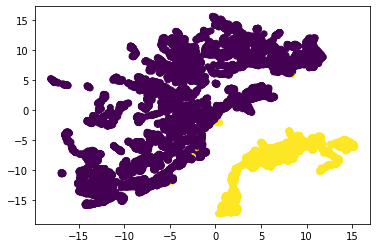



The Silhoutte score with ward linkage and 3 clusters:  0.105980165


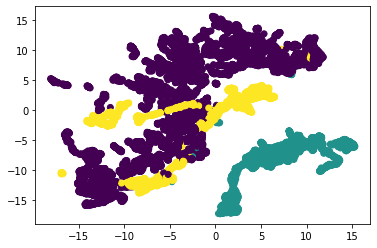



The Silhoutte score with ward linkage and 4 clusters:  0.016225545


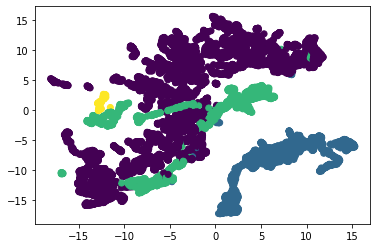



The Silhoutte score with complete linkage and 2 clusters:  -0.022278477


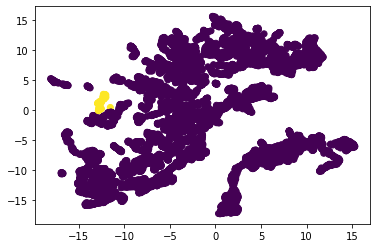



The Silhoutte score with complete linkage and 3 clusters:  0.046010524


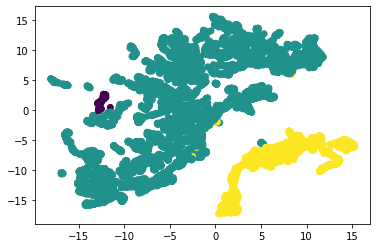



The Silhoutte score with complete linkage and 4 clusters:  0.035379328


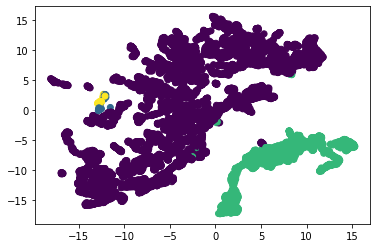



The Silhoutte score with average linkage and 2 clusters:  -0.022278477


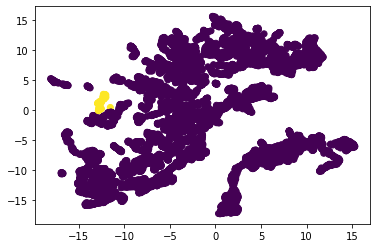



The Silhoutte score with average linkage and 3 clusters:  0.047984242


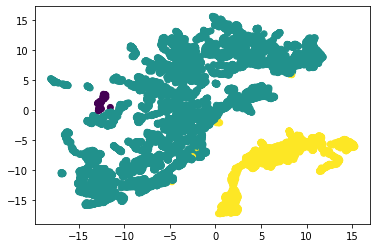



The Silhoutte score with average linkage and 4 clusters:  0.024032628


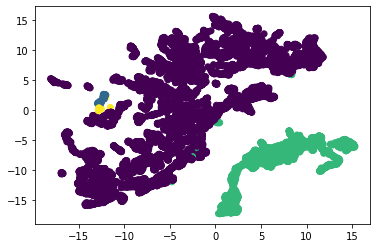



Best Silhouette Score:  0.3160671


ValueError: min() arg is an empty sequence

In [180]:
umap_results = umap.UMAP(n_neighbors=250,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_all)

linkage = ['ward', 'complete', 'average']
numbers = [2, 3, 4]
silhouettes_aggumap = []
dbs_aggumap = []
for link in linkage:
    for cluster in numbers:
        agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        clusters = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(umap_results, clusters, metric='euclidean')
        silhouettes_aggumap.append(metrics.silhouette_score(umap_results, clusters, metric='euclidean'))
        print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: ', silhouette)
        db = metrics.davies_bouldin_score(umap_results, labels)
        dbs.append(db)
        print('The Davies Bouldin score with', link,'linkage and', cluster, 'clusters: ', db)
        plt.scatter(umap_results[:,0], umap_results[:,1], c=clusters)
        plt.show()
        
        print('\n')
        
print('Best Silhouette Score: ', (max(silhouettes_aggumap)))
print('Best Davies Bouldin Index: ', (min(dbs_aggumap)))



In [173]:
umap_results = umap.UMAP(n_neighbors=250,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_all)

agg_clusters = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
agg_custer = agg_clusters.fit_predict(umap_results)
unique, counts = np.unique(agg_cluster.labels_, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['agg_umap_clusters'] = agg_cluster.labels_
outbreaks[outbreaks['agg_umap_clusters'] == 1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


{0: 10227, 1: 72, 2: 2383, 3: 20}


Id                                             source   latitude  \
160    230192                                                OIE   8.141183   
213    229357                                                OIE   8.057845   
304    229345                                                OIE  32.629000   
319    229360                               National authorities   4.330990   
388    228847                                                OIE   5.577750   
428    228846                                                OIE   5.552180   
713    229361                                                OIE   5.345810   
1430   227654                                                OIE  -0.325448   
1663   225334                               National authorities  34.085881   
1664   225333                               National authorities  34.733898   
1665   225332                               National authorities  34.870049   
1741   225330                               National authorities  34.733898   
1742   225329                               National authorities  33.266419   
1778   225337                               National authorities  36.897440   
1862   225331                               National authorities  34.727456   
1973   225317                                                OIE  35.070000   
2158   224968                                                OIE  35.187000   
2294   224909                                                OIE  45.400000   
2348   224544                               National authorities  35.132000   
5132   222080                                                OIE  47.258300   
5374   221461  National Institute for Communicable Diseases, ...  40.788639   
5671   224579                                                OIE  -1.502999   
5960   224578                                                OIE  -1.678151   
6108   221460                               National authorities  40.788639   
6711   224577                                                OIE  -2.314735   
7602   218810                                                OIE  16.333333   
7603   218809                                                OIE  16.833333   
7604   218808                                                OIE  18.392972   
7605   218807                                                OIE  18.075000   
7618   224576                                                OIE  -4.877793   
7757   224575                                                OIE  -1.550274   
9284   218473                                                OIE   8.452000   
9912   218472                                                OIE   8.364600   
10028  218471                                                OIE   7.995500   
10364  225528                                                OIE  13.852600   
11300  214108                               National authorities  40.155000   
11368  214023                               National authorities  43.159400   
11457  214033                               National authorities  40.654640   
11459  214024                               National authorities  40.994666   
12512  211873                                                OIE  18.555901   
12737  211777                                                OIE  18.715895   
12738  211776                                                OIE  18.715895   
12739  211775                                                OIE  18.715895   
12811  211774                                                OIE  18.501734   
12970  211771                                                OIE  20.670884   
12971  211770                                                OIE  20.670884   
12984  211769                                                OIE  19.056651   
13038  211768                                                OIE  20.783257   
13161  211767                                                OIE  19.279381   
13176  211766                                                

In [168]:
umap_results = umap.UMAP(n_neighbors=250,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_all)

agg_clusters = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
agg_custer = agg_clusters.fit_predict(umap_results)
unique, counts = np.unique(agg_cluster.labels_, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['agg_umap_clusters'] = agg_cluster.labels_

outbreaks[outbreaks['agg_umap_clusters'] == 3]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


{0: 10227, 1: 72, 2: 2383, 3: 20}


Id                source   latitude  longitude    region  \
3754   223456                   OIE -32.432700 -71.135600  Americas   
5187   221131  National authorities -33.080700 -71.250000  Americas   
12546  214913                   OIE -25.450144 -54.549905  Americas   
12730  211657  National authorities -36.856210 -60.712906  Americas   
16798  208118                   OIE -22.135200 -42.372000  Americas   
16822  208117                   OIE -29.263300 -51.574800  Americas   
16837  208116                   OIE -20.453100 -54.418600  Americas   
16850  208115                   OIE -27.170200 -50.224100  Americas   
16856  209791                   OIE -25.450144 -54.549906  Americas   
16857  209790                   OIE -25.450144 -54.549906  Americas   
16858  209789                   OIE -25.450144 -54.549906  Americas   
16950  208114                   OIE   1.480100 -60.784100  Americas   
16951  208113                   OIE -16.765800 -49.618700  Americas   
16987  208112                   OIE -18.662700 -44.573100  Americas   
16988  208111                   OIE -22.250400 -48.259800  Americas   
16989  208110                   OIE -19.543600 -40.699700  Americas   
16990  208109                   OIE -12.169700 -55.640200  Americas   
16996  208108                   OIE  -2.338500 -52.004300  Americas   
16999  208107                   OIE -10.186300 -63.081300  Americas   
17001  208106                   OIE -24.667000 -51.162000  Americas   

         country  localityQuality observationDate reportingDate     status  \
3754       Chile          Unknown      2017-01-28    2017-07-02  Confirmed   
5187       Chile            Exact      2016-12-26    2017-04-01  Confirmed   
12546     Brazil            Exact      2016-04-17    2016-07-28  Confirmed   
12730  Argentina  Centroid Admin2      2016-03-24    2016-03-29  Confirmed   
16798     Brazil            Exact      2015-06-30    2015-10-28  Confirmed   
16822     Brazil            Exact      2015-01-06    2015-10-28  Confirmed   
16837     Brazil            Exact      2015-04-28    2015-10-28  Confirmed   
16850     Brazil            Exact      2015-02-04    2015-10-28  Confirmed   
16856     Brazil            Exact      2015-11-03    2016-01-15  Confirmed   
16857     Brazil            Exact      2015-11-03    2016-01-15  Confirmed   
16858     Brazil            Exact      2015-11-03    2016-01-15  Confirmed   
16950     Brazil            Exact      2014-04-11    2015-10-28  Confirmed   
16951     Brazil            Exact      2014-10-29    2015-10-28  Confirmed   
16987     Brazil            Exact      2014-08-08    2015-10-28  Confirmed   
16988     Brazil            Exact      2014-07-08    2015-10-28  Confirmed   
16989     Brazil            Exact      2014-05-27    2015-10-28  Confirmed   
16990     Brazil            Exact      2014-05-27    2015-10-28  Confirmed   
16996     Brazil            Exact      2014-01-04    2015-10-28  Confirmed   
16999     Brazil            Exact      2014-03-02    2015-10-28  Confirmed   
17001     Brazil            Exact      2013-05-09    2015-10-28  Confirmed   

                 disease  serotypes               speciesDescription  \
3754   Influenza - Avian  H7N6 LPAI   [domestic,, unspecified, bird]   
5187   Influenza - Avian    H7 LPAI              [domestic,, turkey]   
12546         Bluetongue         22                 [captive,, deer]   
12730            Anthrax     Uknown              [domestic,, cattle]   
16798           Glanders     Uknown               [domestic,, horse]   
16822           Glanders     Uknown               [domestic,, horse]   
16837           Glanders     Uknown               [domestic,, horse]   
16850           Glanders     Uknown               [domestic,, horse]   
16856         Bluetongue         18  [captive,, unspecified, mammal]   
16857         Bluetongue         14  [captive,, unspecified, mammal]   
16858         Bluetongue          3  [captive,, unspecified, mammal]   
16950           

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


{0: 10227, 1: 72, 2: 2383, 3: 20}


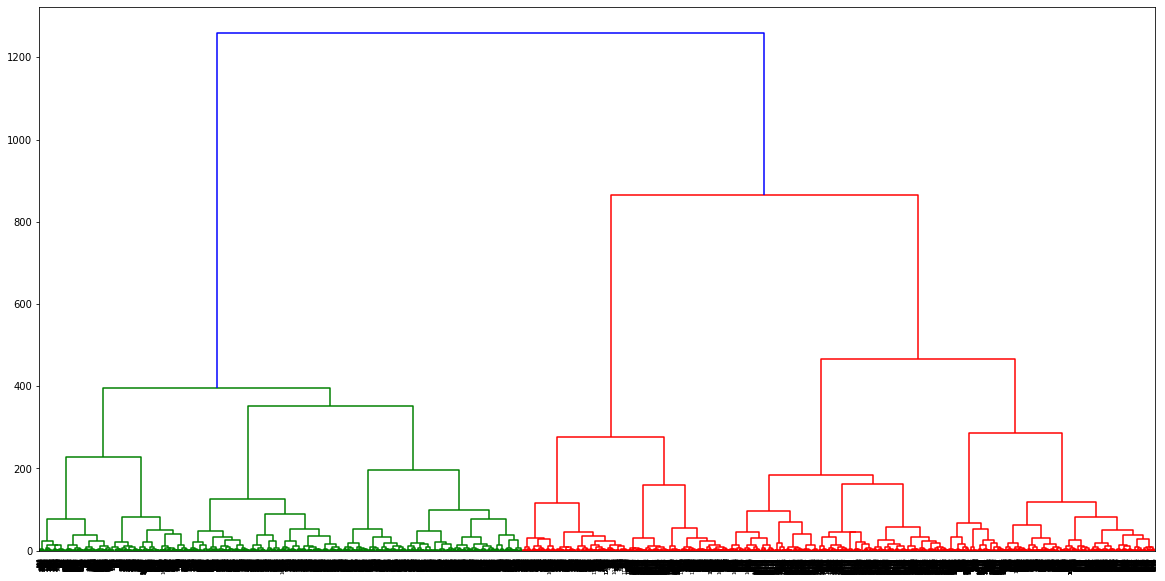

In [179]:
umap_results = umap.UMAP(n_neighbors=250,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_all)

agg_clusters = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
unique, counts = np.unique(agg_cluster.labels_, return_counts=True)
print(dict(zip(unique, counts)))

plt.figure(figsize=(20,10))
dendrogram(lnkg(umap_results, method='ward'))
plt.show()

## DBSCAN with PCA Components 

0.1 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: 0.09425378942311949


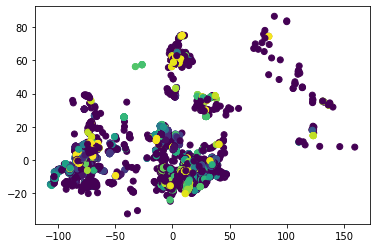



0.1 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: 0.012830941728569035


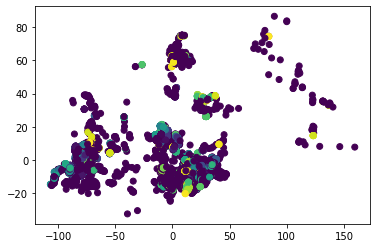



0.5 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: 0.16602308500929067


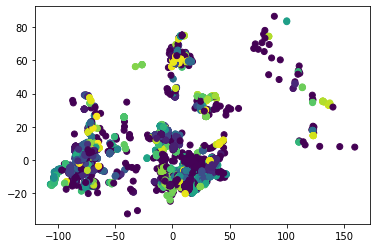



0.5 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: 0.1364490533701171


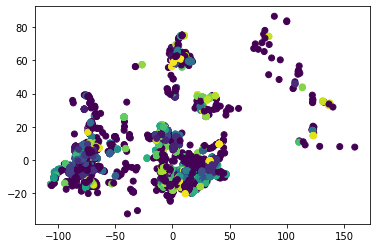



1 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: -0.03680612172222467


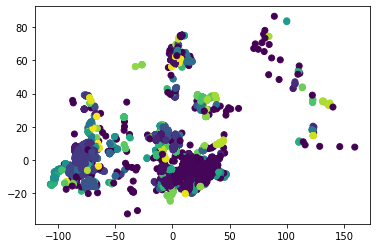



1 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: 0.01191070556287226


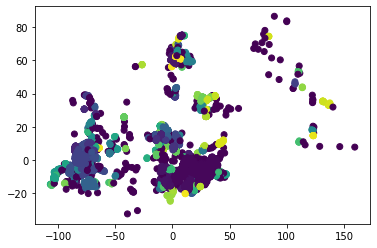



2 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: -0.21203210798287458


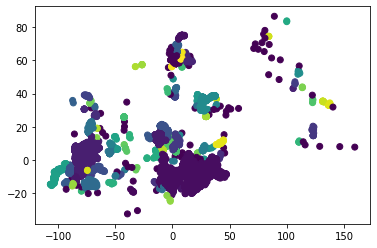



2 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: -0.14425678779685613


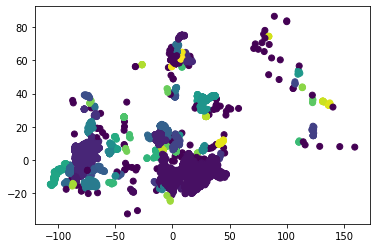



5 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: 0.4361073429440801


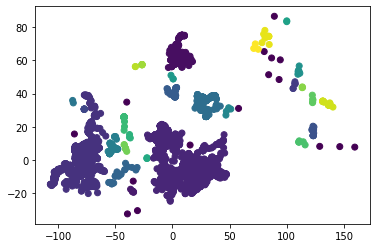



5 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: 0.43528035692409023


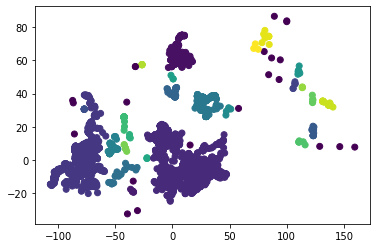



The greatest silhouette score is 0.4361073429440801.


In [33]:

silhouettes_dbpca = []
eps = [0.1, 0.5, 1, 2, 5]
min_samples = [2, 3]

for ep in eps:
    for min_sample in min_samples:
        print(ep, 'eps and', min_sample, 'min samples.')
        dbscan_cluster = DBSCAN(eps=ep, min_samples=min_sample)
        clusters = dbscan_cluster.fit_predict(pca_components) 
        try: 
            print("The silhoutte score of the DBSCAN solution: {}".format(metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
            silhouettes_dbpca.append(metrics.silhouette_score(pca_components, clusters, metric='euclidean'))
            plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
            plt.show()
            print('\n')
        except ValueError:
            print('\n')
            print('---------------------------------------------------')
            print('DBSCAN with', ep, 'eps and', min_sample, 'min samples was unable to find any clusters.')
            print('---------------------------------------------------')
            print('\n')
            
            
print('The greatest silhouette score is {}.'.format(max(silhouettes_dbpca)))

## DBSCAN With UMAP

0.1 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: 0.36663857102394104


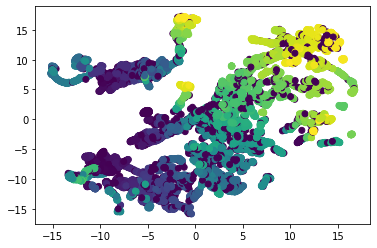



0.1 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: 0.34969693422317505


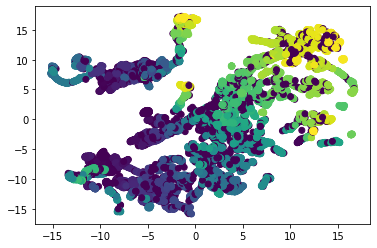



0.1 eps and 4 min samples.
The silhoutte score of the DBSCAN solution: 0.31901243329048157


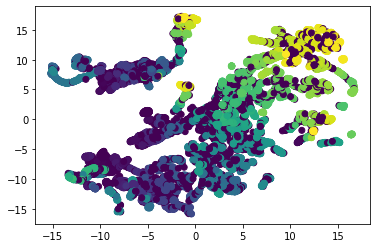



0.5 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: -0.20521128177642822


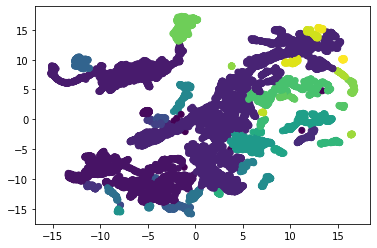



0.5 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: -0.17374609410762787


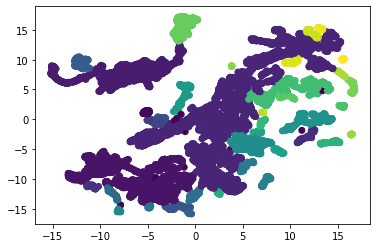



0.5 eps and 4 min samples.
The silhoutte score of the DBSCAN solution: -0.17374609410762787


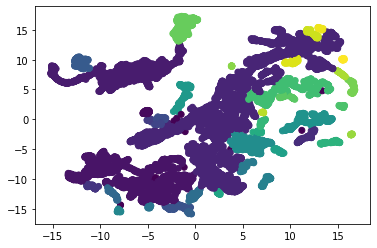



1 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: -0.18226313591003418


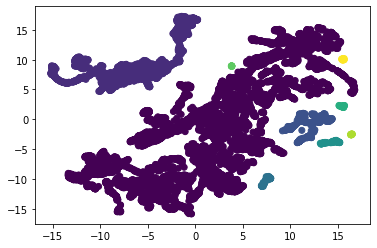



1 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: -0.18226313591003418


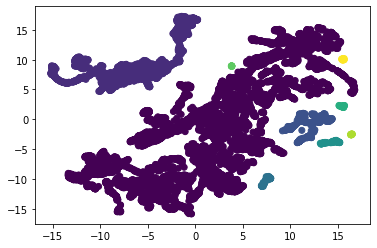



1 eps and 4 min samples.
The silhoutte score of the DBSCAN solution: -0.18226313591003418


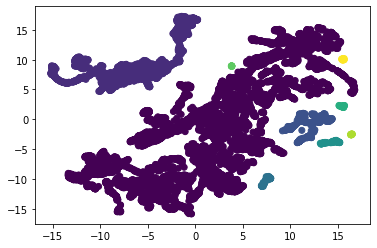



2 eps and 2 min samples.
The silhoutte score of the DBSCAN solution: 0.08262559026479721


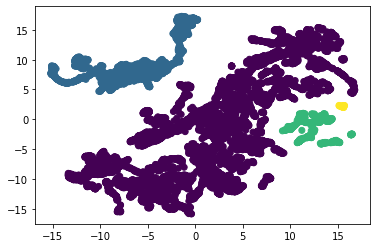



2 eps and 3 min samples.
The silhoutte score of the DBSCAN solution: 0.08262559026479721


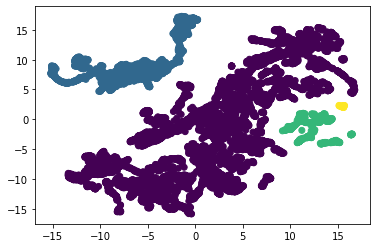



2 eps and 4 min samples.
The silhoutte score of the DBSCAN solution: 0.08262559026479721


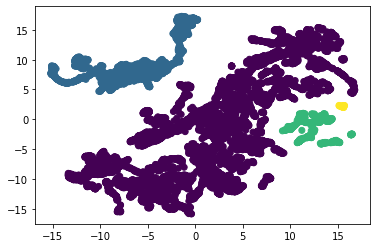



5 eps and 2 min samples.


---------------------------------------------------
DBSCAN with 5 eps and 2 min samples was unable to find any clusters.
---------------------------------------------------


5 eps and 3 min samples.


---------------------------------------------------
DBSCAN with 5 eps and 3 min samples was unable to find any clusters.
---------------------------------------------------


5 eps and 4 min samples.


---------------------------------------------------
DBSCAN with 5 eps and 4 min samples was unable to find any clusters.
---------------------------------------------------


The greatest silhouette score is 0.36663857102394104.


In [39]:
silhouettes_dbumap = []
eps = [0.1, 0.5, 1, 2, 5]
min_samples = [2, 3, 4]

for ep in eps:
    for min_sample in min_samples:
        print(ep, 'eps and', min_sample, 'min samples.')
        dbscan_cluster = DBSCAN(eps=ep, min_samples=min_sample)
        clusters = dbscan_cluster.fit_predict(umap_results)
        try: 
            print("The silhoutte score of the DBSCAN solution: {}".format(metrics.silhouette_score(umap_results, clusters, metric='euclidean')))
            silhouettes_dbumap.append(metrics.silhouette_score(umap_results, clusters, metric='euclidean'))
            plt.scatter(umap_results[:,0], umap_results[:,1], c=clusters)
            plt.show()
            print('\n')
        except ValueError:
            print('\n')
            print('---------------------------------------------------')
            print('DBSCAN with', ep, 'eps and', min_sample, 'min samples was unable to find any clusters.')
            print('---------------------------------------------------')
            print('\n')
            
print('The greatest silhouette score is {}.'.format(max(silhouettes_dbumap)))

In [171]:
umap_results = umap.UMAP(n_neighbors=250,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_all)

dbscan_cluster = DBSCAN(eps=0.1, min_samples=2)
clusters = dbscan_cluster.fit_predict(umap_results).labels_
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['dbscan_umap_clusters'] = clusters
# outbreaks[outbreaks['dbscan_umap_clusters'] == 3]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

## GMM With PCA Components

GMM with full covariance type and 2 components.
The silhoutte score of the GMM solution: 0.7631136226622801


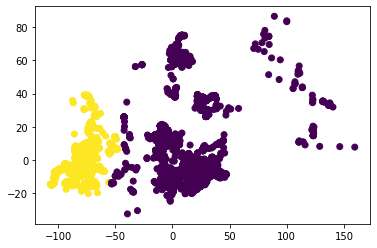



GMM with full covariance type and 4 components.
The silhoutte score of the GMM solution: 0.42539005344157405


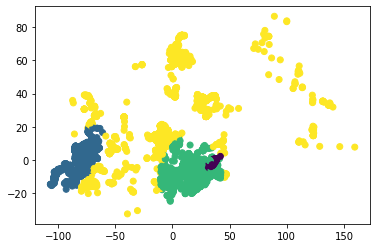



GMM with full covariance type and 6 components.
The silhoutte score of the GMM solution: 0.564214747009426


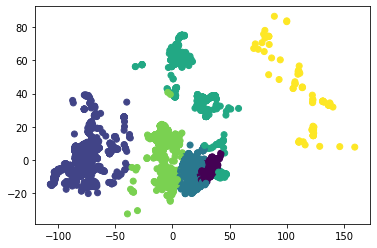



GMM with full covariance type and 8 components.
The silhoutte score of the GMM solution: 0.5415735064722084


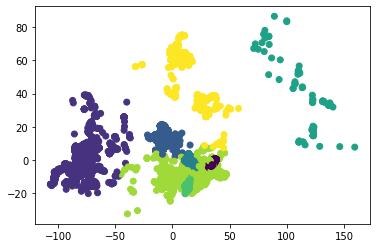



GMM with tied covariance type and 2 components.
The silhoutte score of the GMM solution: 0.7653019367401511


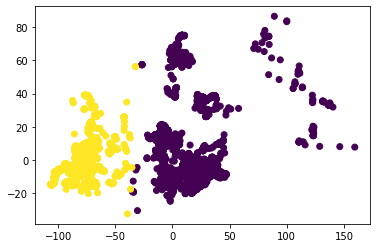



GMM with tied covariance type and 4 components.
The silhoutte score of the GMM solution: 0.6820032650141967


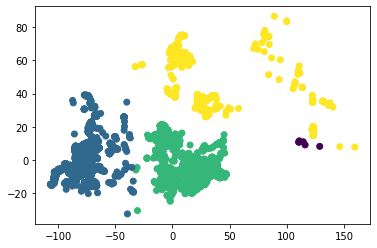



GMM with tied covariance type and 6 components.
The silhoutte score of the GMM solution: 0.5728784109910998


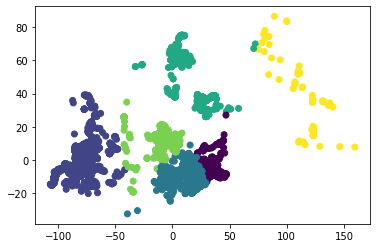



GMM with tied covariance type and 8 components.
The silhoutte score of the GMM solution: 0.6015170721141858


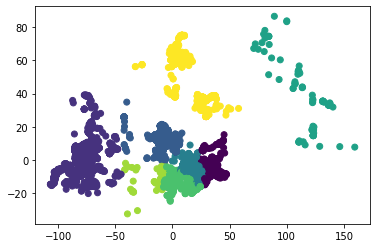



GMM with diag covariance type and 2 components.
The silhoutte score of the GMM solution: 0.7641098949967777


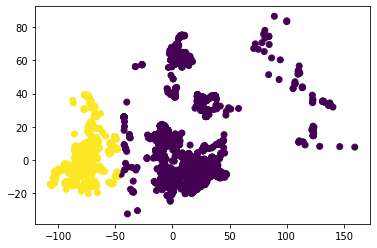



GMM with diag covariance type and 4 components.
The silhoutte score of the GMM solution: 0.369554687219387


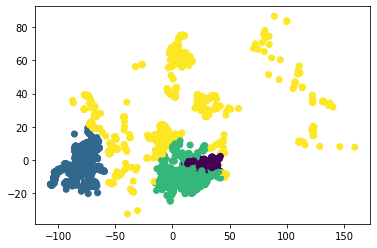



GMM with diag covariance type and 6 components.
The silhoutte score of the GMM solution: 0.5396352958348342


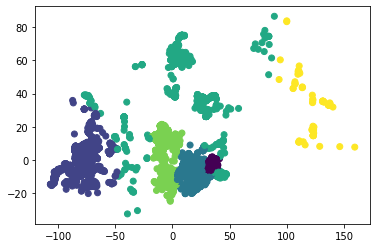



GMM with diag covariance type and 8 components.
The silhoutte score of the GMM solution: 0.524755417713504


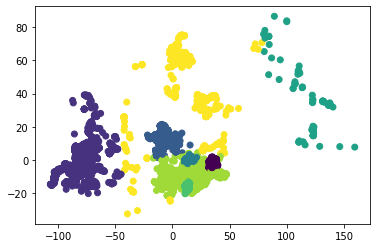



GMM with spherical covariance type and 2 components.
The silhoutte score of the GMM solution: 0.7640564767313001


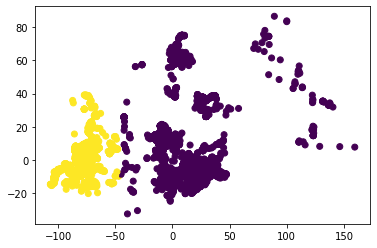



GMM with spherical covariance type and 4 components.
The silhoutte score of the GMM solution: 0.46183481222297224


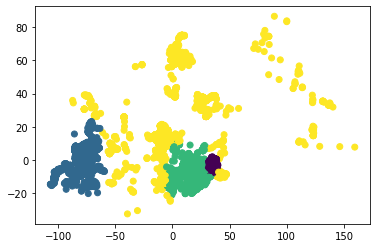



GMM with spherical covariance type and 6 components.
The silhoutte score of the GMM solution: 0.5467057017101712


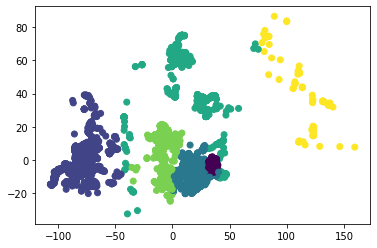



GMM with spherical covariance type and 8 components.
The silhoutte score of the GMM solution: 0.585004527970453


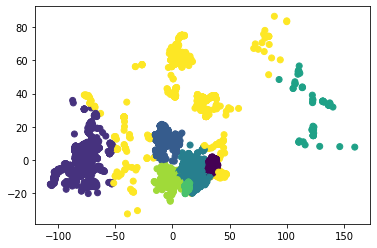



The greatest silhouette score is 0.7653019367401511.


In [67]:
silhouettes_gmmpca = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
n_components = [2, 3, 6, 8]

for c_type in covariance_types:
    for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type=c_type)
        clusters = gmm_cluster.fit_predict(pca_components)
        print('GMM with', c_type, 'covariance type and', n, 'components.')
        print("The silhoutte score of the GMM solution: {}".format(metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
        silhouettes_gmmpca.append(metrics.silhouette_score(pca_components, clusters, metric='euclidean'))
        plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
        plt.show()
        print('\n')
        
        
print('The greatest silhouette score is {}.'.format(max(silhouettes_gmmpca)))

## GMM with UMAP

GMM with full covariance type and 2 components.
The silhoutte score of the GMM solution: 0.4024505913257599


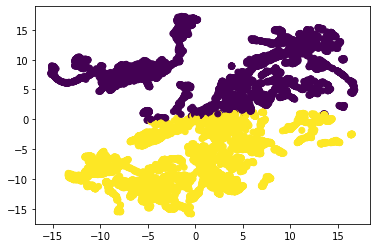



GMM with full covariance type and 3 components.
The silhoutte score of the GMM solution: 0.46771878004074097


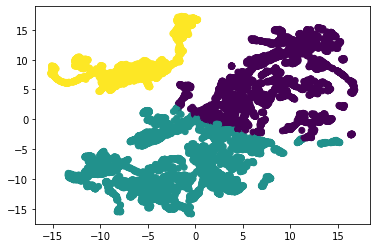



GMM with full covariance type and 4 components.
The silhoutte score of the GMM solution: 0.42993175983428955


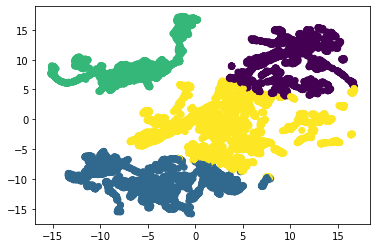



GMM with tied covariance type and 2 components.
The silhoutte score of the GMM solution: 0.39471200108528137


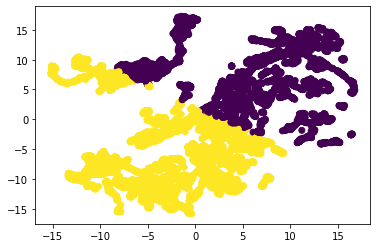



GMM with tied covariance type and 3 components.
The silhoutte score of the GMM solution: 0.47373032569885254


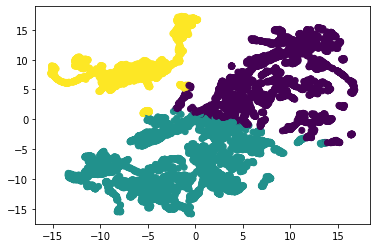



GMM with tied covariance type and 4 components.
The silhoutte score of the GMM solution: 0.43821293115615845


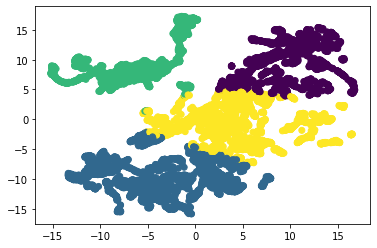



GMM with diag covariance type and 2 components.
The silhoutte score of the GMM solution: 0.40359869599342346


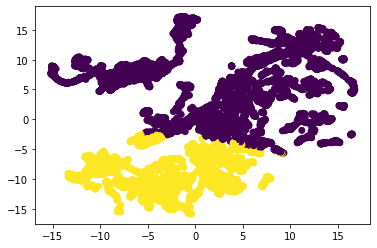



GMM with diag covariance type and 3 components.
The silhoutte score of the GMM solution: 0.4769498407840729


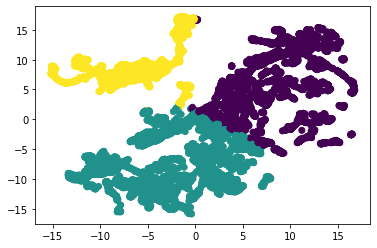



GMM with diag covariance type and 4 components.
The silhoutte score of the GMM solution: 0.4345618188381195


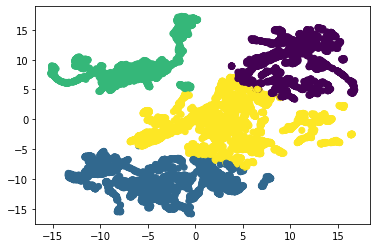



GMM with spherical covariance type and 2 components.
The silhoutte score of the GMM solution: 0.39486831426620483


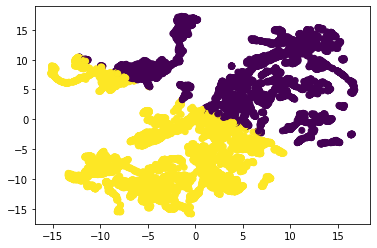



GMM with spherical covariance type and 3 components.
The silhoutte score of the GMM solution: 0.4708309471607208


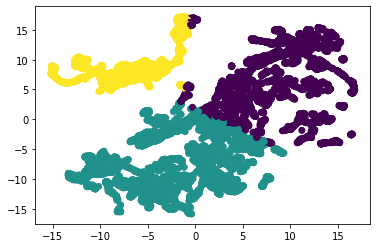



GMM with spherical covariance type and 4 components.
The silhoutte score of the GMM solution: 0.44742849469184875


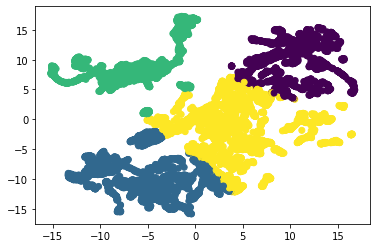



The greatest silhouette score is 0.4769498407840729.


In [38]:
silhouettes_gmmumap = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
n_components = [2, 3, 4]

for c_type in covariance_types:
    for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type=c_type)
        clusters = gmm_cluster.fit_predict(umap_results)
        print('GMM with', c_type, 'covariance type and', n, 'components.')
        print("The silhoutte score of the GMM solution: {}".format(metrics.silhouette_score(umap_results, clusters, metric='euclidean')))
        silhouettesgmm_umap.append(metrics.silhouette_score(umap_results, clusters, metric='euclidean'))
        plt.scatter(umap_results[:,0], umap_results[:,1], c=clusters)
        plt.show()
        print('\n')
        
print('The greatest silhouette score is {}.'.format(max(silhouettes_gmmumap)))

In [37]:
print(silhouettes)

[0.2389757046596071, 0.13861990765488535, 0.11399873887651056, -0.0775588669722165, 0.05261414081572756, 0.15915041900950497, 0.14095555842770388, -0.09253517519182018, 0.04742101082042384, 0.14254185729837013, 0.08722610707068036, -0.07423207162294544, 0.06308091713722512, 0.11371808641504058, 0.09000811603219577, -0.0837221801524133]


In [ ]:
bar graph of each feature with the average in each cluster
group by cluster

In [75]:
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='tied')
gmm_clusters = gmm_cluster.fit_predict(pca_components)
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['gmm_cluster'] = gmm_clusters
outbreaks.head()


{0: 10327, 1: 2375}


Id source   latitude  longitude  region             country  \
0  230399    OIE -27.900000  30.800000  Africa        South Africa   
1  230381    OIE  54.837037  73.354155  Europe  Russian Federation   
3  230396    OIE -26.000000  28.300000  Africa        South Africa   
4  230371    OIE  49.237900  17.700200  Europe      Czech Republic   
5  230370    OIE  49.237300  17.700800  Europe      Czech Republic   

  localityQuality observationDate reportingDate     status  \
0           Exact      2017-08-17    2017-08-22  Confirmed   
1           Exact      2017-08-16    2017-08-18  Confirmed   
3           Exact      2017-08-15    2017-08-22  Confirmed   
4           Exact      2017-08-15    2017-08-17  Confirmed   
5           Exact      2017-08-15    2017-08-17  Confirmed   

               disease  serotypes              speciesDescription  \
0    Influenza - Avian  H5N8 HPAI  [domestic,, unspecified, bird]   
1  African swine fever     Uknown              [domestic,, swine]   
3    Influenza - Avian  H5N8 HPAI      [wild,, unspecified, bird]   
4  African swine fever     Uknown             [wild,, wild, boar]   
5  African swine fever     Uknown             [wild,, wild, boar]   

       sumAtRisk  sumCases  sumDeaths  sumDestroyed  sumSlaughtered  \
0  248000.000000      12.0       12.0  50000.000000        0.000000   
1     122.000000       6.0        1.0      0.000000        0.000000   
3    7500.691709       1.0        1.0      0.000000        0.000000   
4    7500.691709       1.0        1.0   3765.857978      100.211443   
5    7500.691709       1.0        1.0   3765.857978      100.211443   

   humansAge  humansAffected  humansDeaths  differenceInDays  observationYear  \
0   0.000000             1.0           1.0               5.0             2017   
1  17.701311             1.0           1.0               2.0             2017   
3   0.000000             1.0           1.0               7.0             2017   
4  17.701311             1.0           1.0               2.0             2017   
5  17.701311             1.0           1.0               2.0             2017   

   observationMonth  observationDay  observationFirstHalfMonth  \
0                 8              17                          0   
1                 8              16                          0   
3                 8              15                          1   
4                 8              15                          1   
5                 8              15                          1   

   observationSecondHalfMonth  EC  FAO Field Officer  FAO officer  FAO-Report  \
0                           1   0                  0            0           0   
1                           1   0                  0            0           0   
3                           0   0                  0            0           0   
4                           0   0                  0            0           0   
5                           0   0                  0            0           0   

   International reference laboratory  \
0                                   0   
1                                   0   
3                                   0   
4                                   0   
5                                   0   

   National Institute for Communicable Diseases, NICD  National authorities  \
0                                                  0                      0   
1                                                  0                      0   
3                                                  0                      0   
4                                                  0                      0   
5                                                  0                      0   

   OIE  Other  Publications  WHO  sequence only  Africa  Americas  Asia  \
0    1      0             0    0              0       1         0     0   
1    1      0             0    0              0       0         0     0   
3    1      0             0    0              0      

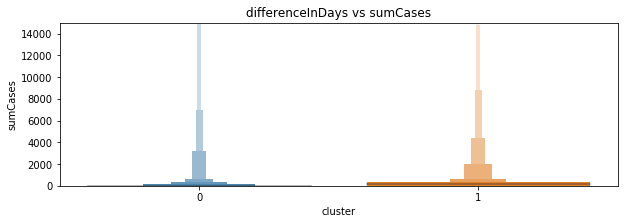

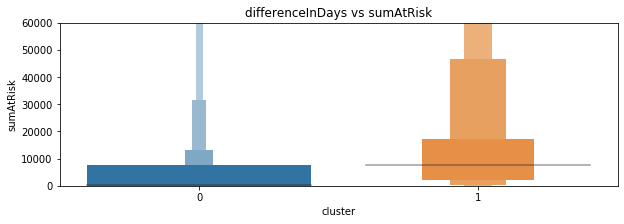

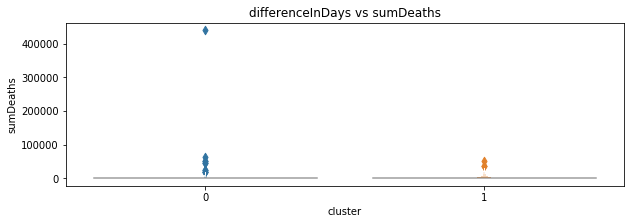

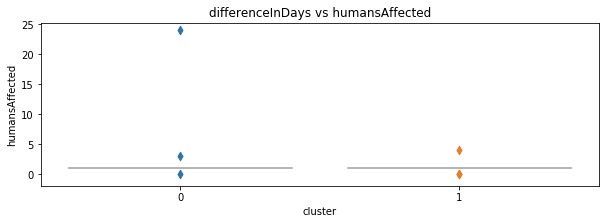

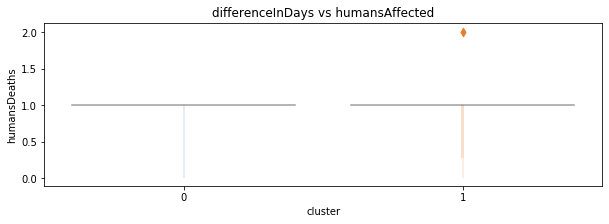

In [76]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['cluster'], y=outbreaks['sumCases'])
plt.title('differenceInDays vs sumCases')
box.set_ylim(0, 15000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=outbreaks['cluster'], y=outbreaks['sumAtRisk'])
plt.title('differenceInDays vs sumAtRisk')
box.set_ylim(0, 60000)
plt.show()

plt.figure(figsize=(10,3))
bpx = sns.boxenplot(x=outbreaks['cluster'], y=outbreaks['sumDeaths'])
plt.title('differenceInDays vs sumDeaths')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['cluster'], y=outbreaks['humansAffected'])
plt.title('differenceInDays vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=outbreaks['cluster'], y=outbreaks['humansDeaths'])
plt.title('differenceInDays vs humansAffected')
# scatterplot.set_xlim(0, 600)
plt.show()

## Neural Networks

## RBM

In [ ]:
rbm = BernoulliRBM(n_components=64, learning_rate=0.1,
                            batch_size=10, random_state=9)

In [108]:
# number of neurons in the encoding hidden layer
encoding_dim = 5
# input placeholder
input_data = Input(shape=(6,)) # 6 is the number of features/columns
# encoder is the encoded representation of the input
encoded = Dense(encoding_dim, activation ='relu')(input_data)
# decoder is the lossy reconstruction of the input
decoded = Dense(6, activation ='sigmoid')(encoded) # 6 again number of features and should match input_data


# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)




# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)
# model optimizer and loss
autoencoder = Model(input_data, decoded)

# loss function and optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train test split
x_train, x_test, = train_test_split(data, test_size=0.1, random_state=42)


# train the model
autoencoder.fit(x_train,
                x_train,
                epochs=50,
                batch_size=256,
                shuffle=True)

autoencoder.summary()

# predict after training
# note that we take them from the *test* set
encoded_data = encoder.predict(x_test)

NameError: name 'X' is not defined